# Supervised Learning for HR Separations
## December 30, 2015
<hr>

### 1. Start with partially processed data
* filename = 'after2001_v3.csv'
* historical columns removed
* RATE column removed
* Dates converted to timestamps
* calculated the age/tenure and hire_age
* converted indicator variables to 1/0
* converted BOX1 to {0,1,2,3}

####define the source repo
* '/home/kesj/lib/repo/'
### 2. Define the correct working directories
* '/data/discovery/hrsepara/core/' for HDFS
* '/data/discovery/hrsepara/staging/eda' and '/home/kesj/working/hrsepara/eda/' for HDFS and LFS on phd
* ' /home/hrsepara/work/data'

In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
#stgdir1local = '/home/kesj/work/hrsepara/eda'
#stgdir2local = '/home/kesj/work/hrsepara/proc'
repodir = '/home/kesj/lib/repo/'
datadirlocal = '/home/hrsepara/work/data'

In [2]:
### load the basic files
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
plt.style.use('ggplot')
from sklearn import cross_validation

In [3]:
os.chdir(repodir)
import bear.bear as br


/opt/anaconda/2.3.0/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/opt/anaconda/2.3.0/lib/python2.7/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [5]:
## save this dataframe
os.chdir(datadirlocal)

## Start loading here

In [6]:
em2002 = pd.read_csv('after2001_v3.csv',dtype={'EEO1CODE':np.str,'EMPL_CLASS':np.str})
em2002.shape

(134266, 69)

#### Get categorical columns and process them

In [7]:
col3_categorical = br.get_categorical(em2002)
col3_numeric = br.get_numeric(em2002)
print len(col3_numeric), len(col3_categorical)

55 14


In [8]:
for c in col3_categorical: #cat_cols:
    nobs = len(em2002[c].unique())
    #if nobs == 2:
        #indicator_cols.append(c)
    #else:
    print c, nobs
    #    cat_cols2.append(c)
print "============"
numeric_to_categorical = ['COMPANY','DIVISION_CODE_SFI','ETHNIC_GROUP']
for c in numeric_to_categorical:
    print c, len(em2002[c].unique())

EEO1CODE 10
birth_tstmp 20171
FULL_PART_TIME 4
EMPL_CLASS 6
FLSA_STATUS 3
LOC_STATE 52
GRADE 125
JOB_FAMILY 1448
hire_tstmp 8881
LOCATION 13030
term_tstmp 4353
JOB_FUNCTION 19
EMPL_TYPE 5
LOC_TYPE_DESCR_SFI 31
COMPANY 6
DIVISION_CODE_SFI 9
ETHNIC_GROUP 8


In [9]:
cat_cols_to_dummy_encode = ['EMPL_TYPE','EMPL_CLASS','EEO1CODE','FULL_PART_TIME','FLSA_STATUS','LOC_TYPE_DESCR_SFI',
                           'COMPANY','DIVISION_CODE_SFI','ETHNIC_GROUP','JOB_FUNCTION']
my_label_encode_cols = ['JOB_FAMILY', 'GRADE', 'FLOR_SFI', 'FUNC_ID_SFI', 'EXT_FUNC_ID_SFI',
                        'JOBCODE', 'LOC_STATE']

## December 31, 2015

* The extended Functions (EXT_FUNC_ID_SFI) Jeff Briks is interested in are:
    * CCC Sales (00892)
    * CCC Service (00071)
    * Life Health Response Center (00816)
    * Enterprise Auto Express (00909)
    * Enterprise ILR (00910)
    * State Farm Bank (00517)
    * SFPP (00835)
* The jobs (JOBCODES) he is interested in are these:
    * CCC Service Rep (6200)
    * CCC Sales Rep (1876)
    * Life Customer Service Asst (2638, 2639, & 2641)
    * Claim Associate-Express (0983 & 0984)
    * Claim Associate-ILR (1009)
    * Claim Team Manager – ILR (0986)
    * Bank Customer Service Rep (0851, 852, & 0853)
    * SFPP Account Rep (4105)

I need to make sure that I keep these columns around

In [10]:
[(col,em2002[col].dtype,em2002[col].nunique()) for col in cat_cols_to_dummy_encode]

[('EMPL_TYPE', dtype('O'), 5),
 ('EMPL_CLASS', dtype('O'), 6),
 ('EEO1CODE', dtype('O'), 10),
 ('FULL_PART_TIME', dtype('O'), 4),
 ('FLSA_STATUS', dtype('O'), 3),
 ('LOC_TYPE_DESCR_SFI', dtype('O'), 30),
 ('COMPANY', dtype('int64'), 6),
 ('DIVISION_CODE_SFI', dtype('int64'), 9),
 ('ETHNIC_GROUP', dtype('float64'), 8),
 ('JOB_FUNCTION', dtype('O'), 19)]

In [11]:
[(col,em2002[col].dtype,em2002[col].nunique()) for col in my_label_encode_cols]

[('JOB_FAMILY', dtype('O'), 1448),
 ('GRADE', dtype('O'), 125),
 ('FLOR_SFI', dtype('int64'), 109),
 ('FUNC_ID_SFI', dtype('int64'), 53),
 ('EXT_FUNC_ID_SFI', dtype('int64'), 338),
 ('JOBCODE', dtype('int64'), 2589),
 ('LOC_STATE', dtype('O'), 52)]

In [11]:
em2002.LOC_STATE.value_counts()

IL    24582
TX    16475
GA     9635
CA     8954
FL     8857
AZ     7362
NY     4392
OH     4043
WA     4011
PA     3765
MO     3655
VA     3516
CO     3479
TN     3332
NE     2698
AL     2695
MD     2664
MI     2593
IN     2298
LA     2131
MN     2092
OK     1998
NJ     1754
OR      840
NC      749
SC      700
WI      497
AR      407
KY      393
IA      383
KS      370
WV      357
NV      342
MS      335
UT      258
CT      243
NM      217
ID      170
MT      159
DE      135
HI      127
AK      112
SD       89
ME       76
MA       71
ND       70
WY       68
NH       63
VT       26
DC       22
XX        5
RI        1
Name: LOC_STATE, dtype: int64

## So don't Label encode or dumy encode these:
ExT_FUNCT_ID_SFI, JOBCODE, FLOR_SFI, FUNC_ID_SFI

## Set up a dictionary for some of these 'interesting' jobs

In [12]:
#interesting_extended_functions = [892,71, 816, 909,910,517,835]
extFuncDict ={}
extFuncDict[892]='CCC Sales'
extFuncDict[71]='CCC Service'
extFuncDict[816]='Life Health Response Center'
#(00816)
extFuncDict[909]='Enterprise Auto Express'
extFuncDict[910]='Enterprise ILR' 
extFuncDict[517]='State Farm Bank'
extFuncDict[835]='SFPP'
interesting_extended_functions = extFuncDict.keys()
extFuncDict

{71: 'CCC Service',
 517: 'State Farm Bank',
 816: 'Life Health Response Center',
 835: 'SFPP',
 892: 'CCC Sales',
 909: 'Enterprise Auto Express',
 910: 'Enterprise ILR'}

In [13]:
[(v,len(em2002[em2002.EXT_FUNC_ID_SFI==k])) for k,v in extFuncDict.iteritems()]
# simple count of observations

[('SFPP', 1991),
 ('State Farm Bank', 2936),
 ('CCC Service', 6536),
 ('Enterprise Auto Express', 3193),
 ('Enterprise ILR', 3278),
 ('Life Health Response Center', 1045),
 ('CCC Sales', 3364)]

In [14]:
len(em2002[em2002.EXT_FUNC_ID_SFI == 982])

276

In [15]:
jobCodeDict = {}
jobCodeDict[6200]= 'CCC Service Rep'
jobCodeDict[1876]= 'CCC Sales Rep'
jobCodeDict[1009]='CLaim Associate-ILR'
jobCodeDict[986]='CLaim Team Manager-ILR'
jobCodeDict[983]='Claim Associate-Express'
jobCodeDict[984]='Claim Associate-Express'
jobCodeDict[2638]='Life Customer Service Asst'
jobCodeDict[2639]='Life Customer Service Asst'
jobCodeDict[2641]='Life Customer Service Asst'
jobCodeDict[4105]= 'SFPP Account Rep'
jobCodeDict[851]= 'Bank Customer Service Rep'
jobCodeDict[852]= 'Bank Customer Service Rep'
jobCodeDict[853]= 'Bank Customer Service Rep'
interesting_jobcodes =  jobCodeDict.keys()
jobCodeDict

{851: 'Bank Customer Service Rep',
 852: 'Bank Customer Service Rep',
 853: 'Bank Customer Service Rep',
 983: 'Claim Associate-Express',
 984: 'Claim Associate-Express',
 986: 'CLaim Team Manager-ILR',
 1009: 'CLaim Associate-ILR',
 1876: 'CCC Sales Rep',
 2638: 'Life Customer Service Asst',
 2639: 'Life Customer Service Asst',
 2641: 'Life Customer Service Asst',
 4105: 'SFPP Account Rep',
 6200: 'CCC Service Rep'}

In [16]:
[(v,len(em2002[em2002.JOBCODE==k])) for k,v in jobCodeDict.iteritems()]
# simple count of observations

[('Claim Associate-Express', 2471),
 ('Life Customer Service Asst', 594),
 ('SFPP Account Rep', 845),
 ('Life Customer Service Asst', 550),
 ('Life Customer Service Asst', 751),
 ('CLaim Associate-ILR', 2818),
 ('Bank Customer Service Rep', 440),
 ('CCC Sales Rep', 3161),
 ('Bank Customer Service Rep', 69),
 ('Claim Associate-Express', 147),
 ('CCC Service Rep', 5857),
 ('Bank Customer Service Rep', 67),
 ('CLaim Team Manager-ILR', 211)]

In [17]:
invJobCodeDict = {}
invJobCodeDict['CCC Service Rep'] = [6200]
invJobCodeDict['CCC Sales Rep'] = [1876]
invJobCodeDict['Life Customer Service Asst'] = [2638,2639,2641]
invJobCodeDict['Claim Associate-Express'] = [983,984]
invJobCodeDict['Claim Associate-ILR'] = [1009]
invJobCodeDict['Claim Team Manager-ILR'] = [986]
invJobCodeDict['Bank Customer Service Rep'] = [851,852,853]
invJobCodeDict['SFPP Account Rep'] = [4105]#2638,2639,2641]
interest_job_names_list = invJobCodeDict.keys()

In [18]:
sum(em2002['JOBCODE'].isin(invJobCodeDict['CCC Service Rep'])), sum (em2002['JOBCODE']==6200)

(5857, 5857)

In [19]:
len(em2002[(em2002['JOBCODE']==983) | ( em2002['JOBCODE']==984)])

2618

In [20]:
for k in invJobCodeDict.keys():
    print k, sum(em2002['JOBCODE'].isin(invJobCodeDict[k]))

CCC Service Rep 5857
Claim Associate-ILR 2818
Claim Team Manager-ILR 211
CCC Sales Rep 3161
Claim Associate-Express 2618
SFPP Account Rep 845
Life Customer Service Asst 1895
Bank Customer Service Rep 576


In [21]:
from lifelines import KaplanMeierFitter
kmf=KaplanMeierFitter()


kmf.fit(em2002['Tenure_years'],event_observed=em2002['former'],label='all')
    #survivalfunc_df = pd.DataFrame(kmf.survival_function_)

<lifelines.KaplanMeierFitter: fitted with 134266 observations, 84592 censored>

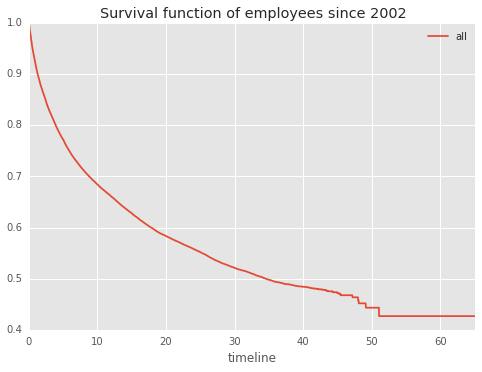

In [22]:
kmf.survival_function_.plot()
plt.title('Survival function of employees since 2002')

In [23]:
T = em2002['Tenure_years'] #duration
C = em2002['former'] # observation

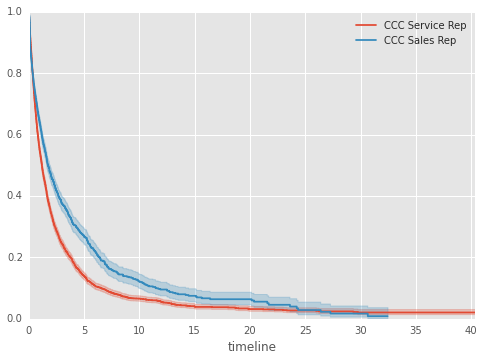

In [26]:
ax1=plt.subplot(111)
#plt.hold()
gp = em2002['JOBCODE'].isin([6200])
kmf.fit(T[gp],event_observed=C[gp],label='CCC Service Rep')
kmf.plot(ax=ax1)
gp = em2002['JOBCODE'].isin([1876])
kmf.fit(T[gp],event_observed=C[gp],label='CCC Sales Rep')
kmf.plot(ax=ax1)

CCC Service Rep [6200]
Median survival tenure of CCC Service Rep is : 1.17453798768
Claim Associate-ILR [1009]
Median survival tenure of Claim Associate-ILR is : 1.61259411362
Claim Team Manager-ILR [986]
Median survival tenure of Claim Team Manager-ILR is : inf
CCC Sales Rep [1876]
Median survival tenure of CCC Sales Rep is : 1.73032169747
Claim Associate-Express [983, 984]
Median survival tenure of Claim Associate-Express is : 23.9260780287
SFPP Account Rep [4105]
Median survival tenure of SFPP Account Rep is : 0.881587953457
Life Customer Service Asst [2638, 2639, 2641]
Median survival tenure of Life Customer Service Asst is : 7.1485284052
Bank Customer Service Rep [851, 852, 853]
Median survival tenure of Bank Customer Service Rep is : 3.24161533196


(0, 1)

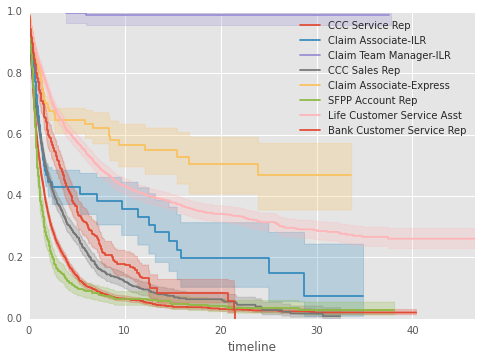

In [27]:

plt.figure()
ax = plt.subplot(111)

#t = np.linspace(0,50,51)
for k,v in invJobCodeDict.items():
    print k,v
    gp=(em2002['JOBCODE'].isin(invJobCodeDict[k]))
    #gpName.append(v)
    kmf.fit(T[gp],event_observed=C[gp],label=k)
    kmf.plot(ax=ax)
    
    print "Median survival tenure of {0} is : {1}".format(k,kmf.median_)


plt.ylim(0,1)

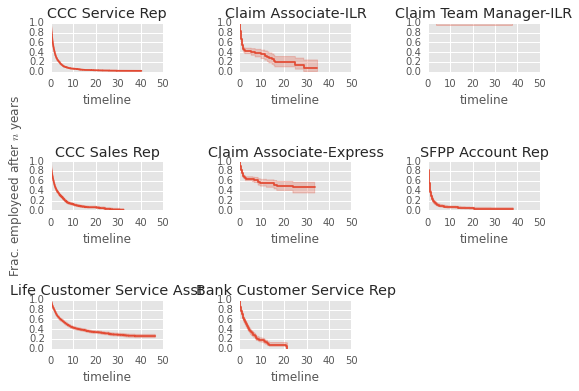

In [354]:
#regime_types = data['regime'].unique()
i=0
for k,v in invJobCodeDict.items():
    ax = plt.subplot(3,3,i+1)
    ix = em2002['JOBCODE'].isin(v)
    kmf.fit( T[ix], C[ix], label=k )
    kmf.plot(ax=ax, legend=False)
    plt.title(k)
    plt.xlim(0,50)
    plt.ylim(0,1.0)
    if i==3:
        plt.ylabel('Frac. employeed after $n$ years')
    i+=1
plt.tight_layout()

## Take a look at the numeric columns

In [28]:
true_numeric = list(set(col3_numeric)-set(numeric_to_categorical)-set(my_label_encode_cols))
true_numeric.sort()
len(true_numeric)

48

In [18]:
[(col,em2002[col].nunique(), em2002[col].max()) for col in true_numeric]

[('ADDRCNT1', 5, 4.0),
 ('ANNUAL_RT', 95474, 725000.0),
 ('Age_years', 18247, 98.195756331299989),
 ('BOX1', 4, 3),
 ('COMP_FREQUENCY', 2, 1),
 ('DEPENDENT_CNT', 28, 50.0),
 ('DEPTCNT1', 8, 7),
 ('DIRECT_RPT_CNT', 173, 318.0),
 ('EFUNCCNT1', 5, 4),
 ('EXTFUNC_CNT', 6518, 17761.0),
 ('FLOORCNT1', 6, 5),
 ('FTE', 77, 1.0700000000000001),
 ('FTPTCNT1', 3, 2),
 ('FULLPART1', 2, 1),
 ('FUNCCNT1', 4, 3),
 ('FUNC_CNT', 7807, 37341.0),
 ('GRADECNT1', 5, 4),
 ('HAVE_DEP', 2, 1),
 ('HAVE_INS', 2, 1),
 ('HUBIND', 2, 1),
 ('INTERN', 2, 1),
 ('JOBCNT1', 7, 6),
 ('KEY', 134266, 999999183695763),
 ('LOCCNT1', 7, 6),
 ('LOCSTCNT1', 4, 3),
 ('MAX_RT_ANNUAL', 1002, 999999.0),
 ('MERIT1', 74185, 35000.0),
 ('MIN_RT_ANNUAL', 1255, 203700.0),
 ('PARTFULL1', 2, 1),
 ('PERF1', 78546, 56751.139999999999),
 ('PTFTCNT1', 3, 2),
 ('REH_CNT', 18, 18),
 ('RELOCATE_ALL_SFI', 2, 1),
 ('RELO_STATE_CNT_SFI', 55, 54),
 ('REMOTE', 2, 1),
 ('REMOTE_SUPV', 2, 1),
 ('SAL1', 95474, 725000.0),
 ('SEX', 2, 1),
 ('SHIFT', 4, 3

In [29]:
iterative_modeling_cols = [col for col in true_numeric]
iterative_modeling_cols.remove('status')
iterative_modeling_cols.remove('retired')
iterative_modeling_cols.remove('KEY')
iterative_modeling_cols.remove('former')
iterative_modeling_cols.remove('Tenure_years')
iterative_modeling_cols.remove('ANNUAL_RT')
iterative_modeling_cols.remove('Age_years')
iterative_modeling_cols.remove('hire_age')
len(iterative_modeling_cols)

40

In [20]:

br.perfect_collinearity_test(em2002[iterative_modeling_cols])

ADDRCNT1           VIF = 1.0   R^2 = 0.0216    
BOX1               VIF = 2.5   R^2 = 0.6069    
COMP_FREQUENCY     VIF = 1.7   R^2 = 0.4163    
DEPENDENT_CNT      VIF = 3.0   R^2 = 0.6706    
DEPTCNT1           VIF = 7.7   R^2 = 0.8705    
DIRECT_RPT_CNT     VIF = 3.9   R^2 = 0.7452    
EFUNCCNT1          VIF = 11.5  R^2 = 0.9129    
EXTFUNC_CNT        VIF = 20.3  R^2 = 0.9507    
FLOORCNT1          VIF = 9.2   R^2 = 0.8915    
FTE                VIF = 86.3  R^2 = 0.9884    
FTPTCNT1           VIF = 69.6  R^2 = 0.9856    
FULLPART1          VIF = 69.6  R^2 = 0.9856    
FUNCCNT1           VIF = 1.3   R^2 = 0.2443    
FUNC_CNT           VIF = 7.0   R^2 = 0.8579    
GRADECNT1          VIF = 3.5   R^2 = 0.7106    
HAVE_DEP           VIF = 4.3   R^2 = 0.7669    
HAVE_INS           VIF = 2.9   R^2 = 0.6549    
HUBIND             VIF = 4.5   R^2 = 0.7761    
INTERN             VIF = 13.9  R^2 = 0.9282    
JOBCNT1            VIF = 3.8   R^2 = 0.7351    
LOCCNT1            VIF = 6.4   R^2 = 0.8

ADDRCNT1              0.021571
BOX1                  0.606944
COMP_FREQUENCY        0.416313
DEPENDENT_CNT         0.670565
DEPTCNT1              0.870456
DIRECT_RPT_CNT        0.745153
EFUNCCNT1             0.912902
EXTFUNC_CNT           0.950653
FLOORCNT1             0.891512
FTE                   0.988417
FTPTCNT1              0.985629
FULLPART1             0.985640
FUNCCNT1              0.244255
FUNC_CNT              0.857881
GRADECNT1             0.710612
HAVE_DEP              0.766897
HAVE_INS              0.654909
HUBIND                0.776138
INTERN                0.928235
JOBCNT1               0.735085
LOCCNT1               0.843933
LOCSTCNT1             0.428320
MAX_RT_ANNUAL         0.965977
MERIT1                0.677342
MIN_RT_ANNUAL         0.859079
PARTFULL1             0.998383
PERF1                 0.677952
PTFTCNT1              0.998384
REH_CNT               0.629394
RELOCATE_ALL_SFI      0.973434
RELO_STATE_CNT_SFI    0.974138
REMOTE                0.433477
REMOTE_S

## Create a Test-Train split

In [30]:
# repeat the split

# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(em2002))
eval_fraction = 0.20
e2build, e2eval = cross_validation.train_test_split(em2002,test_size=eval_fraction,random_state = 77843)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(e2eval),len(e2build))

Starting with subset of 134266 employees.
Evaluation set has 26854 employees; training set has 107412 employees.


In [31]:
e2build.former.value_counts()

0    67728
1    39684
Name: former, dtype: int64

In [32]:
e2eval.former.value_counts()

0    16864
1     9990
Name: former, dtype: int64

In [24]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import metrics
from sklearn.base import BaseEstimator,TransformerMixin

## Try using a pipe

In [25]:
my_label_encode_cols = ['JOB_FAMILY', 'GRADE', 'JOB_FUNCTION',
 #'FLOR_SFI', 'FUNC_ID_SFI', 'EXT_FUNC_ID_SFI', 'JOBCODE', # to keep these as observed
                        'LOC_TYPE_DESCR_SFI', 'LOC_STATE']
cat_cols_to_dummy_encode = ['EMPL_CLASS','EEO1CODE','EMPL_TYPE','FULL_PART_TIME']#,'ETHNIC_GROUP','DIVISION_CODE_SFI','COMPANY']

In [26]:
my_label_encode_cols

['JOB_FAMILY', 'GRADE', 'JOB_FUNCTION', 'LOC_TYPE_DESCR_SFI', 'LOC_STATE']

In [27]:
#set(my_label_encode_cols).intersection(em2002.columns.tolist())

In [28]:
my_minfix_cols = ['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1']
my_maxfix_cols = ['MAX_RT_ANNUAL']
missing_zero_cols = ['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT']
mode_impute_cols = ['MERIT1','PERF1','ADDRCNT1']

In [29]:
em2002[my_minfix_cols].describe()

,SAL1,MIN_RT_ANNUAL,MERIT1,PERF1
count,134266.000000,134266.000000,134266.000000,134266.000000
mean,54953.641146,39854.189112,1317.234767,1644.164758
std,31881.929036,20025.597103,1924.660917,1804.179432
min,0.000000,0.000000,-45000.000000,0.000000
25%,31045.350000,26574.011000,0.160000,103.470000
50%,46552.930000,35830.250000,1105.620000,1183.435000
75%,73224.405000,50149.010000,1989.060000,2584.737500
max,725000.000000,203700.000000,35000.000000,56751.140000


In [30]:
my_cols_to_omit = []
my_cols_to_omit.append('status')
my_cols_to_omit.append('retired')
my_cols_to_omit.append('KEY')
#my_cols_to_omit.append('former')
#my_cols_to_omit.append('Tenure_years')
my_cols_to_omit.append('ANNUAL_RT')
#my_cols_to_omit.append('Age_years')
my_cols_to_omit.append('hire_age')
my_cols_to_omit.append('birth_tstmp')
my_cols_to_omit.append('hire_tstmp')
my_cols_to_omit.append('term_tstmp')
len(my_cols_to_omit)

8

In [31]:
[a for a in e2build.columns.tolist() if a.endswith('tstmp')]

['birth_tstmp', 'hire_tstmp', 'term_tstmp']

In [32]:
pipe0 = Pipeline([("null",br.RemoveAllNull()),
                 ("drop",br.DropColumns(columns_to_drop =my_cols_to_omit)),
                 ("label_encode",br.LabelEncodeColumn(my_label_encode_cols)),
                 
                 #("dummy_encode", br.DummyEncodeColumn(cat_cols_to_dummy_encode)),
                 #("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 ("dummy_encode",br.ConvertCategorical(categorical_columns=cat_cols_to_dummy_encode,method='dummy')),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=my_minfix_cols,criteria_coef=('percentile',2),
                                                   method='lower',fill_with='nearest_value')),
                 ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_ANNUAL_RT'],criteria_coef=('percentile',2),
                                                   method='both',fill_with='nearest_value')),
                 ("fill_missingzero",br.FillMissingValue(columns_to_fix=missing_zero_cols,fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=mode_impute_cols,rows_to_scan=0.8))
                 ])

In [33]:
y = e2build['former']
build = pipe0.fit_transform(e2build,y)

In [34]:
evaluation = pipe0.fit(e2build,y).transform(e2eval)
y_eval = e2eval.former

## look at all the factors now

In [35]:
all_features = evaluation.columns.tolist()
len(all_features)

83

In [36]:
p0_collin_test_build = br.perfect_collinearity_test(build)


EXT_FUNC_ID_SFI       VIF = 5.2   R^2 = 0.8064    
REH_CNT               VIF = 3.8   R^2 = 0.7345    
SHIFT                 VIF = 5.5   R^2 = 0.8171    
TOTAL_RPT_CNT         VIF = 2.7   R^2 = 0.627     
INTERN                VIF = 4.6   R^2 = 0.7817    
FUNCCNT1              VIF = 3.3   R^2 = 0.6951    
PERF1                 VIF = 4.2   R^2 = 0.7628    
DEPENDENT_CNT         VIF = 3.2   R^2 = 0.6903    
SUPVCNT1              VIF = 2.1   R^2 = 0.529     
Tenure_years          VIF = 5.2   R^2 = 0.8073    
REMOTE                VIF = 3.8   R^2 = 0.736     
DIVISION_CODE_SFI     VIF = 4.1   R^2 = 0.7532    
COMPANY               VIF = 2.4   R^2 = 0.5816    
FLOORCNT1             VIF = 1.6   R^2 = 0.3796    
FUNC_CNT              VIF = 7.4   R^2 = 0.8655    
SEX                   VIF = 1.9   R^2 = 0.4743    
ETHNIC_GROUP          VIF = 1.6   R^2 = 0.3856    
RELOCATE_ALL_SFI      VIF = 35.3  R^2 = 0.9717    
HUBIND                VIF = 4.4   R^2 = 0.7747    

PARTFULL1: PERFECT COLLINEARIT

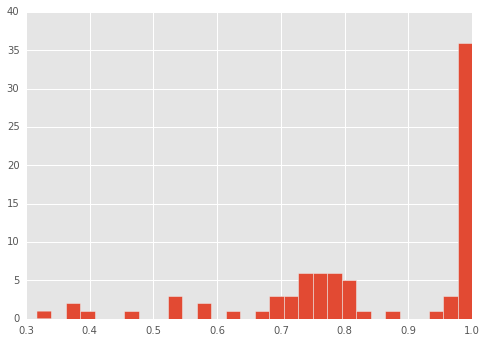

In [37]:
p0_collin_test_build.hist(bins=30)

In [38]:
high_colinear_cols = p0_collin_test_build[p0_collin_test_build==1.0].index.tolist()
[(col,build[col].sum()) for col in high_colinear_cols]

[('PARTFULL1', 1146),
 ('PTFTCNT1', 1146),
 ('EMPL_CLASS_1', 105332),
 ('EMPL_CLASS_D', 1583),
 ('EMPL_CLASS_3', 455),
 ('EMPL_CLASS_4', 40),
 ('EMPL_CLASS_5', 1),
 ('EMPL_CLASS_G', 1),
 ('EEO1CODE_5', 47253),
 ('EEO1CODE_2', 44136),
 ('EEO1CODE_1', 9272),
 ('EEO1CODE_4', 4090),
 ('EEO1CODE_7', 398),
 ('EEO1CODE_3', 1935),
 ('EEO1CODE_6', 321),
 ('EEO1CODE_8', 1),
 ('EEO1CODE_N', 3),
 ('EEO1CODE_L', 3),
 ('EMPL_TYPE_E', 68277),
 ('EMPL_TYPE_H', 11361),
 ('EMPL_TYPE_S', 26174),
 ('EMPL_TYPE_N', 1592),
 ('EMPL_TYPE_X', 8),
 ('FULL_PART_TIME_F', 97334),
 ('FULL_PART_TIME_P', 7544),
 ('FULL_PART_TIME_X', 1667),
 ('FULL_PART_TIME_N', 867),
 ('MERIT1_d', 0),
 ('PERF1_d', 0),
 ('ADDRCNT1_d', 0)]

In [39]:
e2build.FULL_PART_TIME.value_counts()

F    97334
P     7544
X     1667
N      867
Name: FULL_PART_TIME, dtype: int64

In [40]:
used_features = [c for c in all_features]
used_features.remove('ADDRCNT1_d')
used_features.remove('PERF1_d')
used_features.remove('MERIT1_d')
used_features.remove('PTFTCNT1')
#used_features.remove('EMPL_CLASS_1')
#used_features.remove('EMPL_TYPE_E')
#used_features.remove('EEO1CODE_5')
#used_features.remove('FULL_PART_TIME_F')



In [41]:
#br.perfect_collinearity_test(build[used_features])

In [42]:
tstmp_cols = [col for col in em2002.columns if col.endswith('tstmp')]

# Construct the time k-folds
### use the novel temporal kfolds
1. for the training set split into time-windows 
2. for the evaluation set reset the index and apply time-windows

In [43]:
# define the date range
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)

14


In [44]:
import itertools
def create_temporal_kfolds(dates_df,date_range,time_delta):
    """
    inputs: date_range
            time_delta (in years)
            dataframe_dates --> assumes 'hire_tstmp' and 'term_tstmp'
    outputs:
            kf is a list of list of list: 
            [indices from original df that are 'in' a fold, indices from original df that are 'out' of a fold]
            each row in this corresponds to the temporal-kfold
            filtered_pairs is a list of start and end times
    """
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no corresponding partner/endtime
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index.tolist()
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index.tolist()
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs

In [45]:
def reset_years2(paired_times,indices,dates_df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    # push these as a data frame so I can merge
    adj_times = pd.DataFrame()
    adj_times['adj_age']=reset_age
    adj_times['adj_tenure']=reset_tenure      
    return adj_times


In [46]:
def define_target_within_x_years(df,paired_dates,tfold,n_years,target_col):
    """
    inputs:
        df -- data frame
        paired_dates (2nd output from create_temporal_kfolds)
        tfold (1st output from create_temporal_kfolds)
        targe_col --> desired target
        
    plan is to adjust the target, Age and tenure to match time frame of temporal kfold
    outputs:
    """
    print len(tfold)#, paired_dates

    df_dict = {}
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        #print start_date,end_date,n_years
        #altered_fold_df = pd.DataFrame(columns=['fold_mbr','adj_age','adj_tenure','adj_term'])
        # if in the fold reset the age to start of fold; define new window of termination
        in_fold_idx = tfold[i][0] # the index of the in_fold_observations 
        # note that "sex" is just used to create a value that then gets dummied out
        cols_to_copy = ['SEX','Age_years','Tenure_years']
        cols_to_copy.append(target_col)
        
        altered_fold_df = df[cols_to_copy].copy()
        # adjust these
        altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_tgt']
        altered_fold_df.fold_mbr = 0
        
        #ra,rt = reset_years(paired_dates[i],in_fold_idx,dates_df)
        adj_df =reset_years2(paired_dates[i],in_fold_idx,df)
        #altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        #altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        altered_fold_df.loc[in_fold_idx,['adj_age','adj_tenure']]=adj_df.ix[in_fold_idx] # assign to the altered values
        new_tgt = (df.ix[in_fold_idx]['term_tstmp']<= end_date).as_matrix().astype(np.int)
        #(em2mod.ix[kf[0][0]]['term_tstmp']<= fp[0][1]).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_tgt = (df.ix[in_fold_idx]['term_tstmp']< end_date).as_matrix().astype(np.int)
        #print "\t", len(new_term),sum(new_term)
        altered_fold_df.loc[in_fold_idx,'adj_tgt']=new_tgt
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel

In [47]:
def setup_tfolds(df, n_years, cols_to_model, tgt_value='former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = tstmp_cols, date_range=full_date_range):
    """ Function to create the temporal kfolds
    parameters:
        df       - a pandas data frame (that has been preprocessed)
        n_years  - size of the temporal window (in years)
        cols_to_model - list of columns to use in the modeling procedure 
        tgt_value  - column name to use as the target variable
        time_cols  - list of columns that are time senitive and must be adjusted
        tstmp_cols - list of columns that contain timestamps for things like hiring, termination and birth
        date_range - list comprising the inclusive annual starting dates from beginning to end of range.
    output:
        tfolds  - a list containing the indices of in and out of fold members for each of the tfolds created
        tfold_panel - a pandas Panel (3D data frame) containing the membership in different folds, the adjusted targets,
            the adjusted timesenitive data, and the columns to use for modeling.
    """    
    # step 1 create the temporal_folds
    if not [a for a in tstmp_cols if a in df.columns] == tstmp_cols:
        print "The list of required timestamp columns do not exist in the input dataframe."
        print tstmp_cols
        exit
    tfolds, paired_dates = create_temporal_kfolds(df[tstmp_cols],date_range, n_years) 
    #defines the time-windows and assigns observations to folds
    
    # create the time-shifted tfolds and push into a pandas Panel (3D data frame)
    tfold_panel=transform_df_to_tfold(df,tfolds,paired_dates,n_years,cols_to_model, tgt_value,tstmp_cols,time_cols)
    return tfold_panel, tfolds
   

In [48]:
def transform_df_to_tfold(df,tfold,paired_dates,n_years,cols_to_keep,target_col,tstmp_cols,time_cols):
    """
    Function to adjust the input data frame so that time_sensitive columns and target column
    conform to the bounds of that temporal kfold (tfold). Specifically adjust the target, Age and tenure 
    to match time frame of temporal kfold
    
    Parameters:
        df -- a pandas data frame
        paired_dates (2nd output from create_temporal_kfolds)
        tfolds (1st output from create_temporal_kfolds)
        target_col --> desired target
        cols_to_keep --> the list of columns within df that get expressed in df.
        time_cols
        
    plan is to 
    outputs:
        tfold_panel
    """
    #print len(tfold)#, paired_dates
    #print df.columns ,len(df.columns), len(cols_to_keep)
    #return
    # do some sanity checks
    # 1. make sure cols_to_keep, target and tstmp_cols columns are in df.columns
    input_column_list = df.columns.tolist()
    n_total_columns = len(input_column_list)
    #if (n_total_columns != len(cols_to_keep)+len(target_col)+len(tstmp_cols)):
        # now look at each piece
    targetlist = []
    targetlist.append(target_col)
    if not check_if_subset(targetlist,input_column_list):
            #target_col in df.columns:
            #print "{0} target column not present in input set".format(target_col)
        return
    if not check_if_subset(tstmp_cols,input_column_list):
        return
            #[a for a in tstmp_cols if a in input_column_list] == tstmp_cols: # requires
            #print "There are missing timestamp columns. Recheck the list {0}".format(tstmp_cols)
    #        return
    if not check_if_subset(time_cols,input_column_list):
            #[a for a in time_cols if a in input_column_list] == time_cols: # requires
            #print "There are missing timestamp columns. Recheck the list {0}".format(tstmp_cols)
        return    
    if not check_if_subset(cols_to_keep,input_column_list):
        return
    
    ## now set up the columns for manipulation
    cols_to_copy = cols_to_keep
    if not check_if_subset(time_cols,cols_to_keep):
        cols_to_copy+=time_cols
        print len(cols_to_copy)
    
    
    df_dict = {}
    
    # identify which element of tstmp_cols corresponds to term_tstmp
    term_id = tstmp_cols.index('term_tstmp')
    birth_id = tstmp_cols.index('birth_tstmp')
    hire_id = tstmp_cols.index('hire_tstmp')
    #print term_id, tstmp_cols[term_id]
    
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        
        in_fold_idx = tfold[i][0] # the index of the in_fold_observations 
       
        altered_fold_df = df[cols_to_copy].copy()
        altered_fold_df['fold_mbr']=0 # create a new column to identify membership in that fold.
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1 # assign the in_fold_indices to that fold membership
        ####
        # adjust the age and tenure for those in the fold
        reset_age_tdelta = pd.to_datetime(start_date)-df.ix[in_fold_idx][tstmp_cols[birth_id]]
        reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
        reset_tenure_tdelta = pd.to_datetime(start_date)-df.ix[in_fold_idx][tstmp_cols[hire_id]]
        reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
        altered_fold_df.loc[in_fold_idx,'Age_years']=reset_age
        altered_fold_df.loc[in_fold_idx,'Tenure_years']=reset_tenure
        old_tgt = df.ix[tfold[i][1]][target_col]
        new_tgt = (df.ix[in_fold_idx][tstmp_cols[term_id]]<= end_date).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_tgt = (df.ix[in_fold_idx][tstmp_cols[term_id]]< end_date).as_matrix().astype(np.int)
            
        altered_fold_df.loc[in_fold_idx,target_col]=new_tgt
        old_tgt = df.ix[tfold[i][1]][target_col]
        altered_fold_df.loc[tfold[i][1],target_col] = old_tgt
        #ra,rt = reset_years(paired_dates[i],in_fold_idx,dates_df)
        """adj_df =reset_years2(paired_dates[i],in_fold_idx,df)
        #altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        #altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        altered_fold_df.loc[in_fold_idx,time_cols]=adj_df.ix[in_fold_idx] # assign to the altered values
        
        #(em2mod.ix[kf[0][0]]['term_tstmp']<= fp[0][1]).as_matrix().astype(np.int)
        
        #print "\t", len(new_term),sum(new_term)
        
        """
        
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel
    

def check_if_subset(list1,list2): #compare_column_lists(list1,list2):
    if set(list1).issubset(set(list2)):
        return 1
    else:
        print "{0} is not contained in {1}. Recheck your lists.".format(list1,list2)
        return 0
    

In [49]:
def apply_tKfold_CV2(modeltype, in_panel, tkfolds, cols_to_use, tgt_column = 'former', ntrees=100,njobs=-1):
    """ Calculate the rmse for each cross-validated temporalFold
    
    Parameters:
        model - a scikit learn model name
        in_panel  - a pandas Panel with the observed input data adjusted 
        tgt_column -- the target variable
        cols_to_use -- the input variables to be used in modeling
        tkfolds -- teh temporal timefolds (list of dimension 2)
    outputs:
        models --> the list of fit models
        RMSE --> the rmse error
        
    """
    RMSE = []
    roc_auc = []
    models = []
    
    
    
    for fold_id, indices in enumerate(tkfolds):
        training = indices[0]
        testing = indices[1]
        #print fold_id, len(training),len(testing)
        X_train, X_test = in_panel[fold_id][cols_to_use].ix[training].as_matrix(), in_panel[fold_id][cols_to_use].ix[testing].as_matrix()
        y_train, y_test = in_panel[fold_id][tgt_column].ix[training].as_matrix(), in_panel[fold_id][tgt_column].ix[testing].as_matrix()
        if modeltype == 'rfc':
            model = ensemble.RandomForestClassifier(n_estimators=ntrees, max_features='auto', oob_score=True,n_jobs=njobs)
        elif modeltype=='bgc':
            model=ensemble.GradientBoostingClassifier(n_estimators=ntrees,max_features='auto',learning_rate=0.01)
        else:
            model=tree.DecisionTreeClassifier()
            
        # Train the model
        model.fit(X_train,y_train)
        # use the model to predict output
        y_fitted = model.predict(X_test)
        RMSE.append(np.sqrt(metrics.mean_squared_error(y_test,y_fitted)))
        roc_auc.append(metrics.roc_auc_score(y_test,y_fitted))
        models.append(model)
    # leave the model fit to the entire dataset
    #model.fit(in_x,in_y)
    
    return RMSE,roc_auc,models
        

## Steps to apply the above protocol
1. reintroduced tstmp cols
2. generate the assignment to the Temporal Fold and collapse into a panel
    * setup_tfolds
3. build the model and calculate RMSE +  roc_auc
    * apply_tkfold_CV2
4. evaluate on the hold-out data.
    * evaluate_models
5. evaluate Separation rates for current employees

In [50]:
build[tstmp_cols]=e2build[tstmp_cols].apply(lambda x: pd.to_datetime(x))
evaluation[tstmp_cols]=e2eval[tstmp_cols].apply(lambda x:  pd.to_datetime(x))

In [51]:
window_size = [1,2,3,4,5]

In [53]:
len(used_features)

79

## Start with 5 year

In [54]:
panel5,tfold5 = setup_tfolds(build, 5, used_features,tgt_value='former',
                            time_cols=['Age_years','Tenure_years'])

13 5 8 107412
9
2002-01-01 2007-01-01 62496 44916
2003-01-01 2008-01-01 60610 46802
2004-01-01 2009-01-01 57414 49998
2005-01-01 2010-01-01 54497 52915
2006-01-01 2011-01-01 53158 54254
2007-01-01 2012-01-01 53049 54363
2008-01-01 2013-01-01 52556 54856
2009-01-01 2014-01-01 53167 54245
2010-01-01 2015-01-01 52555 54857


## Resume Survival Model (CoxPH with reduced set of features)

In [33]:
rset1 = ['SAL1','HAVE_INS','MERIT1','PERF1','MIN_RT_ANNUAL','INTERN','BOX1','HAVE_DEP','Age_years','DEPENDENT_CNT','DIRECT_RPT_CNT','Tenure_years','former']

In [34]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation, concordance_index

In [58]:
%%time 
cf = CoxPHFitter()
scores = k_fold_cross_validation(cf,e2build[rset1],'Tenure_years','former')

/san-data/personal/kesj/envs/cutting/lib/python2.7/site-packages/lifelines/utils/__init__.py:466: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.reindex(np.random.permutation(df.index)).sort(event_col)
/san-data/personal/kesj/envs/cutting/lib/python2.7/site-packages/lifelines/utils/__init__.py:471: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  testing_columns = df.columns - [duration_col, event_col]
/san-data/personal/kesj/envs/cutting/lib/python2.7/site-packages/lifelines/fitters/coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


CPU times: user 6min 23s, sys: 3min 33s, total: 9min 57s
Wall time: 6min 11s


### work on evaluation

In [61]:
print scores
print np.mean(scores), np.std(scores)

[0.8952293648588493, 0.89546559255822478, 0.89579576465591648, 0.89585830153549262, 0.89664690462648389]
0.895799185647 0.000481272051779


In [60]:
cf.print_summary()

n=85930, number of events=31747

                     coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
SAL1           -4.650e-01  6.282e-01 1.433e-02 -3.246e+01 4.576e-231  -4.930e-01  -4.369e-01  ***
HAVE_INS       -3.366e-01  7.142e-01 8.750e-03 -3.847e+01  0.000e+00  -3.537e-01  -3.194e-01  ***
MERIT1          1.327e-01  1.142e+00 1.063e-02  1.249e+01  8.522e-36   1.119e-01   1.535e-01  ***
PERF1          -1.140e+00  3.199e-01 1.939e-02 -5.876e+01  0.000e+00  -1.178e+00  -1.102e+00  ***
MIN_RT_ANNUAL  -2.869e-01  7.506e-01 1.235e-02 -2.323e+01 2.470e-119  -3.111e-01  -2.627e-01  ***
INTERN         -1.181e-01  8.886e-01 5.304e-03 -2.226e+01 8.379e-110  -1.285e-01  -1.077e-01  ***
BOX1           -1.569e-01  8.548e-01 7.903e-03 -1.985e+01  1.143e-87  -1.724e-01  -1.414e-01  ***
HAVE_DEP       -2.584e-01  7.723e-01 1.632e-02 -1.584e+01  1.755e-56  -2.904e-01  -2.264e-01  ***
Age_years      -1.191e+00  3.038e-01 1.087e-02 -1.096e+02  0.000e+00  -1.213e+00  -1.

In [62]:
cf.hazards_.T

,coef
SAL1,-0.464952
HAVE_INS,-0.336591
MERIT1,0.132713
PERF1,-1.139677
MIN_RT_ANNUAL,-0.286880
INTERN,-0.118080
BOX1,-0.156858
HAVE_DEP,-0.258388
Age_years,-1.191396
DEPENDENT_CNT,0.086515


#### From this I can predict the expcted Separation Age for the hold out Set
* e2eval

In [68]:
eval_SepTenure = cf.predict_expectation(e2eval[rset1])
#eval_SepTenure.columns = 'predTenure'

In [74]:
eval_SepTenure.rename(columns= {0: 'predTenure'},inplace=True)

In [75]:
eval_SepTenure.head()

,predTenure
76295,54.563086
10434,7.809871
50850,2.293870
105570,52.444801
49133,3.111277


In [76]:
eval_SepTenure['Tenure']=e2eval['Tenure_years']
eval_SepTenure['separated']=e2eval['former']
eval_SepTenure.head()

,predTenure,Tenure,separated
76295,54.563086,16.681725,0
10434,7.809871,5.722108,1
50850,2.293870,8.268309,1
105570,52.444801,28.027379,0
49133,3.111277,1.305955,1


In [77]:
eval_SepTenure.groupby('separated')['predTenure'].mean()

separated
0    39.880563
1    11.125535
Name: predTenure, dtype: float64

In [79]:
eval_SepTenure.groupby('separated')['predTenure'].max()

separated
0    61.579740
1    61.558616
Name: predTenure, dtype: float64

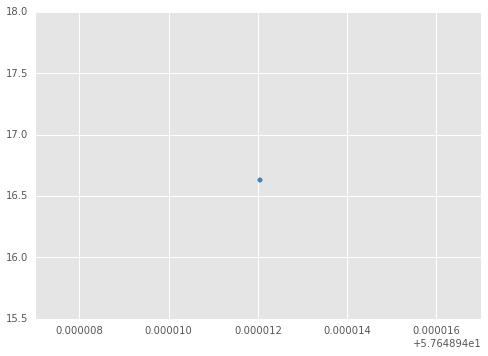

In [106]:
plt.figure()
cmatrix = ['steelblue','indianred']
#with pd.plot_params.use('x_compat', True):
#eval_SepTenure[eval_SepTenure.separated==0]
for idx in xrange(0,int(len(eval_SepTenure))):
    #print idx
    x,y,z = eval_SepTenure.iloc[idx].values.tolist()
    z = int(z)
    plt.scatter(x,y,color=cmatrix[z])
#eval_SepTenure[eval_SepTenure.separated==1].plot(secondary_y=True,kind='scatter',x='Tenure',y='predTenure',color='indianred')
    

In [100]:
eval_SepTenure.iloc[0].values.tolist()

[54.56308605166654, 16.681724845999998, 0.0]

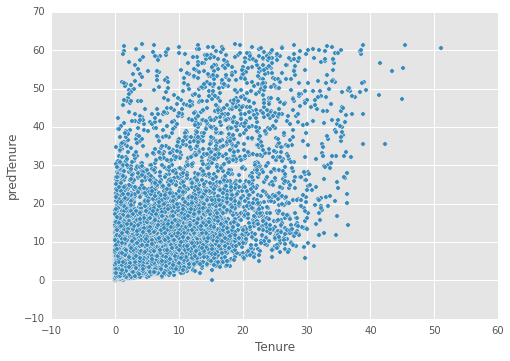

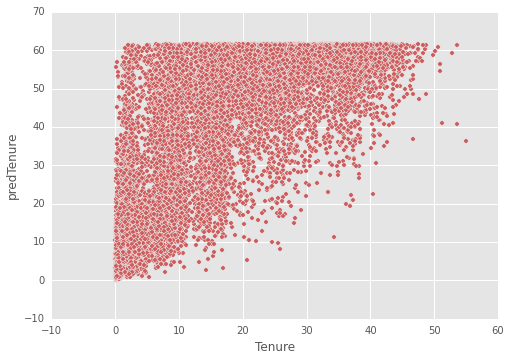

In [107]:
#from pandas.tools.plotting import radviz

plt.figure()
eval_SepTenure[eval_SepTenure.separated==1].plot(kind='scatter',x='Tenure',y='predTenure')
eval_SepTenure[eval_SepTenure.separated==0].plot(kind='scatter',x='Tenure',y='predTenure',color='indianred')
#radviz(eval_SepTenure[['Tenure','predTenure','separated']], 'separated')

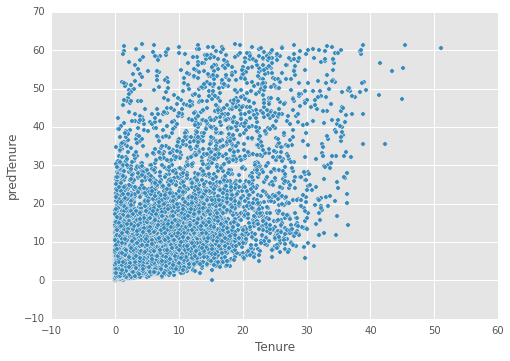

In [81]:
eval_SepTenure[eval_SepTenure.separated==1].plot(kind='scatter',x='Tenure',y='predTenure')

## Loading in the previous model (RF)

In [108]:
base_model_dir = '/home/hrsepara/work/model'

In [109]:
os.chdir(base_model_dir)
%ls

ret/  retirement_sfA.pkl*  sep/


In [110]:
## load some of the app functions

# define a function to apply a set of models to a given prediction
## now apply each model to my eval set
def evaluate_models(model_list,X,mode='mean',offset=0):
    """ Function to apply a set of models to a given input and generate the predicted value(s)
    :param model_list --> input list of models
    :param X --> input array to apply models to
    :param mode --> what sort of output to return; default is mean
    intermediates
        eval_pred_class --> array of classification prediction for each model
        eval_pred_proba --> array of predicted probabilities for each model
    """
    import numpy as np
    eval_pred_class = np.zeros((len(X),len(model_list)))
    eval_pred_proba = np.zeros((len(X),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(X)
        eval_pred_class[:,i]=mdl.predict(X)
        eval_pred_proba[:,:,i]=eval_proba
    if mode == 'mean':
        # average the probabilities (for class=1) and return the mean predicted probability
        prediction = np.mean(eval_pred_proba[:,1,:],axis=1)
        #eval_pred_proba[:,1,:].mean(axis=2)

    elif mode == 'class': # return the desired class prediction
        prediction = map(np.int,eval_pred_class.mean(axis=1))
    return prediction

# define the application of a series of time-based model%loa
def apply_time_models(X,MODEL_BASE_PATH,pcase,pred_years):
    proba_df = []


    import joblib as jl
    import pandas as pd

    for idx,pyr in enumerate(pred_years):
        pkl_name ='rf'+pyr+'.pkl'#5.pkl'
        if pcase == 'ret/':
            pkl_name = 'R'+pkl_name

        path_name =MODEL_BASE_PATH+pcase+pyr+'/'
        print path_name, pkl_name

        # load a model, evaluate it and return the 'average' probability for each person
        #abs_mdl_name = os.path.abspath(path_name+pkl_name)
        mdl_name = path_name+pkl_name
        stored_mdl = jl.load(mdl_name)
        stored_prediction = evaluate_models(stored_mdl,X)#stored_pred,stored_pred_proba = evaluate_models(stored_mdl,X)

        df = pd.DataFrame(stored_prediction.T)
        df.columns=[pcase[:-1]+pyr+'yr']

        proba_df.append(df)

    pred_df = pd.concat([a for a in proba_df], axis=1)
    return pred_df

# define the parser_dict

def calculate_years(timestamp1,timestamp2,days_in_year =365.25):
    number_of_years = (timestamp2 - timestamp1).days/days_in_year
    return number_of_years


In [111]:
app_columns_for_modeling = ['Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']

In [114]:
base_model_dir+='/'

In [115]:
sep_proba_df = apply_time_models(e2eval[app_columns_for_modeling],base_model_dir,'sep/',map(np.str, np.arange(1,6)))

/home/hrsepara/work/model/sep/1/ rf1.pkl
/home/hrsepara/work/model/sep/2/ rf2.pkl
/home/hrsepara/work/model/sep/3/ rf3.pkl
/home/hrsepara/work/model/sep/4/ rf4.pkl
/home/hrsepara/work/model/sep/5/ rf5.pkl


In [119]:
sep_proba_df.head()

,sep1yr,sep2yr,sep3yr,sep4yr,sep5yr
0,0.152308,0.258333,0.374545,0.479,0.568889
1,0.216154,0.373333,0.510000,0.638,0.774444
2,0.347692,0.581667,0.746364,0.870,0.910000
3,0.058462,0.128333,0.180909,0.254,0.325556
4,0.300000,0.515833,0.644545,0.724,0.784444


In [120]:
e2eval[['Tenure_years','former']].head()

,Tenure_years,former
76295,16.681725,0
10434,5.722108,1
50850,8.268309,1
105570,28.027379,0
49133,1.305955,1


## Look at current employees specifically

In [122]:
current = em2002[em2002.status ==0].copy()
print len(current)

69475


In [462]:
current_index = current.index.tolist()

In [251]:
## Apply current and all to the RF model
all_rf_sep_df = apply_time_models(em2002[app_columns_for_modeling],base_model_dir,'sep/',map(np.str, np.arange(1,6)))

/home/hrsepara/work/model/sep/1/ rf1.pkl
/home/hrsepara/work/model/sep/2/ rf2.pkl
/home/hrsepara/work/model/sep/3/ rf3.pkl
/home/hrsepara/work/model/sep/4/ rf4.pkl
/home/hrsepara/work/model/sep/5/ rf5.pkl


## probe some of the jobs of interest

* The extended Functions (EXT_FUNC_ID_SFI) Jeff Briks is interested in are:
    * CCC Sales (00892)
    * CCC Service (00071)
    * Life Health Response Center (00816)
    * Enterprise Auto Express (00909)
    * Enterprise ILR (00910)
    * State Farm Bank (00517)
    * SFPP (00835)
* The jobs (JOBCODES) he is interested in are these:
    * CCC Service Rep (6200)
    * CCC Sales Rep (1876)
    * Life Customer Service Asst (2638, 2639, & 2641)
    * Claim Associate-Express (0983 & 0984)
    * Claim Associate-ILR (1009)
    * Claim Team Manager – ILR (0986)
    * Bank Customer Service Rep (0851, 852, & 0853)
    * SFPP Account Rep (4105)

I need to make sure that I keep these columns around


In [123]:
#interesting_extended_functions = [892,71, 816, 909,910,517,835]
extFuncDict ={}
extFuncDict[892]='CCC Sales'
extFuncDict[71]='CCC Service'
extFuncDict[816]='Life Health Response Center'
#(00816)
extFuncDict[909]='Enterprise Auto Express'
extFuncDict[910]='Enterprise ILR' 
extFuncDict[517]='State Farm Bank'
extFuncDict[835]='SFPP'
interesting_extended_functions = extFuncDict.keys()
extFuncDict

{71: 'CCC Service',
 517: 'State Farm Bank',
 816: 'Life Health Response Center',
 835: 'SFPP',
 892: 'CCC Sales',
 909: 'Enterprise Auto Express',
 910: 'Enterprise ILR'}

## how many of these are in current?

In [253]:
len(current[current['EXT_FUNC_ID_SFI']==k].index), len(em2002[(em2002['EXT_FUNC_ID_SFI']==k) &  (em2002['status']==0)].index)

(1636, 1636)

In [255]:
all_rf_sep_df.ix[em2002[(em2002['EXT_FUNC_ID_SFI']==71) &  (em2002['status']==0)].index]

,sep1yr,sep2yr,sep3yr,sep4yr,sep5yr
128280,0.001538,0.025000,0.037273,0.068,0.095556
128281,0.127692,0.267500,0.483636,0.638,0.704444
128282,0.030769,0.070000,0.122727,0.167,0.180000
128283,0.029231,0.054167,0.054545,0.084,0.092222
128284,0.006154,0.008333,0.016364,0.027,0.021111
128285,0.160769,0.252500,0.328182,0.476,0.601111
128286,0.291538,0.423333,0.534545,0.586,0.617778
128287,0.168462,0.250000,0.347273,0.388,0.455556
128288,0.475385,0.753333,0.850909,0.914,0.941111
128289,0.166154,0.196667,0.218182,0.244,0.284444


In [303]:
clist = ['function','current_count','all_count']
seplist = ['sep1yr','sep2yr','sep3yr','sep4yr','sep5yr']
for a in seplist:
    clist.append('c_'+a+'_gen')
for a in seplist:
    clist.append('c_'+a+'_0.5')
print len(clist), clist

           
extFunc_summary_df = pd.DataFrame(np.zeros((len(extFuncDict.keys()),len(clist))),columns = clist)
print "function\t     current \tall"
print "------------------------------------"
c1 = pd.DataFrame()#data=np.zeros((len(extFuncDict.keys()),5)))
c2 = pd.DataFrame()#data=np.zeros((len(extFuncDict.keys()),5)))
i=0
print len(extFunc_summary_df)
for k,v in extFuncDict.items():
    c_gp_idx = em2002[(em2002['EXT_FUNC_ID_SFI']==k) &  (em2002['status']==0)].index
    #current[current['EXT_FUNC_ID_SFI']==k].index
    a_gp_idx = em2002[em2002['EXT_FUNC_ID_SFI']==k].index
    #print v,' \t',sum(c_gp),'\t',sum(a_gp)
    my_data = [v,len(c_gp_idx),len(a_gp_idx)]
    #print my_data
    #ndf = pd.DataFrame(data=np.zeros((1,3)),columns=clist)
    #ndf.iloc[0] = my_data
    #df.loc[len(df)+1]
    #[clist[0]]=v
    #ndf[clist[1]]=my_data[1]
    #ndf[clist[2]]=my_data[2]
    #print ndf
    cdf = all_rf_sep_df.ix[c_gp_idx]
    #adf = all_rf_sep_df.ix[a_gp_idx]
    # calculate the 'generic pred'
    c1= return_generic_sum(cdf)
    for v in c1.values.tolist()[0]:
        my_data.append(np.int(v))
    
    c2=return_thresh_sum(cdf)
    #print c1
    for v in c2.values.tolist()[0]:
        my_data.append(np.int(v))
        
    #my_data.append([np.int(v) for v in c1.values.tolist()[0]])
    #my_data.append([np.int(v) for v in c2.values.tolist()[0]])
    
    
    extFunc_summary_df.loc[i] = my_data#ndf#.append(ndf,ignore_index=True)
    #d2 = pd.concat([extFunc_summary_df,c1,c2],axis=1)
    #print d2
    #print extFunc_summary_df
    i+=1
    

#extFunc_summary_df.rename(columns={0:'function',1:'current_count',2:'all_count'},inplace=True)
extFunc_summary_df

13 ['function', 'current_count', 'all_count', 'c_sep1yr_gen', 'c_sep2yr_gen', 'c_sep3yr_gen', 'c_sep4yr_gen', 'c_sep5yr_gen', 'c_sep1yr_0.5', 'c_sep2yr_0.5', 'c_sep3yr_0.5', 'c_sep4yr_0.5', 'c_sep5yr_0.5']
function	     current 	all
------------------------------------
7


,function,current_count,all_count,c_sep1yr_gen,c_sep2yr_gen,c_sep3yr_gen,c_sep4yr_gen,c_sep5yr_gen,c_sep1yr_0.5,c_sep2yr_0.5,c_sep3yr_0.5,c_sep4yr_0.5,c_sep5yr_0.5
0,SFPP,783,1991,134,208,253,291,330,8,58,105,155,234
1,State Farm Bank,1507,2936,129,215,283,339,390,9,52,95,150,208
2,CCC Service,1823,6536,484,698,818,908,997,162,375,483,600,681
3,Enterprise Auto Express,2587,3193,362,573,705,829,942,12,156,269,355,452
4,Enterprise ILR,2462,3278,672,922,1067,1189,1300,253,555,685,797,927
5,Life Health Response Center,376,1045,63,96,120,139,157,17,39,58,76,99
6,CCC Sales,1636,3364,381,539,630,699,780,115,238,313,373,433


In [337]:
em2002.EXT_FUNC_ID_SFI.nunique()#value_counts()

338

In [332]:
extFunc_summary_df

,function,current_count,all_count,c_sep1yr_gen,c_sep2yr_gen,c_sep3yr_gen,c_sep4yr_gen,c_sep5yr_gen,c_sep1yr_0.5,c_sep2yr_0.5,c_sep3yr_0.5,c_sep4yr_0.5,c_sep5yr_0.5
0,SFPP,783,1991,134,208,253,291,330,8,58,105,155,234
1,State Farm Bank,1507,2936,129,215,283,339,390,9,52,95,150,208
2,CCC Service,1823,6536,484,698,818,908,997,162,375,483,600,681
3,Enterprise Auto Express,2587,3193,362,573,705,829,942,12,156,269,355,452
4,Enterprise ILR,2462,3278,672,922,1067,1189,1300,253,555,685,797,927
5,Life Health Response Center,376,1045,63,96,120,139,157,17,39,58,76,99
6,CCC Sales,1636,3364,381,539,630,699,780,115,238,313,373,433


In [319]:
(extFunc_summary_df.loc[0,extFunc_summary_df.columns[3:8]]/extFunc_summary_df.loc[0,'current_count'])#.plot(marker='d')
#(extFunc_summary_df.loc[1,extFunc_summary_df.columns[3:8]]/extFunc_summary_df.loc[1,'current_count']).plot(marker='d')

c_sep1yr_gen    0.171137
c_sep2yr_gen    0.265645
c_sep3yr_gen    0.323116
c_sep4yr_gen    0.371648
c_sep5yr_gen    0.421456
Name: 0, dtype: object

In [320]:
(extFunc_summary_df.loc[1,extFunc_summary_df.columns[3:8]]/extFunc_summary_df.loc[1,'current_count'])#.plot(marker='d')
#(extFunc_summary_df.loc[1,extFunc_summary_df.columns[3:8]]/extFunc_summary_df.loc[1,'current_count']).plot(marker='d')

c_sep1yr_gen    0.0856005
c_sep2yr_gen     0.142668
c_sep3yr_gen      0.18779
c_sep4yr_gen      0.22495
c_sep5yr_gen     0.258792
Name: 1, dtype: object

In [275]:
def return_generic_sum(df,sname='curr'):
    ndf = pd.DataFrame(df.sum()).T
    old_col = ndf.columns
    new_col = [sname[0]+'_'+a+'_gen' for a in old_col]
    ndf.columns = new_col
    return(ndf)

def return_thresh_sum(df,thresh_value=0.5,sname='curr'):
    col_list = df.columns.tolist()
    yr_counts = [df[df[a]>=thresh_value][a].sum() for a in col_list]
    ndf = pd.DataFrame(data=yr_counts).T
    new_col = [sname[0]+'_'+a+'_'+str(thresh_value) for a in col_list]
    ndf.columns = new_col
    return(ndf)

In [276]:
return_thresh_sum(df1)

,c_sep1yr_0.5,c_sep2yr_0.5,c_sep3yr_0.5,c_sep4yr_0.5,c_sep5yr_0.5
0,115.803077,238.425,313.559091,373.744,433.928889


In [247]:
## define calculations from stored model
def generalavg(df):
    ndf = pd.DataFrame(df.sum()/float(len(df))).T
    old_col = ndf.columns
    new_col = [a+'_gen' for a in old_col]
    ndf.columns = new_col
    return(ndf)

def thresh_avg(df,thresh_value=0.5):
    col_list = df.columns.tolist()
    my_dict ={}
    for col in col_list:
        aval = sum(df[col]>=thresh_value)/float(len(df))
        my_dict[col]=aval
        
    print my_dict
    ndf = pd.DataFrame(data = my_dict.items(),columns=['idx','pred'])#.sort(inplace=True)#,columns=my_dict.keys())
    ndf['idx'] =ndf['idx'].apply(lambda x: x+'_'+str(thresh_value))
    ndf= ndf.sort_values('idx')
    b = pd.DataFrame(data=ndf.loc[:,'pred'].tolist())
    b=b.T
    b.columns = ndf.loc[:,'idx'].tolist()

    return b
    #ndf = pd.DataFrame(data=my_dict)

In [134]:
#current[c_gp][app_columns_for_modeling]
df1 = apply_time_models(current[c_gp][app_columns_for_modeling],base_model_dir,'sep/',map(np.str, np.arange(1,6)))

/home/hrsepara/work/model/sep/1/ rf1.pkl
/home/hrsepara/work/model/sep/2/ rf2.pkl
/home/hrsepara/work/model/sep/3/ rf3.pkl
/home/hrsepara/work/model/sep/4/ rf4.pkl
/home/hrsepara/work/model/sep/5/ rf5.pkl


In [137]:
df1.sum()/float(len(df1))

sep1yr    0.233450
sep2yr    0.329656
sep3yr    0.385108
sep4yr    0.427551
sep5yr    0.476860
dtype: float64

In [259]:
print df1.sum()
[df1[df1[a]>=0.5][a].sum() for a in df1.columns.tolist()]
#[df1>0.5].sum()

sep1yr    381.923846
sep2yr    539.317500
sep3yr    630.036364
sep4yr    699.473000
sep5yr    780.142222
dtype: float64


[115.8030769230769,
 238.42499999999993,
 313.5590909090911,
 373.74399999999963,
 433.9288888888893]

In [232]:
aa = generalavg(df1)
aa

,sep1yr_gen,sep2yr_gen,sep3yr_gen,sep4yr_gen,sep5yr_gen
0,0.23345,0.329656,0.385108,0.427551,0.47686


In [248]:
a = thresh_avg(df1)
a

{'sep3yr': 0.24449877750611246, 'sep5yr': 0.32701711491442542, 'sep2yr': 0.2011002444987775, 'sep1yr': 0.1167481662591687, 'sep4yr': 0.2823960880195599}


,sep1yr_0.5,sep2yr_0.5,sep3yr_0.5,sep4yr_0.5,sep5yr_0.5
0,0.116748,0.2011,0.244499,0.282396,0.327017


In [262]:
115.8/float(len(df1))

0.07078239608801956

In [266]:
df1[df1['sep4yr']>=0.5].sum()

sep1yr    201.631538
sep2yr    290.405833
sep3yr    340.907273
sep4yr    373.744000
sep5yr    394.245556
dtype: float64

# use a Survival Model (COXP)

In [322]:
reduced_cols = ['SAL1','HAVE_INS','MERIT1','PERF1','MIN_RT_ANNUAL','INTERN','BOX1','HAVE_DEP','Age_years','DEPENDENT_CNT','DIRECT_RPT_CNT','Tenure_years','former']

In [323]:
%%time 
cfsep = CoxPHFitter()
scores = k_fold_cross_validation(cfsep,e2build[reduced_cols],'Tenure_years','former')

CPU times: user 6min 3s, sys: 4min 12s, total: 10min 16s
Wall time: 6min 5s


In [324]:
print scores
print np.mean(scores),np.std(scores)

[0.8953756045180381, 0.89458414793232721, 0.89712053613366149, 0.89627047667631299, 0.89531518224200624]
0.8957331895 0.000875933993297


In [325]:
cfsep.print_summary()

n=85930, number of events=31747

                     coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
SAL1           -4.745e-01  6.222e-01 1.440e-02 -3.296e+01 3.351e-238  -5.027e-01  -4.463e-01  ***
HAVE_INS       -3.406e-01  7.113e-01 8.808e-03 -3.867e+01  0.000e+00  -3.579e-01  -3.233e-01  ***
MERIT1          1.280e-01  1.137e+00 1.088e-02  1.177e+01  5.442e-32   1.067e-01   1.493e-01  ***
PERF1          -1.117e+00  3.272e-01 1.921e-02 -5.816e+01  0.000e+00  -1.155e+00  -1.079e+00  ***
MIN_RT_ANNUAL  -2.773e-01  7.579e-01 1.242e-02 -2.232e+01 2.436e-110  -3.016e-01  -2.529e-01  ***
INTERN         -1.150e-01  8.913e-01 5.304e-03 -2.169e+01 2.648e-104  -1.254e-01  -1.046e-01  ***
BOX1           -1.611e-01  8.512e-01 7.904e-03 -2.039e+01  2.163e-92  -1.766e-01  -1.456e-01  ***
HAVE_DEP       -2.530e-01  7.764e-01 1.581e-02 -1.600e+01  1.253e-57  -2.840e-01  -2.220e-01  ***
Age_years      -1.195e+00  3.027e-01 1.086e-02 -1.101e+02  0.000e+00  -1.216e+00  -1.

In [326]:
cfsep.hazards_.T

,coef
SAL1,-0.474490
HAVE_INS,-0.340608
MERIT1,0.128027
PERF1,-1.117040
MIN_RT_ANNUAL,-0.277263
INTERN,-0.115037
BOX1,-0.161142
HAVE_DEP,-0.253031
Age_years,-1.195169
DEPENDENT_CNT,0.081413


In [327]:
all_sf_pred = cf.predict_survival_function_survival_function(em2002[reduced_cols[:-2]])

In [ ]:
surv_tpoints = [1.0,2.0,3.0,4.0,5.0]

#cf.predict_survival_function(
import scipy.interpolate
def get_survival_prob(edf,psf):
    for yr,yr_val in enumerate(surv_tpoints):
        prior_idx = np.where(psf.years<age+1.0)
        posterior_idx = np.where(psf.years>age+1.0)
        x= [psf.ix[prior_idx]['years'], psf.ix[posterior_idx]['years']]
        y= [psf.ix[prior_idx][employee_id],psf.ix[posterior_idx][employee_id]]
        print x,y, employee_id, age
    ## now interpolate these
        y_interp = scipy.interpolateinterp1d(x,y)
        print y_interp
    return y_interp

In [328]:
extFuncDict

{71: 'CCC Service',
 517: 'State Farm Bank',
 816: 'Life Health Response Center',
 835: 'SFPP',
 892: 'CCC Sales',
 909: 'Enterprise Auto Express',
 910: 'Enterprise ILR'}

# January 7, 2016
* I want to gather base-line information about the numbers for 'true' separation

In [383]:
## construct a dataframe to capture the workforces
annual_range = pd.date_range(full_date_range[0],full_date_range[-1],freq='AS')
#print annual_range
nactive=[]
nsep = []
nhired = []
nretired = []
nret_eligible = []

prev_tstmp = annual_range[0]-1
prev_date = str(prev_tstmp).split()[0]
#nsep.append(0.0)
for idx, my_tstmp in enumerate(annual_range):
    #print my_tstmp,
    my_date =     str(my_tstmp).split()[0]
    
    nactive.append( len(em2002[(em2002.hire_tstmp < my_date) &(em2002.term_tstmp > my_date)]))
    if idx == 0:
        nsep.append(len(em2002[(em2002.term_tstmp <= my_date) & (em2002.hire_tstmp < my_date)]))
        nhired.append( len(em2002[(em2002.hire_tstmp <= my_date) &(em2002.hire_tstmp > prev_date)]))
        nretired.append(em2002.ix[em2002[(em2002.term_tstmp <=my_date) & (em2002.term_tstmp > prev_date)].index].retired.sum())
        
    else:
        prev_date2 = str(annual_range[idx-1]).split()[0]
        nsep.append(len(em2002[(em2002.term_tstmp <= my_date) & (em2002.hire_tstmp < my_date) &( em2002.term_tstmp > prev_date2)]))
        nhired.append( len(em2002[(em2002.hire_tstmp <= my_date) &(em2002.hire_tstmp > prev_date2)]))
        nretired.append(em2002.ix[em2002[(em2002.term_tstmp <=my_date) & (em2002.term_tstmp > prev_date2)].index].retired.sum())

In [384]:
len(nretired), len(nhired)
nretired

[0, 646, 1159, 1940, 1501, 1376, 685, 694, 579, 917, 1211, 1377, 1571, 1461]

In [386]:
workforce = pd.DataFrame(data = nactive, index=annual_range,columns=['Active'])
delta = workforce.diff()
workforce['netChange'] = delta
workforce['Attrition'] = nsep
workforce['Hires'] = nhired
workforce['Retired']=nretired
workforce['Separation']=workforce['Attrition']-workforce['Retired']
workforce.head()
                         

,Active,netChange,Attrition,Hires,Retired,Separation
2002-01-01,78155,NaN,11,5755,0,11
2003-01-01,75763,-2392,5757,3363,646,5111
2004-01-01,71735,-4028,6074,2044,1159,4915
2005-01-01,68058,-3677,6843,3198,1940,4903
2006-01-01,66384,-1674,6534,4833,1501,5033


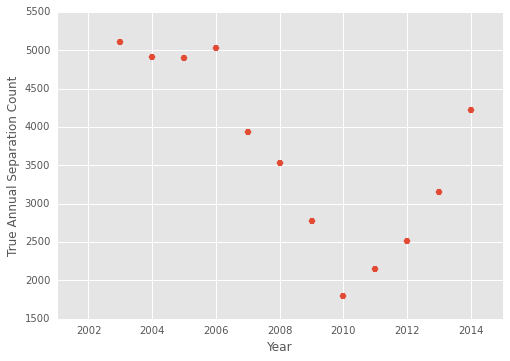

In [451]:
workforce.ix['2003':'2014']['Separation'].plot(marker='H',lw=0)
plt.xlabel('Year')
plt.xlim(['2001','2015'])
plt.ylabel('True Annual Separation Count')

In [441]:
# refactor as a function
def create_workforce_counts(emdf,my_date_range,my_freq='AS'):
    ## construct a dataframe to capture the workforces
    annual_range = pd.date_range(my_date_range[0],my_date_range[-1],freq=my_freq)
    nactive=[]
    nsep = []
    nhired = []
    nretired = []
    nret_eligible = []
    # try using retire eligible as >=55 and tenure >=5 (just use at tend of year)

    prev_tstmp = annual_range[0]-1
    prev_date = str(prev_tstmp).split()[0]

    for idx, my_tstmp in enumerate(annual_range):
        my_date =     str(my_tstmp).split()[0]
        nactive.append( len(emdf[(emdf.hire_tstmp < my_date) &(emdf.term_tstmp > my_date)]))
        if idx == 0:
            nsep.append(len(emdf[(emdf.term_tstmp <= my_date) & (emdf.hire_tstmp < my_date)]))
            nhired.append( len(emdf[(emdf.hire_tstmp <= my_date) &(emdf.hire_tstmp > prev_date)]))
            nretired.append(emdf.ix[emdf[(emdf.term_tstmp <=my_date) & (emdf.term_tstmp > prev_date)].index].retired.sum())
        else:
            prev_date2 = str(annual_range[idx-1]).split()[0]
            nsep.append(len(emdf[(emdf.term_tstmp <= my_date) & (emdf.hire_tstmp < my_date) &( emdf.term_tstmp > prev_date2)]))
            nhired.append( len(emdf[(emdf.hire_tstmp <= my_date) &(emdf.hire_tstmp > prev_date2)]))
            nretired.append(emdf.ix[emdf[(emdf.term_tstmp <=my_date) & (emdf.term_tstmp > prev_date2)].index].retired.sum())
            
    workforce =  pd.DataFrame(data = nactive, index=annual_range,columns=['Active'])
    delta = workforce.diff()
    workforce['netChange'] = delta
    workforce['Attrition'] = nsep
    workforce['Hires'] = nhired
    workforce['Retired']=nretired
    workforce['Separation']=workforce['Attrition']-workforce['Retired']

    return workforce

In [396]:
len(em2002[(em2002.hire_tstmp<'2002-01-01') &  (em2002.term_tstmp > '2002-01-01')])

78155

In [398]:
em2002[em2002.hire_tstmp > '2002-01-01']['hire_tstmp'].head()

291    2002-01-21
483    2002-03-04
515    2002-02-11
620    2002-02-18
621    2002-04-15
Name: hire_tstmp, dtype: object

In [403]:

def calculate_years(timestamp1,timestamp2,days_in_year =365.25):
    number_of_years = (timestamp2 - timestamp1).days/days_in_year
    return number_of_years


In [404]:
print (annual_range[0] - pd.to_datetime(em2002['hire_tstmp'].ix[3]))
calculate_years(annual_range[0],pd.to_datetime(em2002['hire_tstmp'].ix[3]))

13840 days 00:00:00


-37.89185489390828

In [405]:
emTemp = em2002[(em2002.hire_tstmp<'2003-01-01') &  (em2002.term_tstmp > '2003-01-01')].copy()
yr_start = annual_range[1]
yr_start

Timestamp('2003-01-01 00:00:00', offset='AS-JAN')

In [412]:
for empidx in emTemp.ix[:3].index:
    age = calculate_years(pd.to_datetime(emTemp.ix[empidx].birth_tstmp),yr_start)
    tenure = calculate_years(pd.to_datetime(emTemp.ix[empidx].hire_tstmp),yr_start)
    print age, tenure

79.3894592745 28.5804243669
77.6673511294 26.4887063655
77.6563997262 28.6570841889
86.1957563313 38.8911704312


In [413]:
emTemp.ix[:3][['Tenure_years','Age_years']]

,Tenure_years,Age_years
0,40.580424,91.389459
1,38.488706,89.667351
2,40.657084,89.656400
3,50.891170,98.195756


In [417]:
em2002[['status','retired','former','birth_tstmp','hire_tstmp','term_tstmp']]

,status,retired,former,birth_tstmp,hire_tstmp,term_tstmp
0,1,1,0,1923-08-12,1974-06-03,2015-01-01
1,1,1,0,1925-05-02,1976-07-06,2015-01-01
2,1,1,0,1925-05-06,1974-05-06,2015-01-01
3,1,1,0,1916-10-21,1964-02-10,2015-01-01
4,1,1,0,1925-05-03,1949-11-16,2015-01-01
5,1,1,0,1920-09-12,1960-06-11,2015-01-01
6,1,1,0,1935-12-03,1956-06-19,2015-01-01
7,1,1,0,1928-04-20,1985-10-12,2015-01-01
8,1,1,0,1939-05-19,1967-07-03,2015-01-01
9,1,1,0,1934-03-13,1959-12-22,2015-01-01


# how many have notice of retired but term_tstmp is 2015-01-01?

In [419]:
print len(em2002[em2002.retired==1])

15117


In [421]:
sum(em2002[em2002.retired==1]['term_tstmp']=='2015-01-01')

67

In [422]:
em2002[(em2002.retired==1) & (em2002['term_tstmp']=='2015-01-01')][['birth_tstmp','status','hire_tstmp','Age_years']]

,birth_tstmp,status,hire_tstmp,Age_years
0,1923-08-12,1,1974-06-03,91.389459
1,1925-05-02,1,1976-07-06,89.667351
2,1925-05-06,1,1974-05-06,89.656400
3,1916-10-21,1,1964-02-10,98.195756
4,1925-05-03,1,1949-11-16,89.664613
5,1920-09-12,1,1960-06-11,94.302533
6,1935-12-03,1,1956-06-19,79.080082
7,1928-04-20,1,1985-10-12,86.699521
8,1939-05-19,1,1967-07-03,75.622177
9,1934-03-13,1,1959-12-22,80.804928


In [422]:
em2002[(em2002.retired==1) & (em2002['term_tstmp']=='2015-01-01')][['birth_tstmp','status','hire_tstmp','Age_years']]

,birth_tstmp,status,hire_tstmp,Age_years
0,1923-08-12,1,1974-06-03,91.389459
1,1925-05-02,1,1976-07-06,89.667351
2,1925-05-06,1,1974-05-06,89.656400
3,1916-10-21,1,1964-02-10,98.195756
4,1925-05-03,1,1949-11-16,89.664613
5,1920-09-12,1,1960-06-11,94.302533
6,1935-12-03,1,1956-06-19,79.080082
7,1928-04-20,1,1985-10-12,86.699521
8,1939-05-19,1,1967-07-03,75.622177
9,1934-03-13,1,1959-12-22,80.804928


In [452]:
sum(em2002[em2002.status==1].term_tstmp.apply(lambda x : x[5:])=='01-01')

92

In [427]:
## drop the 67 who 'retired on Jan 01-2015
emNew = em2002[~((em2002.term_tstmp=='2015-01-01') & (em2002.retired==1))].copy()
len(emNew),len(em2002)

(134199, 134266)

In [428]:
## save to disk
%pwd


u'/home/hrsepara/work/model'

In [429]:
os.chdir('../')
%ls

data/  model/


In [430]:
os.chdir('data')
%ls

after2001_v3.csv


In [431]:
emNew.to_csv('after2001_v4.csv',index=False)

In [434]:
em2002 = pd.read_csv('after2001_v4.csv',dtype={'EEO1CODE':np.str,'EMPL_CLASS':np.str})
print em2002.shape
em2002.head()

(134199, 69)


,EXT_FUNC_ID_SFI,EEO1CODE,REH_CNT,birth_tstmp,retired,FULL_PART_TIME,EMPL_CLASS,SHIFT,FLSA_STATUS,LOC_STATE,...,MAX_RT_ANNUAL,LOCCNT1,status,DIRECT_RPT_CNT,MERIT1,DEPTCNT1,FUNC_ID_SFI,LOC_TYPE_DESCR_SFI,BOX1,COMP_FREQUENCY
0,101,4,1,1971-05-27,0,X,D,0,X,TX,...,0,0,1,0,0,0,9,AGENCY FIELD OFFICE(AFO),0,1
1,101,4,1,1965-09-22,0,X,D,0,X,NC,...,0,0,1,0,0,0,9,AGENCY FIELD OFFICE(AFO),0,1
2,101,4,1,1972-06-11,0,X,D,0,X,OH,...,0,0,1,0,0,0,9,AGENCY FIELD OFFICE(AFO),0,1
3,101,4,1,1970-04-28,0,X,D,0,X,OH,...,0,0,1,0,0,0,9,AGENCY FIELD OFFICE(AFO),0,1
4,101,4,1,1957-09-29,0,X,D,0,X,IN,...,0,0,1,0,0,0,9,AGENCY FIELD OFFICE(AFO),0,1


In [435]:
emTemp = em2002[(em2002.hire_tstmp<'2003-01-01') &  (em2002.term_tstmp > '2003-01-01')].copy()
yr_start = annual_range[1]
yr_start

Timestamp('2003-01-01 00:00:00', offset='AS-JAN')

In [436]:
for empidx in emTemp.ix[:3].index:
    age = calculate_years(pd.to_datetime(emTemp.ix[empidx].birth_tstmp),yr_start)
    tenure = calculate_years(pd.to_datetime(emTemp.ix[empidx].hire_tstmp),yr_start)
    print age, tenure

In [437]:
emTemp.ix[:3][['hire_tstmp','term_tstmp','Age_years']]

,hire_tstmp,term_tstmp,Age_years


In [442]:
wkforce = create_workforce_counts(em2002,full_date_range)


In [443]:
wkforce

,Active,netChange,Attrition,Hires,Retired,Separation
2002-01-01,78088,NaN,11,5755,0,11
2003-01-01,75696,-2392,5757,3363,646,5111
2004-01-01,71668,-4028,6074,2044,1159,4915
2005-01-01,67991,-3677,6843,3198,1940,4903
2006-01-01,66317,-1674,6534,4833,1501,5033
2007-01-01,66077,-240,5308,5069,1376,3932
2008-01-01,65415,-662,4218,3550,685,3533
2009-01-01,66183,768,3471,4241,694,2777
2010-01-01,65421,-762,2374,1611,579,1795
2011-01-01,63763,-1658,3060,1404,917,2143


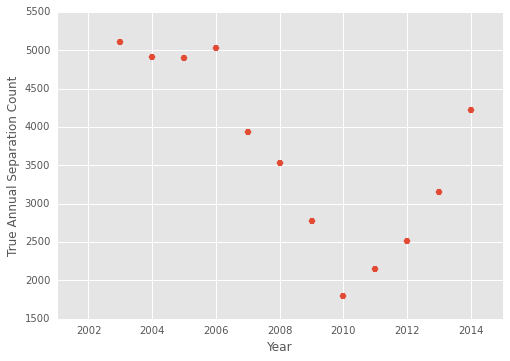

In [453]:
wkforce.ix['2003':'2014']['Separation'].plot(marker='H',lw=0)
plt.xlabel('Year')
plt.xlim(['2001','2015'])
plt.ylabel('True Annual Separation Count')

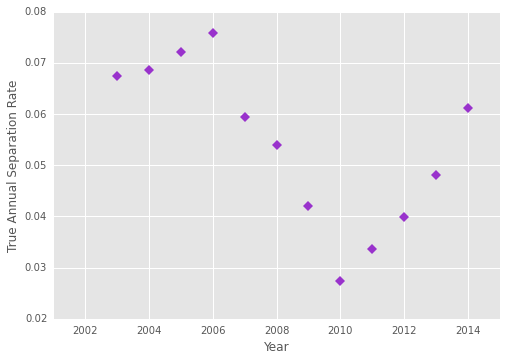

In [455]:
wkforce['SepRate'] = wkforce['Separation']/wkforce['Active']
wkforce.ix['2003':'2014']['SepRate'].plot(marker='D',lw=0,color='darkorchid')
plt.xlabel('Year')
plt.xlim(['2001','2015'])
plt.ylabel('True Annual Separation Rate')

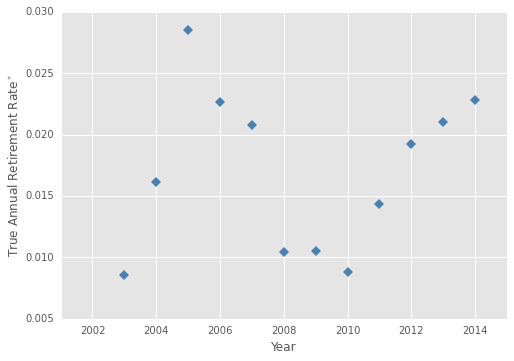

In [458]:
wkforce['RetirementRate1']= wkforce['Retired']/wkforce['Active']
wkforce.ix['2003':'2014']['RetirementRate1'].plot(marker='D',lw=0,color='steelblue')
plt.xlabel('Year')
plt.xlim(['2001','2015'])
plt.ylabel('True Annual Retirement Rate$^*$')

In [461]:
print wkforce[['SepRate','RetirementRate1']].ix['2003':'2014'].max()
print wkforce[['SepRate','RetirementRate1']].ix['2003':'2014'].min()

SepRate            0.075893
RetirementRate1    0.028533
dtype: float64
SepRate            0.027438
RetirementRate1    0.008534
dtype: float64


In [457]:
wkforce_build =  create_workforce_counts(e2build,full_date_range)
wkforce_test = create_workforce_counts(e2eval,full_date_range)
len(e2build), len(e2eval)

(107412, 26854)

## Calculate the separation rates using the RF model for current employees
* method A: sum prob

In [474]:
current_sep_prob_raw = all_rf_sep_df.ix[current_index].sum()/float(len(current_index))
current_sep_prob_raw

sep1yr    0.076805
sep2yr    0.130035
sep3yr    0.173409
sep4yr    0.213233
sep5yr    0.251367
dtype: float64

In [468]:
current_sep_prob_raw.diff()

sep1yr         NaN
sep2yr    0.053230
sep3yr    0.043374
sep4yr    0.039824
sep5yr    0.038134
dtype: float64

* method B: use threshold of 50 %

In [473]:
current_sep_prob_50pct = (all_rf_sep_df.ix[current_index]>=0.5).astype(int).sum()/float(len(current_index))
current_sep_prob_50pct

sep1yr    0.015401
sep2yr    0.050968
sep3yr    0.102742
sep4yr    0.150515
sep5yr    0.196718
dtype: float64

In [475]:
current_sep_prob_50pct.diff()


sep1yr         NaN
sep2yr    0.035567
sep3yr    0.051774
sep4yr    0.047773
sep5yr    0.046204
dtype: float64

In [448]:
em2002[(em2002['hire_tstmp']<'2003-01-01') & (em2002['term_tstmp']>'2003-01-01')][['hire_tstmp','Age_years','term_tstmp','Tenure_years','status']]

,hire_tstmp,Age_years,term_tstmp,Tenure_years,status
273,1992-06-08,51.660507,2015-01-01,22.565366,1
463,1997-06-16,25.875428,2003-01-13,5.577002,1
464,2002-03-04,57.960301,2003-01-21,0.884326,1
465,1988-04-04,39.348392,2003-01-31,14.825462,1
466,1991-10-07,34.332649,2003-01-31,11.318275,1
467,1985-11-11,41.264887,2003-01-31,17.221081,1
468,1993-03-29,42.532512,2003-01-31,9.842574,1
469,1994-03-07,36.758385,2003-01-31,8.903491,1
470,1994-04-04,33.467488,2003-01-31,8.826831,1
471,1992-06-15,32.854209,2003-01-31,10.628337,1


In [449]:
len(em2002[(em2002.status==1)&(em2002.term_tstmp=='2015-01-01')])

3

### use gbc

In [ ]:
from sklearn import ensemble, tree, metrics

In [ ]:
model_cols = [c for c in used_features]
model_cols.remove('former')

In [ ]:
%%time
grmse5, groc_auc5, gbmdl5 = apply_tKfold_CV2('gbc',panel5, tfold5, cols_to_use=model_cols,tgt_column='former',ntrees=500)a

In [ ]:
%%time
rmse5, roc_auc5, rfmdl5 = apply_tKfold_CV2('rfc',panel5, tfold5, cols_to_use=model_cols,tgt_column='former',ntrees=300)

In [ ]:
np.mean(rmse5), np.mean(roc_auc5)

In [ ]:
np.mean(grmse5), np.mean(groc_auc5)

In [ ]:
np.mean(grmse5), np.mean(groc_auc5)

In [ ]:
from sklearn import metrics
def plot_conf_matrix(y_true,y_pred,normed=True,**kwargs):
    my_c = metrics.confusion_matrix(y_true,y_pred)
    
    print metrics.matthews_corrcoef(y_true,y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')
        
    sns.heatmap(my_c, annot=True,  fmt='',cmap='Blues')
    plt.ylabel('True')
    #plt.yticks
    plt.xlabel('Assigned')
    plt.show()
    
    return

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = metrics.roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = metrics.auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    return roc_auc

In [ ]:
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

In [ ]:
def adjust_eval_by_x_years(df,year_val,modeling_columns,tstmp_cols=tstmp_cols,target_col='former'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    eval_within_time_target_index = df[(df[target_col]==1) & (df.Tenure_years <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the target to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    hire_age = (df.ix[eval_within_time_target_index]['birth_tstmp']-df.ix[eval_within_time_target_index]['hire_tstmp'])/np.timedelta64(1,'Y')#.days/days_in_year
    eval_adj_age.ix[eval_within_time_target_index] = hire_age #df.ix[eval_within_time_target_index]['birth_tstmp'#df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns))
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)))
    # drop 'Age_years' and Tenure_years from the list
    cols_to_use = []
    cols_to_use+=modeling_columns
    cols_to_use.remove('Age_years')
    cols_to_use.remove('Tenure_years')#.copy()
    """
    Xeval[:,:-2] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    """
    # this version matches the changed ording of columns
    Xeval[:,0]=eval_adj_age.values
    Xeval[:,1]=eval_adj_tenure
    Xeval[:,2:] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    return Xeval, y_eval

In [ ]:
X5eval, y5eval = adjust_eval_by_x_years(evaluation,5,model_cols)

In [ ]:
#gb_mdl5_pred_class, gb_mdl5_pred_proba = evaluate_models(gb_mdl5,X5eval)
pred_rf5_class, pred_rf5_proba = evaluate_models(rfmdl5,X5eval)

In [ ]:
#gb_mdl5_pred_class, gb_mdl5_pred_proba = evaluate_models(gb_mdl5,X5eval)
pred_gb5_class, pred_gb5_proba = evaluate_models(gbmdl5,X5eval)

In [ ]:
plot_conf_matrix(y5eval,map(np.int,pred_rf5_class.mean(axis=1)))#gb_mdl5_pred_class.mean(axis=1)))

In [ ]:
plot_conf_matrix(y5eval,map(np.int,pred_gb5_class.mean(axis=1)))#gb_mdl5_pred_class.mean(axis=1)))

In [ ]:
#plot_conf_matrix(y5eval,map(np.int,gb_mdl5_pred_class.mean(axis=1)))
plot_roc_curve(y5eval,pred_rf5_proba[:,:,:].mean(axis=2))#gb_mdl5_pred_proba[:,:,:].mean(axis=2))

In [ ]:
#plot_conf_matrix(y5eval,map(np.int,gb_mdl5_pred_class.mean(axis=1)))
plot_roc_curve(y5eval,pred_gb5_proba[:,:,:].mean(axis=2))#gb_mdl5_pred_proba[:,:,:].mean(axis=2))

In [ ]:
#len(gb_mdl5[1].feature_importances_),len(used_features)
plotFI(rfmdl5[0],model_cols)

In [ ]:
fi_5df = create_fi_df(rfmdl5,model_cols)
val_cols = [a for a in fi_5df.columns if 'value' in a]
fi_5df[val_cols].T.boxplot()
plt.title('Feature Importances for 5year former')
plt.ylabel('Feature Importances in Tfolds')

In [ ]:
fi_5df.sort_values(by='avg_val',ascending=False)['avg_val'].ix[:30].plot(kind='barh')

In [ ]:
print len(gbmdl5), len(rfmdl5)
#fi_5df_gbc = create_fi_df(gbmdl5,model_cols)
#val_cols = [a for a in fi_5df.columns if 'value' in a]
#fi_5df_gbc[val_cols].T.boxplot()
#plt.title('Feature Importances for 5year former GBC')
#plt.ylabel('Feature Importances in Tfolds')

In [ ]:
def create_gb_fi_df(mdl_list,feature_names):
    list_feature_importances = []
    col_list = []
    for i,mdl in enumerate(mdl_list):
        list_feature_importances.append(get_gb_FI(mdl,feature_names,show_plot=False))
        col_list.append('fold'+str(i)+'_value')
        #col_list.append('fold'+str(i)+'_std')

    fi_df = pd.concat(list_feature_importances,axis=1)
    # create column headings
    fi_df.columns = col_list
    # create the average of the values
    value_cols = [x for x in col_list if x.endswith('value')]
    
    fi_df['avg_val']=fi_df[value_cols].mean(axis=1)
    fi_df['avg_variance']=fi_df[value_cols].std(axis=1)
#t2_eval_fi_df[['avg_val','avg_std']].sort('avg_val',ascending=False)
    return fi_df

def get_gb_FI(mdl,featureNames=[],show_plot=False):
    """
    forest is the model to be graphed.
    featureNames is the list of features to be displayed
    
    """
    
    featureImportances=mdl.feature_importances_
    # sort the importances from biggest to least
    indices = np.argsort(featureImportances)[::-1]
    nfeatures = len(featureImportances)
    print("Number of Features: %d" % (nfeatures))
    
    
    #print featureNames
    if len(featureNames)==0:
        featureNames = map(str,indices)
    
    fN2 = [featureNames[a] for a in indices]
    print("Feature ranking:")

    for f in range(len(indices)):
        print("%d. feature %d=%s (%f)" % (f + 1, indices[f], featureNames[indices[f]],featureImportances[indices[f]]))

    # Plot the feature importances of the forest
    # define a cutoff in terms of feature_importance
    if nfeatures <= 30:
        kfeatures = nfeatures # keep all if smaller than 30
    else:
        kfeatures = 30
        
    kindices = indices[:kfeatures]
    if show_plot:
        plt.title("Feature importances")
        plt.barh(range(len(kindices)), featureImportances[kindices],
           color="steelblue",  align="center")
    
        plt.yticks(range(len(kindices)),fN2)
        #grid(True)
    
    c1 = 'value'
    #tdata = np.vstack([featureImportances[indices],std[indices]])
    df = pd.DataFrame(data = featureImportances,index=fN2,columns=[c1])
    return df
#plt.barh(range(len(model_cols)),gbmdl5[0].feature_importances_)
#plotFI(gbmdl5[0],model_cols)
#get_gb_FI(gbmdl5[0],model_cols)

In [ ]:
gb5_fi_df = create_gb_fi_df(gbmdl5,model_cols)

In [ ]:
gb5_fi_df.sort_values(by='avg_val',ascending=False)['avg_val'].ix[:30].plot(kind='barh')

## Repeat RF without the FUNC_CNT, EXTFUNC_CNT variables

In [ ]:
count_cols = [a for a in model_cols if a.endswith('CNT')]

In [ ]:
build[count_cols].describe()

In [ ]:
plt.scatter(build['FUNC_CNT'],build['EXTFUNC_CNT'],alpha=0.3)
#pd.crosstab(build,['FUNC_CNT','EXTFUNC_CNT'])#count_cols[3:5])
#build[count_cols[3:5]]#.describe()

In [ ]:
model_cols2 = [c for c in model_cols]
model_cols2.remove('FUNC_CNT')
model_cols2.remove('EXTFUNC_CNT')

In [ ]:
len(model_cols),len(model_cols2)

In [ ]:
%%time
rmse5b, roc_auc5b, rfmdl5b = apply_tKfold_CV2('rfc',panel5, tfold5, cols_to_use=model_cols2,tgt_column='former',ntrees=300)

In [ ]:
np.mean(rmse5b), np.mean(roc_auc5b)

In [ ]:
X5evalb, y5evalb = adjust_eval_by_x_years(evaluation,5,model_cols2)
pred_rf5_classb, pred_rf5_probab = evaluate_models(rfmdl5b,X5evalb)

In [ ]:
plot_conf_matrix(y5evalb,map(np.int,pred_rf5_classb.mean(axis=1)))
plot_roc_curve(y5evalb,pred_rf5_probab[:,:,:].mean(axis=2))#gb_mdl5_pred_proba[:,:,:].mean(axis=2))

In [ ]:
fi_5dfb = create_fi_df(rfmdl5b,model_cols2)
val_cols = [a for a in fi_5dfb.columns if 'value' in a]
fi_5dfb[val_cols].T.boxplot()
plt.title('Feature Importances for 5year former b')
plt.ylabel('Feature Importances in Tfolds')

In [ ]:
fi_5dfb.sort_values(by='avg_val',ascending=False)['avg_val'].ix[:40].plot(kind='barh')

In [ ]:
fi_5dfb.sort_values(by='avg_val',ascending=False)[['avg_val','avg_variance']].head(50)

In [ ]:
plt.scatter(build.MAX_RT_ANNUAL,build.MIN_RT_ANNUAL,alpha=0.3)
plt.xlabel('MAX_RT_ANNUAL')
plt.ylabel('MIN_RT_ANNUAL')

In [ ]:
plt.scatter(build.SAL1,build.BOX1,alpha=0.3)
plt.xlabel('SAL1')
plt.ylabel('MIN_RT_ANNUAL')

In [ ]:
model_cols3 = [c for c in model_cols2 if c != 'MAX_RT_ANNUAL']
print len(model_cols3)

In [ ]:
%%time
rmse5c, roc_auc5c, rfmdl5c = apply_tKfold_CV2('rfc',panel5, tfold5, cols_to_use=model_cols3,tgt_column='former',ntrees=300)

In [ ]:
print np.mean(rmse5c),np.mean(roc_auc5c)

In [ ]:
X5evalc, y5evalc = adjust_eval_by_x_years(evaluation,5,model_cols3)
pred_rf5_classc, pred_rf5_probac = evaluate_models(rfmdl5c,X5evalc)

In [ ]:
plot_conf_matrix(y5evalc,map(np.int,pred_rf5_classc.mean(axis=1)))
plot_roc_curve(y5evalc,pred_rf5_probac[:,:,:].mean(axis=2))

In [ ]:
fi_5dfc = create_fi_df(rfmdl5c,model_cols3)
val_cols = [a for a in fi_5dfc.columns if 'value' in a]
fi_5dfc[val_cols].T.boxplot()
plt.title('Feature Importances for 5year former c')
plt.ylabel('Feature Importances in Tfolds')

In [ ]:
fi_5dfc.sort_values(by='avg_val',ascending=False)['avg_val'].ix[:40].plot(kind='barh')

## look at trying a survival model fro these top features

In [ ]:
print fi_5dfc.sort_values(by='avg_val',ascending=False)['avg_val'].ix[:30].sum()#index.tolist()
sorted_variables = fi_5dfc.sort_values(by='avg_val',ascending=False).index.tolist()


In [ ]:
sorted_variables[:30]

In [ ]:
top_features_cat = ['EXT_FUNC_ID_SFI','JOBCODE','FUNC_ID_SFI','DIVISION_CODE_SFI',
                    'GRADE_le','JOB_FAMILY_le','JOB_FUNCTION_le','LOC_STATE_le',
                    'EEO1CODE']

In [ ]:
e2build.DIVISION_CODE_SFI.value_counts()

In [ ]:
import patsy

In [ ]:
Xtrain_0 = patsy.dmatrix("MIN_RT_ANNUAL+Age_years+HAVE_INS+SAL1+PERF1+MERIT1+BOX1+DEPENDENT_CNT+C(EXT_FUNC_ID_SFI)-1",e2build,return_type='dataframe')

In [ ]:
Xtrain_0.head()

In [ ]:
from lifelines import AalenAdditiveFitter

In [ ]:
aaf = AalenAdditiveFitter(coef_penalizer=1.0)

In [ ]:
Xtrain_0['T']=e2build['Tenure_years']
Xtrain_0['E']=e2build['former']

In [ ]:
%%time
aaf.fit(Xtrain_0, 'T', event_col='E')

In [ ]:
aaf.

## Simply try to build an RF regressor
* look at the feature importances

In [ ]:
from sklearn import ensemble

In [ ]:
%%time
# Fit regression model
params = {'n_estimators': 300, 'n_jobs': -1, 'oob_score': True}
          #'max_depth': 4, 'min_samples_split': 1,
          #'learning_rate': 0.01, 'loss': 'ls','n_jobs': -1}
clf = ensemble.RandomForestRegressor(**params)

clf.fit(build, y)


In [ ]:
mse = metrics.mean_squared_error(y_eval, clf.predict(evaluation))
print("MSE: %.4f" % mse)


In [ ]:
plt.scatter(y_eval,clf.predict(evaluation),alpha=0.3)
plt.xlabel('True Tenure')
plt.ylabel('Predicted Tenure')

In [ ]:
# function to push feature_importances for a set of RF models into a dataframe
def create_fi_df(mdl_list,feature_names):
    list_feature_importances = []
    col_list = []
    for i,mdl in enumerate(mdl_list):
        list_feature_importances.append(plotFI(mdl,feature_names,show_plot=False))
        col_list.append('fold'+str(i)+'_value')
        col_list.append('fold'+str(i)+'_std')

    fi_df = pd.concat(list_feature_importances,axis=1)
    # create column headings
    fi_df.columns = col_list
    # create the average of the values
    value_cols = [x for x in col_list if x.endswith('value')]
    
    fi_df['avg_val']=fi_df[value_cols].mean(axis=1)
    fi_df['avg_variance']=fi_df[value_cols].std(axis=1)
#t2_eval_fi_df[['avg_val','avg_std']].sort('avg_val',ascending=False)
    return fi_df

def plotFI(forest,featureNames=[],show_plot=True):#,autoscale=True,headroom=0.05):
    """
    forest is the model to be graphed.
    featureNames is the list of features to be displayed
    
    """
    #if autoscale:
    #    x_scale = forest.feature_importances_.max()+ headroom
    #else:
    #    x_scale = 1
    
    featureImportances=forest.feature_importances_
    # sort the importances from biggest to least
    indices = np.argsort(featureImportances)[::-1]
    estimators = forest.estimators_
    # calculate the variance over the forest 
    
    std = np.std([tree.feature_importances_ for tree in estimators],axis=0)
    # print summary statement
    nfeatures = len(featureImportances)
    print("Number of Features: %d" % (nfeatures))
    print("Number of Trees: %d" %(len(estimators)))
    
    #print featureNames
    if len(featureNames)==0:
        featureNames = map(str,indices)
    
    fN2 = [featureNames[a] for a in indices]
    print("Feature ranking:")

    for f in range(len(indices)):
        print("%d. feature %d=%s (%f)" % (f + 1, indices[f], featureNames[indices[f]],featureImportances[indices[f]]))

    # Plot the feature importances of the forest
    # define a cutoff in terms of feature_importance
    if nfeatures <= 30:
        kfeatures = nfeatures # keep all if smaller than 30
    else:
        kfeatures = 30
        
    kindices = indices[:kfeatures]
    if show_plot:
        plt.title("Feature importances")
        plt.barh(range(len(kindices)), featureImportances[kindices],
           color="steelblue", xerr=std[kindices], align="center",ecolor='k')#,lw=2)
    
        plt.yticks(range(len(kindices)),fN2)
        #grid(True)
    
    c1 = 'value'
    c2 = 'std'
    tdata = np.vstack([featureImportances[indices],std[indices]])
    df = pd.DataFrame(data = tdata.T,index=fN2,columns=[c1,c2])
    return df

In [ ]:
plotFI(clf,used_features)

In [ ]:
br.perfect_collinearity_test(build)

In [ ]:
em2002.groupby('status').Age_years.hist(bins=60,alpha=0.3,normed=True)

In [ ]:
em2002.groupby('former').Age_years.hist(bins=60,alpha=0.3,normed=True)

## eliminate redundant columns

In [ ]:
my_cols_to_omit.remove('Tenure_years')
my_cols_to_omit.remove('former')

pipe1 = Pipeline([("null",br.RemoveAllNull()),
                 ("drop",br.DropColumns(columns_to_drop =my_cols_to_omit)),
                 ("label_encode",br.LabelEncodeColumn(my_label_encode_cols)),
                 
                 #("dummy_encode", br.DummyEncodeColumn(cat_cols_to_dummy_encode)),
                 #("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 ("dummy_encode",br.ConvertCategorical(categorical_columns=cat_cols_to_dummy_encode,method='dummy')),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=my_minfix_cols,criteria_coef=('percentile',2),
                                                   method='lower',fill_with='nearest_value')),
                 ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_ANNUAL_RT'],criteria_coef=('percentile',2),
                                                   method='both',fill_with='nearest_value')),
                 ("fill_missingzero",br.FillMissingValue(columns_to_fix=missing_zero_cols,fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=mode_impute_cols,rows_to_scan=0.8))
                 ])

In [ ]:
build = pipe1.fit_transform(e2build,e2build['former'])
p1_columns = build.columns.tolist()

In [ ]:
p1_collin_test_build = br.perfect_collinearity_test(build)

In [ ]:
p1_collin_test_build.hist(bins=30)

In [ ]:
'EXT_FUNC_ID_SFI' in used_features

In [ ]:
len(p1_collin_test_build[p1_collin_test_build>0.95]), len(p1_collin_test_build)

In [ ]:
model_cols = p1_collin_test_build[p1_collin_test_build <0.95].index.tolist()
print len(model_cols)

In [ ]:
model_cols

In [ ]:
columns_for_modeling = [a for a in used_features if a not in redundant_columns]

In [ ]:
[a for a in model_cols if a == 'Tenure_years']

### Try a survival model

In [ ]:
from lifelines import CoxPHFitter
cf = CoxPHFitter()
#from lifelines import AalenAdditiveFitter

In [ ]:
%%time
b2 = build[model_cols]
b2['former']=e2build['former']
cf.fit(b2,'Tenure_years','former')

In [ ]:
cf.summary()

In [35]:
#define a function to fit and score a model with variables
def optimize_model(df,column_list,tgt_col = 'Age_years',ind_col='retired'):
    concordvals =[]
    my_col = [tgt_col,ind_col]
    for idx,col in enumerate(column_list):
        cf = CoxPHFitter()
        my_col.append(col)
        cf.fit(df[my_col],tgt_col,event_col=ind_col)
       
        cf.print_summary()
        concord = concordance_index(df[tgt_col],-cf.predict_partial_hazard(df[my_col[2:]].values),df[ind_col])
        print col, idx, concord
        concordvals.append(concord)
    return concordvals
#'SEX','FTE','HAVE_INS','HAVE_DEP','SAL1']

In [ ]:
# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(em2002))
eval_fraction = 0.20
e2build, e2eval = cross_validation.train_test_split(over50,test_size=eval_fraction,random_state = 88843)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(o50eval),len(o50build))

### Generic processing steps
1. define set of columns to keep for analysis
    * remove historical ones & Rate
2. convert dates to timestamps and calculate the age/tenure/hire-age
3. convert indicators
4. convert BOX1

In [ ]:
all_cols = em2002.columns.tolist()
print "starting with {0} columns.".format(len(all_cols))

In [ ]:
## look at historical columns and drop them
historical_cols = []
for i in xrange(2,11):
    #print str(i)
    hcols = [a for a in all_cols if a.endswith(str(i))]
    historical_cols+=hcols
print "{0} historical columns will be omited".format(len(historical_cols) )


In [ ]:
o50build.shape

In [36]:
rset1

['SAL1',
 'HAVE_INS',
 'MERIT1',
 'PERF1',
 'MIN_RT_ANNUAL',
 'INTERN',
 'BOX1',
 'HAVE_DEP',
 'Age_years',
 'DEPENDENT_CNT',
 'DIRECT_RPT_CNT',
 'Tenure_years',
 'former']

In [37]:
%time
tmp_col = ['SAL1','MERIT1','HAVE_INS','HAVE_DEP','PERF1','BOX1','MIN_RT_ANNUAL','Age_years','SEX']
optimize_model(e2build,tmp_col,tgt_col = 'Tenure_years',ind_col='former')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 24.1 µs
n=107412, number of events=39684

           coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
SAL1 -1.832e+00  1.601e-01 1.048e-02 -1.748e+02 0.000e+00  -1.853e+00  -1.812e+00  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.830
SAL1 0 0.8299054961
n=107412, number of events=39684

             coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
SAL1   -1.727e+00  1.778e-01 1.017e-02 -1.698e+02 0.000e+00  -1.747e+00  -1.707e+00  ***
MERIT1 -2.910e-01  7.475e-01 5.694e-03 -5.111e+01 0.000e+00  -3.022e-01  -2.799e-01  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.832
MERIT1 1 0.832273702535
n=107412, number of events=39684

               coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
SAL1     -1.358e+00  2.573e-01 9.970e-03 -1.362e+02  0.000e+00  -1.377e+00  -1.

/opt/anaconda/2.3.0/lib/python2.7/site-packages/lifelines/fitters/coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


[0.8299054960997283,
 0.83227370253498523,
 0.85059567673895065,
 0.85133264636941641,
 0.88243781117460163,
 0.88349923010788012,
 0.88351124288903815,
 0.89474070446548104,
 0.89530243278255861]

In [ ]:
o50build[['retired','Age_years','SEX','hire_age']].head()

### build a coxproporitional hazard model based upon:
* Sex, hire_age, SAL1, MERIT1, HAVE_INS, & HAVE_DEP (model_A)

In [ ]:
cf_modA = CoxPHFitter()
cf_modA.fit(o50build[['retired','Age_years','SEX','hire_age','SAL1','MERIT1','HAVE_INS','HAVE_DEP']],'Age_years',event_col='retired')

In [ ]:

cf_modA.print_summary()

In [ ]:
cf_modA.summary

In [ ]:
cf_modA.predict_expectation(o50build[['retired','Age_years','SEX','hire_age','SAL1','MERIT1','HAVE_INS','HAVE_DEP']])

In [ ]:
cf_modA2 = CoxPHFitter()
cf_modA2.fit(o50build[['retired','Age_years','SEX','Tenure_years','SAL1','MERIT1','HAVE_INS','HAVE_DEP']],'Age_years',event_col='retired')

In [ ]:
cf_modA2.summary

In [ ]:
concordance_index(self.durations,
                                        -self.predict_partial_hazard(self.data).values.ravel(),
                                        self.event_observed))

In [ ]:
cf.predict_partial_hazard(o50build).values.ravel()

In [ ]:
from lifelines.utils import concordance_index 
concordance_index(cf.durations.values,cf.predict_expectation(o50build[['retired','Age_years','SEX','HAVE_INS','hire_age']]).values.ravel(),cf.event_observed.astype(int).values )

In [ ]:
cf.event_observed.astype(int).values

In [ ]:
expectations = cf.predict_expectation(o50build[['retired','Age_years','SEX','HAVE_INS','hire_age']])
expectations.head()

In [ ]:
cf.durations[cf.event_observed]

In [ ]:
#surv_minimal_cols_to_keep = ['Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']

In [ ]:
retire_surv_cols1 = ['retired','Age_years','hire_age','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']
cf2 = CoxPHFitter()
cf2.fit(o50build[retire_surv_cols1], 'Age_years', event_col='retired')

cf2.print_summary()

In [ ]:
cf.hazards_

In [ ]:
cf2.hazards_

## pickle my result

In [ ]:
import pickle
pickle.dump( cf_modA, open( "retirement_sfA.pkl", "wb" ) )

In [ ]:
## now load it
ret_model = pickle.load(open('retirement_sfA.pkl','rb'))

In [ ]:
ret_model.hazards_

## predict results for o50eval

In [ ]:
o50eval[['Age_years','retired']].head()

In [ ]:
cf_modA.predict_survival_function(o50eval.head()).ix[58.07:]

In [ ]:
cf2_pred = cf2.predict_survival_function(o50eval[retire_surv_cols1[2:]].values)
cf2_pred.index.name='years'
cf2_pred.reset_index(inplace=True)
cf2_pred.head()

## dec 17, 2015
replace hire_age with Tenure_years

In [ ]:
retire_surv_cols1 = ['retired','Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']
cf3 = CoxPHFitter()
cf3.fit(o50build[retire_surv_cols1], 'Age_years', event_col='retired')

cf3.print_summary()

In [ ]:
cf2.print_summary()

In [ ]:
import scipy.interpolate
def survival_predictions(edf,psf = cf_pred):
    for employee_id,age in enumerate(ages):
        prior_idx = np.where(psf.years<age+1.0)
        posterior_idx = np.where(psf.years>age+1.0)
        x= [psf.ix[prior_idx]['years'], psf.ix[posterior_idx]['years']]
        y= [psf.ix[prior_idx][employee_id],psf.ix[posterior_idx][employee_id]]
        print x,y, employee_id, age
    ## now interpolate these
        y_interp = scipy.interpolateinterp1d(x,y)
        print y_interp
    return y_interp
    

In [ ]:
def get_survival_prediction(edf,psf=cf_pred, age_col='Age_years',yr_vals=[1,2,3,4,5]):
    
    pred_col_names = ['proba_'+str(y) for y in yr_vals]
    df = pd.DataFrame(index=edf.index,columns=pred_col_names,dtype=float)
    print pred_col_names
    for employee_id,age in enumerate(edf['Age_years']):
        if employee_id % 1000 ==0 :
            print employee_id, age
            
        prob_vals =np.ones((len(yr_vals),))
        #print prob_vals,"\n"
        
        for idx,year in enumerate(yr_vals):
            ck_yr = age+year
            #if ck_yr in psf.years:
            #    proba = psf[psf.years==ck_yr][employee_id]
            #else:
            #proba=np.nan
            
            try:
                prior_idx = np.where(psf.years < ck_yr)[0][-1]
                posterior_idx = np.where(psf.years > ck_yr)[0][0]
                x= [psf.ix[prior_idx]['years'], psf.ix[posterior_idx]['years']]
                y= [psf.ix[prior_idx][employee_id],psf.ix[posterior_idx][employee_id]]
                #print x,y, year
                ## now interpolate these
                y_interp = scipy.interpolate.interp1d(x,y)
                proba = y_interp(ck_yr)
            except IndexError:
                proba = psf.ix[np.where(psf.years == ck_yr)[0]][employee_id]
            #print proba
            
            try:
                prob_vals[idx] = proba
                #print employee_id,age,ck_yr,proba, prob_vals[idx]
            except ValueError: # case when age not found because too young
                #lse:
                pass #print idx, prob_vals[idx]
                # just leave it as the default value of 1
                    
            #prob_vals[id]=1-proba    
            #if len(yr_vals)>1:
            #    empl_list.append(1-proba)# get prob of retirement
            #else:
            #    empl_list = 1-proba
        #try:
        df.loc[edf.index[employee_id]]=prob_vals
        #except ValueError: # case when not found (because too young)
        #    df.loc[edf.index[employee_id]]=0.0 # zero probability
            #print employee_id, edf.index[employee_id]
    df.fillna(0.0,inplace=True) # fillin missing values with zero
    df[df<0] = 0.0 #replace negative probabilities with zero
    #df.replace()
    return df


In [ ]:
cfRetProb = get_survival_prediction(o50eval,psf=cf_pred)

In [ ]:
#pred_o50eval=pd.concat([o50eval[retire_surv_cols1[:2]],retireProb_df],axis=1)
pred_o50eval_cf = pd.concat([o50eval[retire_surv_cols1[:2]],cfRetProb],axis=1)

In [ ]:
pred_o50eval_cf.head()

### assess the prob_retired at current age for eval set

In [ ]:
curr_retire_age = get_survival_prediction(o50eval,yr_vals=[0])
o50eval_curr = pd.concat([o50eval[retire_surv_cols1[:2]],curr_retire_age],axis=1)

In [ ]:
o50eval_curr.head() #proba is the probability of 'survival' so I want 1-proba for probability to retire

In [ ]:
def get_accuracy(df,true_col = 'retired', p_col = 'proba_0',thresh=0.5,verbose=False):
    ckdf = (df[p_col]<=thresh).astype('int')
    true_pos = df[ckdf==1][true_col].sum()
    false_pos= len(df[ckdf==1])-true_pos
    
    false_neg=df[ckdf==0][true_col].sum()
    true_neg =len(df[ckdf==0]) - false_neg
    if verbose:
        print "threshold = {0}".format(thresh)
        print "TP\t FP\t FN\t TN"
        print true_pos, '\t',false_pos,'\t' ,false_neg,'\t', true_neg
    
    acc = (true_pos + true_neg)/float(len(df))
    
    mcc = (true_pos*true_neg - false_pos*false_neg)/np.sqrt((true_pos+false_pos)*(true_pos+false_neg)*(true_neg+false_pos)*(true_neg+false_neg))
    if verbose:
        print "Accuracy is {0:.3f}".format(acc)
        print "Matthews correlation coefficient is {0:.3f}".format(mcc)
    tpr = true_pos/float(true_pos+false_neg)
    fpr = false_pos/float(false_pos + true_neg)
    return tpr,fpr,acc,mcc

In [ ]:
from sklearn import metrics
metrics.roc_auc_score(o50eval_curr.retired.values,1-o50eval_curr.proba_0.values)

In [ ]:
roc_vals = []
tvals = np.linspace(0,1,21)#,0.05)#:#xrange(0,1,0.05):
for t in tvals:
    roc_vals.append(get_accuracy(o50eval_curr,thresh=t))

    
roc_vals = np.array(roc_vals)

In [ ]:
roc_vals = np.array(roc_vals)
plt.plot(roc_vals[:,1],roc_vals[:,0])
plt.plot(tvals,tvals,color='k',ls='--')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Repeat for Separation
* use all employees -- split into test & training

In [ ]:
sepCF = CoxPHFitter()
sepCF.fit(e2build[sep_surv_cols1], 'Tenure_years', event_col='former')

sepCF.print_summary()



In [ ]:
sepCF.hazards_

In [ ]:
sepcf_pred = sepCF.predict_survival_function(e2eval[sep_surv_cols1[2:]].values)
sepcf_pred.index.name='years'
sepcf_pred.reset_index(inplace=True)
sepcf_pred.head()

In [ ]:
plt.plot(sepcf_pred.years, sepcf_pred[0])

In [ ]:
cfSepProb = get_survival_prediction(e2eval,psf=sepcf_pred)

In [ ]:
cfSepProb.head()

## assess the current Sep probability

In [ ]:
curryear_sep_pred = get_survival_prediction(e2eval,yr_vals=[0],psf=sepcf_pred)


In [ ]:
e2eval_sepNow = pd.concat([e2eval[sep_surv_cols1[:2]],curryear_sep_pred],axis=1)

In [ ]:
e2eval_sepNow.head()

In [ ]:
metrics.roc_auc_score(e2eval_sepNow.former.values,1-e2eval_sepNow.proba_0.values)

In [ ]:
sep_roc_vals = []
tvals = np.linspace(0,1,41)#,0.05)#:#xrange(0,1,0.05):
for t in tvals:
    sep_roc_vals.append(get_accuracy(e2eval_sepNow,thresh=t,true_col='former'))

    
sep_roc_vals = np.array(sep_roc_vals)

In [ ]:
plt.plot(sep_roc_vals[:,1],sep_roc_vals[:,0])
plt.plot(tvals,tvals,color='k',ls='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Separation ROC curve; current values e2eval')

## Examine the retirement Rates for current employees

In [ ]:
current = em2002[em2002.status==0].copy() 
np.shape(current)


### apply retirement and separation for next 5 years to this set

In [ ]:
current_retcf_pred = cf.predict_survival_function(current[retire_surv_cols1[2:]].values)
current_retcf_pred.index.name='years'
current_retcf_pred.reset_index(inplace=True)
current_retcf_pred.head()
currentcfRetProb = get_survival_prediction(current,psf=current_retcf_pred)
#current_sepcf_pred = sepCF.predict_survival_function(current[sep_surv_cols1[2:]].values)

In [ ]:
ret_fiveyrDF = pd.concat([current[retire_surv_cols1[:3]],currentcfRetProb],axis=1)

In [ ]:
ret_fiveyrDF[['yr1','yr2','yr3','yr4','yr5']]=1-ret_fiveyrDF[['proba_1','proba_2','proba_3','proba_4','proba_5']]


In [ ]:
tmp_rates = pd.DataFrame(ret_fiveyrDF[['yr1','yr2','yr3','yr4','yr5']].sum()/float(len(ret_fiveyrDF)))
tmp_rates.index = ['yr1','yr2','yr3','yr4','yr5']
tmp_rates.columns = ['Retirement']
tmp_rates['Annual Retirement'] = tmp_rates.diff()
tmp_rates.loc['yr1','Annual Retirement']= tmp_rates.loc['yr1','Retirement']

In [ ]:
current_sepcf_pred = sepCF.predict_survival_function(current[sep_surv_cols1[2:]].values)
current_sepcf_pred.index.name='years'
current_sepcf_pred.reset_index(inplace=True)
current_sepcf_pred.head()
currentcfSepProb = get_survival_prediction(current,psf=current_sepcf_pred)
#current_sepcf_pred = sepCF.predict_survival_function(current[sep_surv_cols1[2:]].values)

In [ ]:
sep_fiveyrDF = pd.concat([current[sep_surv_cols1[:3]],currentcfSepProb],axis=1)


In [ ]:
sep_fiveyrDF[['Sep_1','Sep_2','Sep_3','Sep_4','Sep_5']]=1-sep_fiveyrDF[['proba_1','proba_2','proba_3','proba_4','proba_5']]


In [ ]:
sep_fiveyrDF.head()

In [ ]:
simple_rates = pd.DataFrame(sep_fiveyrDF[['Sep_1','Sep_2','Sep_3','Sep_4','Sep_5']].sum()/float(len(sep_fiveyrDF)))
simple_rates.index = ['yr1','yr2','yr3','yr4','yr5']
simple_rates.columns = ['Separation']
simple_rates['Annual Separation'] = simple_rates.diff()
simple_rates.loc['yr1','Annual Separation']= simple_rates.loc['yr1','Separation']


In [ ]:
simple_rates = pd.concat([simple_rates,tmp_rates],axis=1)
simple_rates

### Clean up missing & dummy encode/etc the categorical --> use a pipe

In [ ]:
missing_columns = br.get_columns_with_nulls(em2[all_cols3])
print len(missing_columns)

In [ ]:
missing_cat_cols = br.get_columns_with_nulls(em2[cat_cols2])
missing_cat_cols

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.base import BaseEstimator,TransformerMixin


In [ ]:
mthl_tenure_range = np.linspace(0,65,781)
def calculate_survival_functions_b(df,y, time_col, col_name,num_cutoff = 40,timerange =mthl_tenure_range):
    
    """ Function to generically return a dataframe of survival function, grouped by some categorical column
    inputs:
        df --> database to derive survival functions from
        time_col --> the temporal column to use for SF modeling (Kaplan Meier fitter applied)
        event_col --> the truncated column to use for SF modeling
        col_name --> the column to group up and determine KMF sf for
        num_cutoff --> number of groups to consider
        timerange --> min and max range
    outputs:
        survivalfunc_df --> a data frame that contains survival function.

    other options:
        *frac_cutoff --> the fraction of unique elements that will be kept as separate groups
        *min_size_cutoff --> min size to use for the cutoff.
        * these last two are not implemented
    """
    from lifelines import KaplanMeierFitter
    kmf=KaplanMeierFitter()
    # create example for all cases -- serves as background
    # create a time range
    
    kmf.fit(df[time_col],timeline=timerange,event_observed=y,label='all')
    survivalfunc_df = pd.DataFrame(kmf.survival_function_)
    # groupify the dataframe
    grp_value_counts = df[col_name].value_counts()
    #if frac_cutoff == None:
    #    #by default take 15 %
    #    frac_cutoff = .15 
    #top_n_groups = int(frac_cutoff *len(grp_value_counts))
    #if min_size_cutoff == None:
        # by default 
    # Take the top num_cutoff groups
    #my_grps = grp_value_counts.ix[:num_cutoff].index.tolist() 
    my_grps = grp_value_counts.iloc[:num_cutoff].index.tolist() 
    
    # make a list of elements in each of these groups
    grp_dict = {}
    for grp in my_grps: 
        grp_dict[grp] = df[df[col_name] == grp].index.tolist()
    # loop through grps and create kmf survival function
    for i,jgrp in enumerate(my_grps):
        j_idx = grp_dict[jgrp]
        #print i, jgrp, len(j_idx)
        kmf.fit(df[time_col].ix[j_idx],timeline=mthl_tenure_range,event_observed=y.ix[j_idx],label=str(jgrp))
        survivalfunc_df = pd.concat([survivalfunc_df,kmf.survival_function_],axis=1)
    
    
    return survivalfunc_df

def return_first_time_survival(sfdf,thresh=0.5):
    from collections import defaultdict
    
    # assign all value to the default
    default_value = sfdf[sfdf['all']<=thresh].index[0]
    median_survival_dict = defaultdict(lambda: default_value)
    for c in sfdf.columns[1:]:
        #print c
        try:
            my_sf_date = sfdf[sfdf[c]<=thresh].index[0]
        except IndexError: # because never reached that threshold value
            my_sf_date = sfdf.index[-1]
        except KeyError: # because of type of the key
            my_sf_date = sfdf[sfdf[int(c)]<=thresh].index[0]

        median_survival_dict[c]=my_sf_date
        
    return median_survival_dict

In [ ]:
class SurvivalEncodeColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_fix=[],rows_to_scan='all',method='median',max_number_groups=40, my_thresh=0.5):
        self.method = method
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        self.max_num_groups = max_number_groups
        self.thresh = my_thresh
        
    def fit(self,X,y):
        self.survive_columns = {} # dictionary to map old columns to new
        self.survive_values = {}
        self.column_cutoff = {}
        
        
        for col in self.columns_to_fix:
            #(assumes these have previously been label encoded so the values should be ints)"
            ncol=str(col)+"_le"
            num_cutoff = self.max_num_groups
            survive_col = 'surv_'+ncol.lower()
            nuniq = len(X[ncol].unique())
            if nuniq < num_cutoff:
                num_cutoff = nuniq
                
            self.column_cutoff[col]=num_cutoff
            
            #frac_accounted_for = X[col].value_counts().iloc[:num_cutoff].sum()/float(len(X))
            #print i,col,newcol, nuniq, num_cutoff,num_cutoff/float(nuniq),frac_accounted_for
            # I want to make this fraction close to 80%?
            sf_df = calculate_survival_functions_b(X,y,'Tenure_years', ncol,num_cutoff)
            self.survive_columns[col]=survive_col
            ## create the dictionary
            self.survive_values[col]=return_first_time_survival(sf_df,thresh=self.thresh)
    
        return self
    def transform(self,X,y=None):
        X_temp = X.copy()
        original_cols = list(X_temp.columns)
        for col in self.columns_to_fix:
            ncol=str(col)+"_le" # assumes labelencoded
            new_col = self.survive_columns[col]
            col_dict = self.survive_values[col]
            X_temp[new_col] = X_temp[ncol].apply(lambda x: col_dict[str(x)])
            original_cols.remove(ncol)
            original_cols.append(new_col)
        
        X_temp = X_temp[original_cols]
        return X_temp
    

In [ ]:
#my_cols_to_omit =list(set(all_cols)-set(all_cols3))
#len(my_cols_to_omit)

In [ ]:
[a for a in all_cols4 if a.endswith('SFI')]

In [ ]:
cat_cols2 = list(set(all_cols3).intersection(set(cat_cols2)))
[(c,len(em2[c].unique())) for c in cat_cols2]

In [ ]:
my_label_encode_cols = ['JOB_FAMILY', 'GRADE', 'JOB_FUNCTION',
 'FLOR_SFI', 'FUNC_ID_SFI', 'EXT_FUNC_ID_SFI',
 'JOBCODE', 'LOC_TYPE_DESCR_SFI',
 'LOC_STATE']
cat_cols_to_dummy_encode = ['EMPL_CLASS','EEO1CODE','EMPL_TYPE','FULL_PART_TIME','ETHNIC_GROUP','DIVISION_CODE_SFI','COMPANY']

In [ ]:
allcols = em2.columns.tolist()
my_cols_to_omit = ['TOT_MO_SERVICE_SFI']

In [ ]:
my_minfix_cols = ['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1']
my_maxfix_cols = ['MAX_RT_ANNUAL']
missing_zero_cols = ['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT']
mode_impute_cols = ['MERIT1','PERF1','ADDRCNT1']

In [ ]:
pipe2 = Pipeline([("null",br.RemoveAllNull()),
                 ("drop",br.DropColumns(columns_to_drop =my_cols_to_omit)),
                 ("label_encode",br.LabelEncodeColumn(my_label_encode_cols)),
                 
                 #("dummy_encode", br.DummyEncodeColumn(cat_cols_to_dummy_encode)),
                 ("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 ("dummy_encode",br.ConvertCategorical(categorical_columns=cat_cols_to_dummy_encode,method='dummy')),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=my_minfix_cols,criteria_coef=('percentile',2),
                                                   method='lower',fill_with='nearest_value')),
                 ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_ANNUAL_RT'],criteria_coef=('percentile',2),
                                                   method='both',fill_with='nearest_value')),
                 ("fill_missingzero",br.FillMissingValue(columns_to_fix=missing_zero_cols,fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=mode_impute_cols,rows_to_scan=0.8))
                 ])

# pull out a build set to make the pipeline from

In [ ]:
print "Starting with subest of {0} employees.".format(len(em2))
eval_fraction = 0.20
em2build, em2eval = train_test_split(em2,test_size=eval_fraction,random_state=83221)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2eval),len(em2build))

In [ ]:
y = em2build['former']
build = pipe2.fit_transform(em2build,y)

In [ ]:
evaluation = pipe2.fit(em2build,y).transform(em2eval)

In [ ]:
list_of_columns = build.columns.tolist()

In [ ]:
[a for a in list_of_columns if a.endswith('SFI')]

In [ ]:
build.to_csv('trans_train.csv',index=False)
evaluation.to_csv('trans_eval.csv',index=False)

In [ ]:
print len(list_of_columns)
[a for a in list_of_columns if a in ['former','status','retired']]

In [ ]:
columns_for_modeling = [a for a in list_of_columns if a not in ['former','status','retired']]
len(columns_for_modeling)

In [ ]:
br.perfect_collinearity_test(build[columns_for_modeling])

In [ ]:
tstmp_cols = [a for a in em2.columns if a.endswith('tstmp')]
tstmp_cols

In [ ]:
redundant_cols = ['hire_age','FULLPART1','COMPANY','ETHNIC_GROUP',
                  'EMPL_TYPE','DIVISION_CODE_SFI','ADDRCNT1_d','PERF1_d','MERIT_d',
                  'EMPL_TYPE_E','FULL_PART_TIME_X','COMPANY_1','ETHNIC_GROUP_1.0','DIVISION_CODE_SFI_4',
                 'EMPL_CLASS_1','EEO1CODE_6']
columns_for_modeling2 = list(set(columns_for_modeling)-set(redundant_cols)-set(tstmp_cols))
br.perfect_collinearity_test(build[columns_for_modeling2])

In [ ]:
len(columns_for_modeling2)

# now build the time-kfolds

In [ ]:
def check_if_subset(list1,list2): #compare_column_lists(list1,list2):
    if set(list1).issubset(set(list2)):
        return 1
    else:
        print "{0} is not contained in {1}. Recheck your lists.".format(list1,list2)
        return 0
    
    

## reintroduce the tstmp columns

In [ ]:
build[tstmp_cols]=em2build[tstmp_cols].apply(lambda x:  pd.to_datetime(x))

In [ ]:
panel4, tfold4 = setup_tfolds(build, 4, columns_for_modeling2, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols=tstmp_cols, date_range=full_date_range)
   

# Now  apply gbc

In [ ]:
from sklearn import ensemble, tree, metrics

In [ ]:
rmse4,roc_auc4,gbmdl4 = apply_tKfold_CV2('gbc',panel4, tfold4,  cols_to_use = columns_for_modeling2, tgt_column='former',ntrees=500)#['columns_for_modeling'],em2mod['former'],)

In [ ]:
gbc_eval_pred4class, gbc_eval_pred4proba = evaluate_models(gbmdl4,X4eval)

In [ ]:
plot_roc_curve(y4eval,gbc_eval_pred4proba[:,:,:].mean(axis=2))

In [ ]:
plot_conf_matrix(y4eval,map(np.int,gbc_eval_pred4class.mean(axis=1)))

## build rf model

In [ ]:
rmse4rf,roc_auc4rf,rfmdl4 = apply_tKfold_CV2('rfc',panel4, tfold4,  cols_to_use = columns_for_modeling2, tgt_column='former',ntrees=100)#['columns_for_modeling'],em2mod['former'],)

In [ ]:
rfc_eval_pred4class, rfc_eval_pred4proba = evaluate_models(rfmdl4,X4eval)

In [ ]:
evaluation[tstmp_cols]=em2eval[tstmp_cols].apply(lambda x: pd.to_datetime(x)) # append the tstmp files

In [ ]:
X4eval, y4eval =adjust_eval_by_x_years(evaluation,4,columns_for_modeling2)#,tstmp_cols=default_tstmps,target_col='former')

In [ ]:
rmse4, rmse4rf

In [ ]:
roc_auc4, roc_auc4rf

In [ ]:
#plot_roc_curve(y4eval,np.vstack([gbc_eval_pred4class.mean(axis=1), gbc_eval_pred4class.mean(axis=1)]).T)

In [ ]:
plot_roc_curve(y4eval,rfc_eval_pred4proba[:,:,:].mean(axis=2))

#REPEAT for retirements

In [ ]:
Rpanel4, Rtfold4 = setup_tfolds(evaluation,4, columns_for_modeling2, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse4,Rroc_auc4,Rrfmdl4 = apply_tKfold_CV2('rfc',Rpanel4, Rtfold4, cols_to_use = columns_for_modeling2, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)


In [ ]:
#float(
((today - evaluation[default_tstmps[2]].iloc[0]).days)/365.25

In [ ]:
RX4eval, Ry4eval = adjust_eval_by_x_yearsR(evaluation,4,columns_for_modeling2, today,target_col = 'retired')
Reval_pred4class,Reval_pred4proba = evaluate_models(Rrfmdl4,RX4eval)
plot_roc_curve(Ry4eval,Reval_pred4proba[:,:,:].mean(axis=2))

## retry retirements using undersampling

In [ ]:
from unbalanced_dataset import UnderSampler, NearMiss, CondensedNearestNeighbour, OneSidedSelection,\
NeighbourhoodCleaningRule, TomekLinks, ClusterCentroids
#OverSampler, SMOTE,\
#SMOTETomek, SMOTEENN, EasyEnsemble, BalanceCascade

#### count the initial classes

In [ ]:
# 'Random under-sampling'
US = UnderSampler(ratio=2)

In [ ]:
Rpanel4, Rtfold4 = setup_tfolds(evaluation,4, columns_for_modeling2, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)

In [ ]:
print len(Rpanel4)
len(Rpanel4[0])

In [ ]:
Rpanel4[0].retired.sum()

In [ ]:
Rpanel_cols = Rpanel4[0].columns.tolist()
Rpanel_cols.remove('retired')


In [ ]:
usx,usy = US.fit_transform(Rpanel4[0][Rpanel_cols].values, Rpanel4[0]['retired'].values)

In [ ]:
usRpanel4[0] = pd.DataFrame(data=usx,columns=Rpanel_cols)
usRpanel4[0]['retired']= usy


In [ ]:
for i in xrange(0,len(Rtfold4)):
    print i, len(Rtfold4[i][0]), len(Rtfold4[i][1])

In [ ]:
Rpanel4[0].ix[Rtfold4[0][1]].retired.value_counts()

In [ ]:
def apply_tKfold_CV2_unBalanced(modeltype, in_panel, tkfolds, cols_to_use, unbalance_mtd='random', tgt_column = 'former', ntrees=100):
    """ Calculate the rmse for each cross-validated temporalFold
    
    Parameters:
        model - a scikit learn model name
        in_panel  - a pandas Panel with the observed input data adjusted 
        tgt_column -- the target variable
        cols_to_use -- the input variables to be used in modeling
        tkfolds -- the temporal timefolds (list of dimension 2)
        unbalance_mtd -- a method of how to deal with imbalanced classes
    outputs:
        models --> the list of fit models
        RMSE --> the rmse error
        
    """
    RMSE = []
    roc_auc = []
    models = []
    
    
    
    for fold_id, indices in enumerate(tkfolds):
        training = indices[0]
        testing = indices[1]
        
        # 'Random under-sampling'
        if unbalance_mtd == 'random':
            sampler = UnderSampler(ratio=2)
        else:
            sampler = NearMiss(version=3)

        
        #print fold_id, len(training),len(testing)
        X_train, X_test = in_panel[fold_id][cols_to_use].ix[training].as_matrix(), in_panel[fold_id][cols_to_use].ix[testing].as_matrix()
        y_train, y_test = in_panel[fold_id][tgt_column].ix[training].as_matrix(), in_panel[fold_id][tgt_column].ix[testing].as_matrix()
        usXtrain, usytrain = sampler.fit_transform(X_train,y_train)
        
        if modeltype == 'rfc':
            model = ensemble.RandomForestClassifier(n_estimators=ntrees, max_features='auto', oob_score=True)
        elif modeltype=='bgc':
            model=ensemble.GradientBoostingClassifier(n_estimators=ntrees,max_features='auto')
        else:
            model=tree.DecisionTreeClassifier()
            
        # Train the model
        print len(usXtrain)
        model.fit(usXtrain,usytrain)
        
        # use the model to predict output
        y_fitted = model.predict(X_test)
        RMSE.append(np.sqrt(metrics.mean_squared_error(y_test,y_fitted)))
        roc_auc.append(metrics.roc_auc_score(y_test,y_fitted))
        models.append(model)
    # leave the model fit to the entire dataset
    #model.fit(in_x,in_y)
    
    return RMSE,roc_auc,models
        

In [ ]:
uRrmse4,uRroc_auc4,uRrfmdl4 = apply_tKfold_CV2_unBalanced('rfc',Rpanel4, Rtfold4, cols_to_use = columns_for_modeling2, tgt_column='retired')

In [ ]:
#plt.scatter(uRroc_auc4, Rroc_auc4)
plt.plot(uRroc_auc4)

In [ ]:
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

In [ ]:
for a in xrange(0,len(uRrfmdl4)):
    plot_roc_curve(Ry4eval,uReval_pred4proba[:,:,a])

In [ ]:
plot_roc_curve(Ry4eval,uReval_pred4proba[:,:,9])

In [ ]:
uReval_pred4class,uReval_pred4proba = evaluate_models(uRrfmdl4,RX4eval)
plot_roc_curve(Ry4eval,uReval_pred4proba[:,:,:].mean(axis=2))

In [ ]:
print len(uReval_pred4proba[:,0,9])
#len(uReval_pred4class)
uReval_pred4class[:,8].sum(), Ry4eval.sum()

In [ ]:
uReval_pred4proba[:,:,4]

In [ ]:
plot_conf_matrix(Ry4eval,uReval_pred4class[:,7])

In [ ]:
#plt.plot(Ry4eval,'o')
#plt.plot(uReval_pred4class[:,2],'d')
#plt.scatter(Ry4eval,Ry4eval-uReval_pred4class[:,2])


In [ ]:

#zip(columns_for_modeling2, gbmdl4[0].feature_importances_)

In [ ]:
[columns_for_modeling2[a] for a in list(np.where(gbmdl4[1].feature_importances_ > 0.1)[0])]

In [ ]:
for i in xrange(0,len(gbmdl4)):
    plt.plot(gbmdl4[i].feature_importances_)
    
#plt.plot(gbmdl4[1].feature_importances_)

In [ ]:
X5eval, y5eval = adjust_eval_by_x_years(evaluate,5,columns_for_modeling2)

In [ ]:
em2[em2.retired==1].Age_years.min()

In [ ]:
em2[em2.retired==1].Age_years.hist(bins=40)

In [ ]:
len(em2[(em2.retired == 1) & (em2.Age_years < 55)]), len(em2[em2.retired == 1])

In [ ]:
em2[(em2.retired == 1) & (em2.Age_years < 55)].Age_years.hist(bins=30)

In [ ]:
#save the over50 set
over50.to_csv('over50.csv',index=False)

In [ ]:
over50.isnull().any()

In [ ]:
from sklearn import cross_validation

In [ ]:
# repeat the split

# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(over50))
eval_fraction = 0.20
o50build, o50eval = cross_validation.train_test_split(over50,test_size=eval_fraction,random_state = 84)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(o50eval),len(o50build))

In [ ]:
print over50.retired.value_counts()
print "----"
print o50eval.retired.value_counts()
print "----"
print o50build.retired.value_counts()
print "----"

In [ ]:
o50build['JOBCODE'].head()

In [ ]:
o50build.columns

In [ ]:
retire_surv_cols1 = ['retired','Age_years','hire_age','SEX','FTE','HAVE_INS','HAVE_DEP']
cf.fit(o50build[retire_surv_cols1], 'Age_years', event_col='retired')

cf.print_summary()

In [ ]:
cf.hazards_

In [ ]:
cf.baseline_cumulative_hazard_.plot()

In [ ]:
first10pred = cf.predict_survival_function(o50eval[retire_surv_cols1[2:]].iloc[:10].values)

In [ ]:
cf_pred = cf.predict_survival_function(o50eval[retire_surv_cols1[2:]].values)


In [ ]:
first10pred[1].plot()

In [ ]:
o50eval[retire_surv_cols1[:2]].head(10)

In [ ]:
[first10pred[first10pred[a]<0.5].index[0] for a in xrange(0,10)]

In [ ]:
from lifelines import AalenAdditiveFitter
aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=True)

In [ ]:
aaf.fit(o50build[retire_surv_cols1], 'Age_years', event_col='retired')


In [ ]:
aaf.plot( columns=[ 'hire_age', 'baseline', 'SEX','FTE' ],ix=slice(53,70)) # cumulative hazard

In [ ]:
aaf.cumulative_hazards_.ix[:70].plot()

In [ ]:
aaf.predict_survival_function(o50eval[retire_surv_cols1[2:]].iloc[:3].values).plot()

In [ ]:
aaf.predict_survival_function(o50eval[retire_surv_cols1[2:]].iloc[:10].values).ix[:70].plot()

## how to apply this
1. take current age, add 1 yr, 2, yr, 3, yr, ,4yr, 5yr and report prob

In [ ]:
o50eval[retire_surv_cols1].head()

In [ ]:
#ages_to_check = o50eval['Age_years'].apply(lambda x: x+[1.0,2.0,3.0,4.0,5.0])

In [ ]:
pred_sf1 = aaf.predict_survival_function(o50eval[retire_surv_cols1[2:]].values)
# columns are the indiviuals.

In [ ]:
pred_sf1.index.name='years'
pred_sf1.reset_index(inplace=True)

In [ ]:
cf_pred = cf.predict_survival_function(o50eval[retire_surv_cols1[2:]].values)
cf_pred.index.name='years'
cf_pred.reset_index(inplace=True)

In [ ]:
len(pred_sf1.T), len(o50eval)

In [ ]:
#cfRetProb.head(), retireProb_df.head()

In [ ]:
retireProb_df = get_survival_prediction(o50eval)

In [ ]:
pred_o50eval=pd.concat([o50eval[retire_surv_cols1],retireProb_df],axis=1)
pred_o50eval_cf = pd.concat([o50eval[retire_surv_cols1],cfRetProb],axis=1)

In [ ]:
pred_o50eval.head()

## try to assess current age for retired or not

In [ ]:
o50eval_curr.Age_years.hist()#tail()#proba_0.describe()


In [ ]:
o50eval_curr[o50eval_curr.retired==1].proba_0.hist(bins=30,label='retired',normed=True,alpha=0.8)
print sum(o50eval_curr.retired==1), sum(o50eval_curr.retired==0)
o50eval_curr[o50eval_curr.retired==0].proba_0.hist(bins=30,label='active',normed=True,alpha=0.3)
plt.legend()
plt.xlabel('Retirement Probability')
plt.ylabel('Normed Counts')

In [ ]:
CFcurr_retire_age = get_survival_prediction(o50eval,psf=cf_pred,yr_vals=[0])
o50eval_curr_cf = pd.concat([o50eval[retire_surv_cols1],CFcurr_retire_age],axis=1)

## assess the model
* define a cutoff in probability and do a count/assessment

In [ ]:
def get_accuracy(df,true_col = 'retired', p_col = 'proba_0',thresh=0.5):
    ckdf = (df[p_col]>thresh).astype('int')
    true_pos = df[ckdf==1][true_col].sum()
    false_pos= len(df[ckdf==1])-true_pos
    
    false_neg=df[ckdf==0][true_col].sum()
    true_neg =len(df[ckdf==0]) - false_neg
    print "threshold = {0}".format(thresh)
    print "TP\t FP\t FN\t TN"
    print true_pos, '\t',false_pos,'\t' ,false_neg,'\t', true_neg
    acc = (true_pos + true_neg)/float(len(df))
    print "Accuracy is {0:.3f}".format(acc)
    mcc = (true_pos*true_neg - false_pos*false_neg)/np.sqrt((true_pos+false_pos)*(true_pos+false_neg)*(true_neg+false_pos)*(true_neg+false_neg))
    print "Matthews correlation coefficient is {0:.3f}".format(mcc)
    tpr = true_pos/float(true_pos+false_neg)
    fpr = false_pos/float(false_pos + true_neg)
    return tpr,fpr

In [ ]:
get_accuracy(o50eval_curr,thresh=0.5)

In [ ]:
roc_vals = []
tvals = np.linspace(0,1,21)#,0.05)#:#xrange(0,1,0.05):
for t in tvals:
    roc_vals.append(get_accuracy(o50eval_curr,thresh=t))

    
roc_vals = np.array(roc_vals)
#    print i

In [ ]:
roc_vals = np.array(roc_vals)
plt.plot(roc_vals[:,0],roc_vals[:,1])
plt.plot(tvals,tvals,color='k',ls='--')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
metrics.auc(roc_vals[:,0],roc_vals[:,1])

In [ ]:
roc_vals_cf = []
tvals = np.linspace(0,1,21)#,0.05)#:#xrange(0,1,0.05):
for t in tvals:
    roc_vals_cf.append(get_accuracy(o50eval_curr_cf,thresh=t))

    
roc_vals_cf = np.array(roc_vals_cf)

plt.plot(roc_vals_cf[:,1],roc_vals_cf[:,0])
plt.plot(tvals,tvals,color='k',ls='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('CoxPH Fitter of eval set')
print metrics.auc(roc_vals_cf[:,0],roc_vals_cf[:,1])

In [ ]:
plt.plot(roc_vals_cf[:,0],roc_vals_cf[:,1])
plt.plot(roc_vals[:,1],roc_vals[:,0])

In [ ]:
c02 = (o50eval_curr.proba_0 > 0.2).astype('int')
sum(c02 == o50eval_curr.retired), len(o50eval_curr)

In [ ]:
o50eval_curr[c02==1].retired.sum(), len(o50eval_curr[c02==1]), o50eval_cur[c02==0].retired.sum()

In [ ]:
o50eval[retire_surv_cols1].head(10)

In [ ]:
cf_med_survAge = cf.predict(o50eval[retire_surv_cols1[2:]])


In [ ]:
cf_med_survAge.head()

In [ ]:
cf.predict_expectation(o50eval[retire_surv_cols1[2:]].head(10))

## apply this model to all current to get workforce retirement predictions

In [ ]:
pred_current = aaf.predict_survival_function(all_current[retire_surv_cols1[2:]].values)

In [ ]:
pred_current.head()
pred_current.index.name='years'
pred_current.reset_index(inplace=True)

In [ ]:
pred_current[['years',0,1]]

In [ ]:
all_current[retire_surv_cols1].head()

In [ ]:
all_current[retire_surv_cols1].ix[65080:65093]

In [ ]:
current_retireProb_df = get_survival_prediction(all_current[retire_surv_cols1],psf=pred_current)

In [ ]:
current_retireProb_df.head()

## Create a set that is under 50 for separation modeling


In [ ]:
under50 = em2[em2.Age_years <= 50].copy()
print len(under50)

In [ ]:
under50.HAVE_DEP.value_counts()

In [ ]:
sep_surv_cols1=['former','Tenure_years','hire_age','SEX','FTE','HAVE_INS','HAVE_DEP','SAL1']

In [ ]:

# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(under50))
eval_fraction = 0.20
u50build, u50eval = cross_validation.train_test_split(under50,test_size=eval_fraction,random_state = 84554)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(u50eval),len(u50build))

In [ ]:
br.perfect_collinearity_test(u50build[sep_surv_cols1])

In [ ]:
cf.fit(u50build[sep_surv_cols1], 'Tenure_years', event_col='former')

cf.print_summary()



In [ ]:
cf.hazards_

In [ ]:
sep_cf_pred = cf.predict_survival_function(u50eval[sep_surv_cols1])

## Now transform this panel into an h2o Frame

In [ ]:
len(panel4), len(tfold4)

#### one off 
* for each mdl in len(panel4):
    * train = panel4[mdl].ix[tfold4[mdl][0]]
    * test = panel4[mdl].ix[tfold4[mdl][1]]

In [ ]:
my_train_df = panel4[0].ix[tfold4[0][0]]
my_test_df =  panel4[0].ix[tfold4[0][1]]
#train4_0 = h2o.H2OFrame(panel4[0][columns_for_modeling2].ix[tfold4[0][0]])
#y4_0 = h2o.H2OFrame(python_obj=panel4[0]['former'].ix[tfold4[0][0]])
my_train_df.shape, my_test_df.shape

In [ ]:
my_train_df[].shape

In [ ]:
h2o_cols = my_train_df.columns.tolist()
h2o_cols.remove('fold_mbr')

In [ ]:
!mkdir tmp
os.chdir('tmp')

In [ ]:
my_train_df[h2o_cols].to_csv('my_train.csv',index=False)
my_test_df[h2o_cols].to_csv('my_test.csv',index=False)

In [ ]:
# dictionary does not preserve the colum order/data
#train4_0 = h2o.H2OFrame(python_obj = my_train_df[h2o_cols].to_dict())
#test4_0 = h2o.H2OFrame(python_obj = my_test_df[h2o_cols].to_dict())
train4_0 = h2o.H2OFrame?

In [ ]:
!hdfs dfs -put *.csv /user/kesj/ajH2O_3

In [ ]:
train4_0 = h2o.import_file(path = 'hdfs://nameservice1/user/kesj/ajH2O_3/my_train.csv')
test4_0 = h2o.import_file(path = 'hdfs://nameservice1/user/kesj/ajH2O_3/my_test.csv')

In [ ]:
h2o_gbm_mdl_0 = h2o.gbm(y = "former", x = columns_for_modeling2, training_frame = train4_0, validation_frame = test4_0, ntrees = 500 , max_depth = 4, learn_rate=0.1,distribution="AUTO")

In [ ]:
h2o_gbm_mdl_0.deepfeatures

In [ ]:
gbm_0_vi = pd.DataFrame(data =h2o_gbm_mdl_0.varimp(return_list=True),columns=['variable','relative_importance','scaled_importance','percentage'])
gbm_0_vi

In [ ]:
gbm_0_vi.percentage.cumsum().plot()

## predict on the hold out set


In [ ]:
default_tstmps = ['birth_tstmp','hire_tstmp','term_tstmp']

In [ ]:
def adjust_eval_by_x_years(df,year_val,modeling_columns,tstmp_cols=default_tstmps,target_col='former'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    eval_within_time_target_index = df[(df[target_col]==1) & (df.Tenure_years <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the target to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    hire_age = (df.ix[eval_within_time_target_index]['birth_tstmp']-df.ix[eval_within_time_target_index]['hire_tstmp'])/np.timedelta64(1,'Y')#.days/days_in_year
    eval_adj_age.ix[eval_within_time_target_index] = hire_age #df.ix[eval_within_time_target_index]['birth_tstmp'#df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns))
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)))
    # drop 'Age_years' and Tenure_years from the list
    cols_to_use = []
    cols_to_use+=modeling_columns
    cols_to_use.remove('Age_years')
    cols_to_use.remove('Tenure_years')#.copy()
    """
    Xeval[:,:-2] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    """
    # this version matches the changed ording of columns
    Xeval[:,0]=eval_adj_age.values
    Xeval[:,1]=eval_adj_tenure
    Xeval[:,2:] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    return Xeval, y_eval

In [ ]:
eval_dict = {}
for idx,feature in enumerate(columns_for_modeling2):
    print idx, feature
    eval_dict[feature]=list(X4eval[:,idx])
    
eval_dict['former']=list(y4eval)

In [ ]:
eval4_frame = h2o.H2OFrame(python_obj=eval_dict)

#h2o_gbm_mdl_0.predict()

In [ ]:
eval4_frame.as_data_frame().to_csv('eval_4.csv',index=False)

In [ ]:
['former' in eval4_frame.columns]

In [ ]:
pred4_0 = h2o_gbm_mdl_0.predict(eval4_frame).as_data_frame()

In [ ]:
pred4_0.head()

In [ ]:
plt.plot(pred4_0.predict.values,y4eval,'o')

In [ ]:
pred4_0.predict.apply(lambda x: np.int(x+0.6)).sum(), sum(y4eval)

In [ ]:
np.vstack([pred4_0.predict.values, pred4_0.predict.values])

In [ ]:
plot_roc_curve(y4eval,np.vstack([pred4_0.predict.values, pred4_0.predict.values]).T)

In [ ]:
h2o.save_model(h2o_gbm_mdl_0,path='hdfs://nameservice1/user/kesj/ajH2O_3/p4_0/')

### Let me retry with an actual ENUM for the predictor/response variable

In [ ]:
train4_0['former'].describe()

In [ ]:
train4_0['former'] =train4_0['former'].asfactor()

In [ ]:
h2o_gbm_mdl_b0 = h2o.gbm(y = "former", x = columns_for_modeling2, training_frame = train4_0, validation_frame = test4_0, ntrees = 500 , max_depth = 4, learn_rate=0.1,distribution="bernoulli")

In [ ]:
#h2o_gbm_mdl_b0
pred4_b0 = h2o_gbm_mdl_b0.predict(eval4_frame).as_data_frame()

In [ ]:
print pred4_b0.predict.sum()
pred4_b0.head()

In [ ]:
h2o.save_model(h2o_gbm_mdl_b0,path='hdfs://nameservice1/user/kesj/ajH2O_3/p4_b0/')

In [ ]:
from sklearn import metrics
def plot_conf_matrix(y_true,y_pred,normed=True,**kwargs):
    my_c = metrics.confusion_matrix(y_true,y_pred)
    
    print metrics.matthews_corrcoef(y_true,y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')
        
    sns.heatmap(my_c, annot=True,  fmt='',cmap='Blues')
    plt.ylabel('True')
    #plt.yticks
    plt.xlabel('Assigned')
    plt.show()
    
    return

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = metrics.roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = metrics.auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    return roc_auc

In [ ]:
plot_conf_matrix(y4eval,pred4_b0.predict.values)


In [ ]:
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = metrics.roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = metrics.auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    return roc_auc

In [ ]:
tmp_pred = pred4_b0['p0'].copy()
tmp_pred.ix[pred4_b0[pred4_b0.predict==0].index] = pred4_b0.ix[pred4_b0[pred4_b0.predict==0].index]['p1']

In [ ]:
pred4_b0[pred4_b0.predict==0]

In [ ]:
plt.scatter(pred4_b0.p0.values,tmp_pred.values)

In [ ]:
#tmp_pred.values
plot_roc_curve(y4eval,np.vstack([1-tmp_pred.values, tmp_pred.values]).T)

In [ ]:
plot_roc_curve(y4eval, pred4_b0[['p0','p1']].as_matrix())

In [ ]:
plot_roc_curve(y4eval, pred4_b0[['p0','p1']].as_matrix())

In [ ]:
h2o_gbm_mdl_b0.varimp(return_list=True)

### Eport the POJO to a local directory space

In [ ]:
dest_dir = '/home/kesj/work/hrsepara/proc/h2o/gbm_4yr_sep_b0/'
os.chdir(dest_dir)

In [ ]:
!curl http://sfda74wbdn03.opr.statefarm.org:54321/3/h2o-genmodel.jar > h2o-genmodel.jar

In [ ]:
!curl http://sfda74wbdn03.opr.statefarm.org:54321/3/Models.java/GBM_model_python_1444141461056_19 > GBM_model_python_1444141461056_19.java


In [ ]:
#!javac -cp h2o-genmodel.jar -J-Xmx2g -J-XX:MaxPermSize=128m GBM_model_python_1444141461056_19.java

### write a function to apply this each fold in a panel

In [ ]:
rmse4,roc_auc4,gbc_mdl4 = apply_tKfold_CV2('gbc',panel4, tfold4,  cols_to_use = columns_for_modeling3, tgt_column='former',ntrees=500)#['columns_for_modeling'],em2mod['former'],)

In [ ]:
#h2o.H2ODisplay(python_obj= list(
panel4[0].ix[tfold4[0][0]].as_matrix()

## Create a set of all the current employees 
### October 28, 2015

In [ ]:
raw2002 = pd.read_csv('../eda/employees_after2001_raw.csv',dtype={'KEY':np.str})

In [ ]:
len(raw2002),len(em2)

In [ ]:
# look at the list of ACTRES1 for  ReTIREMENT
uniq_action_reasons_1 = raw2002.ACTRES1.unique()
print len(uniq_action_reasons_1)
temp_list = [str(x).split(';') for x in uniq_action_reasons_1]
from itertools import chain
act_reason_1_list = list(chain.from_iterable(temp_list))
print len(act_reason_1_list)
act_reason_1_set = set(act_reason_1_list)
print len(act_reason_1_set)
possible_retire_codes = [x for x in act_reason_1_set if ('RET' in x and  'RETURN' not in x) ]
possible_retire_codes.append('DISABILITY')
len(possible_retire_codes)
possible_retire_codes.sort()



In [ ]:
def identify_retired(x,ret_codes =possible_retire_codes):
    try:
        matched = [a for a in x.split(';') if a in ret_codes]
        if len(matched):
            return 1
        else:
            return 0
    except AttributeError:
        return 0

In [ ]:
raw2002['retired'] = raw2002.ACTRES1.apply(lambda x: identify_retired(x))

## remove the one case where it is retired but not separated

In [ ]:
print len(raw2002[~((raw2002.status == 0)& (raw2002.retired == 1))])
raw2002 = raw2002[~((raw2002.status == 0)& (raw2002.retired == 1))]
print len(raw2002), len(em2)

In [ ]:
raw2002[web_cols_to_keep].head()

In [ ]:
em2['KEY']=raw2002['KEY']


In [ ]:
web_cols_to_keep = ['KEY', 'HIRE_DT', 'BIRTHDATE', 'SAL1', 'MERIT1', 'PERF1', 'BOX1', 'SEX', 'HAVE_INS', 'HAVE_DEP']


In [ ]:
em2[['HIRE_DT','BIRTHDATE']]= raw2002[['HIRE_DT','BIRTHDATE']]#web_cols_to_keep].head()

In [ ]:
em2[web_cols_to_keep].isnull().any()

In [ ]:
all_current = raw2002[raw2002.status==0].copy()
print "there are {0} current employees".format(len(all_current))
#all_current.to_csv('current_employees.csv',index=False)

In [ ]:
all_current[web_cols_to_keep].isnull().any()

In [ ]:
all_current[['HAVE_INS','HAVE_DEP']]=all_current[['HAVE_INS','HAVE_DEP']].fillna('N').copy()
all_current[web_cols_to_keep].isnull().any()

In [ ]:
all_current[web_cols_to_keep].to_csv('../../../lib/repo/hrseparation/web_app/uploads/current.ssv',index=False,sep=';')

In [ ]:
print "For retirement:"
print "training set:\t",
print em2.retired.value_counts()/len(em2)
print "evaluation set:\t",
print em2eval.retired.value_counts()/len(em2eval)
print "For Separation"
print "training set:\t",
print em2.former.value_counts()/len(em2)
print "evaluation set:\t",
print em2eval.former.value_counts()/len(em2eval)


## CREATE a Test-train split from this dataset


In [ ]:
list_of_indices = list(range(em2002.KEY.nunique()))
print len(list_of_indices )
random.seed(823321)
#new_indices = [x for x in random.shuffle(list_of_indices)
random.shuffle(list_of_indices)#, len(list_of_indices))
em2002.index = list_of_indices # note that random.shuffle does this shuffling inplace
em2002.sort_index(inplace=True)
em2002.head()

## what are the columns included?
* examine building a model/models with minimal_input_col_list:
    - minimal_input_col_list = ['KEY','HIRE_DT','BIRTHDATE','SAL1','HAVE_INS','HAVE_DEP','EMPL_TYPE','SEX', 'MAX_RT_ANNUAL','MIN_RT_ANNUAL','PERF1','MERIT1','BOX1','INTERN','HUBIND']
* calculate Age_years & Tenure_years for each --> FeatureUnion

## October -- making this bigger
* go back to version 1.1 to see if I can construct the pipeline again


### now deal with the columns used for modeling here


In [ ]:
 = ['Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']


In [ ]:
from sklearn import cross_validation

In [ ]:
# repeat the split
# break into evaluation and build sets
print "Starting with subest of {0} employees.".format(len(em2002))
eval_fraction = 0.20
em2, em2eval = cross_validation.train_test_split(em2002,test_size=eval_fraction)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2eval),len(em2))

In [ ]:
em2_tgt_retired = em2.retired
em2_tgt_former = em2.former
eval_tgt_retired = em2eval.retired
eval_tgt_former = em2eval.former

### in an __ad hoc__ way convert these columns based upon our previous 'rules'

In [ ]:
other_required_cols = ['hire_tstmp','term_tstmp','birth_tstmp','former','retired']
cols_for_model_prep = []
cols_for_model_prep+=other_required_cols
cols_for_model_prep+=columns_for_modeling


In [ ]:
# replace the Y with 1 and N with 0, M with 1 and F with 0
def apply_preprocess_small(df,cols_to_use =[]):
    empl=df[cols_to_use].copy()
    #all_cols = empl.columns.tolist()
    empl['SEX'].replace({'M':1,'F':0},inplace=True)
    empl[['HAVE_INS','HAVE_DEP']]=empl[['HAVE_INS','HAVE_DEP']].replace({'Y':1,'N':0}).copy()
    empl['BOX1']=empl['BOX1'].replace({'H':3,'S':2,'L':1}).copy()
    
    # now deal with ints
    
    # fix the dollar amounts
    min_sal1 = 17621.76 #(based upon training set I have: 5 %tile cut off)
    min_min_rt_ann = 17900. # same as above
    min_max_rt_ann = 33155.70

    max_max_rt_ann = 133068.91
    min_merit1 = 0.0
    min_perf1 = 0.0
    fix_min_outlier_col_dict = {'SAL1': min_sal1, 'MERIT1': min_merit1, 'PERF1': min_perf1}
    fix_max_outlier_col_dict = {'MAX_RT_ANNUAL': max_max_rt_ann}

    # replae these values
    for key,value in fix_min_outlier_col_dict.iteritems():
        idx_to_replace = empl[empl[key]<value].index
        empl.loc[idx_to_replace,key]=value
    
    # now fill in missing with zero
    empl.fillna(0,inplace=True)
        
        
    return empl

In [ ]:
em2[cols_for_model_prep].head()

## so I want to use columns_for_modeling:
['Age_years',
 'Tenure_years',
 'SAL1',
 'MERIT1',
 'PERF1',
 'BOX1',
 'SEX',
 'HAVE_INS',
 'HAVE_DEP']
for my model building

In [ ]:
len(columns_for_modeling)

In [ ]:
kf,fp = create_temporal_kfolds(em2mod,full_date_range,5)
len(kf),len(fp)

In [ ]:
len(kf[0][0]), len(kf[0][1]), fp[0]

In [ ]:
i = 0
start_date = fp[i][0]
end_date = fp[i][1]
in_fold_idx=kf[i][0]
target_col= 'former'
cols_to_copy = ['SEX','Age_years','Tenure_years']
cols_to_copy.append(target_col)
cols_to_copy

In [ ]:
altered_fold_df = em2mod[cols_to_copy].copy()
        # adjust these
altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_tgt']
altered_fold_df.fold_mbr = 0
adj_df =reset_years2(fp[i],in_fold_idx,em2mod)
altered_fold_df.head()

In [ ]:
altered_fold_df.loc[in_fold_idx,['adj_age','adj_tenure']]= adj_df.ix[in_fold_idx]
altered_fold_df.head()

In [ ]:
mypanel5 = define_target_within_x_years(em2mod,fp,kf,5,'former')

In [ ]:
mypanel5

In [ ]:
mypanel5[0].ix[kf[0][1]]

In [ ]:
fp

In [ ]:
columns_for_modeling

In [ ]:
print columns_for_modeling[2:]
X5fold = np.zeros((len(em2mod),len(columns_for_modeling),len(kf)))
y5fold = []
for i in xrange(0,len(kf)):
    X5fold[:,:-2,i]=em2mod[columns_for_modeling[2:]].as_matrix().astype(np.float)
    X5fold[:,-2:,i]=mypanel5[i][['adj_age','adj_tenure']]
    my_y=mypanel5[i][['adj_tgt']].as_matrix().astype(np.int)
    y5fold.append(my_y)

In [ ]:
evalmod = apply_preprocess_small(em2eval,cols_for_model_prep)

In [ ]:
## now apply each model to my eval set
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

## Reworking this
1. preprocess the test data 
    0. transform all to numbers and fill in missing (```apply_preprocess_small```)
    1. define the time_range
    2. define the time fields (both timestamps and temporally dependent columns)
        1. default_tstmps
        2. _years columns: Age_years & Tenure_years
    3. define the columns to use (for modeling)
2. setup_tfold_models
    * create_temporal_kfolds
    * define_target_within_x_years
    * 
    

In [ ]:
len(kf)

In [ ]:
contrary_case = []
contrary_case += default_tstmps 
contrary_case.append('jobchg_tstmp')


In [ ]:
if [a for a in default_tstmps if a in em2mod.columns] == default_tstmps

In [ ]:
if not [a for a in contrary_case if a in em2mod.columns] == contrary_case:
    print "some columns in contrary_case are missing."

In [ ]:
pan1 = transform_df_to_tfold(em2mod,kf,fp,5,columns_for_modeling,'former',default_tstmps,['Age_years','Tenure_years'])
                      
    

In [ ]:
pan1.items


In [ ]:
[sum(pan1[a].former.isnull()) for a in xrange(0,len(pan1.items.tolist()))]

In [ ]:
pan1[8].head()

In [ ]:
pan1[0].head()

In [ ]:
em2mod.head()

In [ ]:
sum(pan1[0].former.isnull()), len(kf[0][1]), len(kf[0][0])

## 10/01/15
try gradient boosted classifier

In [ ]:
rmse5,roc_auc5,rfmdl5 = apply_tKfold_CV2('gbc',pan1, kf,  cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)

## Stopped here for LABOR DAY



In [ ]:
panel4, tfold4 = setup_tfolds(em2mod, 4, columns_for_modeling, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
   

In [ ]:
for training, testing in tfold4: #len(tfold4[0][1]), len(tfold4[0][0])
    print len(training),len(testing)

# build a method/function to apply a model to the temporal_kfold

In [ ]:
#metrics.mean_squared_error
from sklearn import ensemble
from sklearn import tree

In [ ]:
def apply_tKfold_CV(model, in_panel, tkfolds, cols_to_use, tgt_column = 'former' ):
    """ Calculate the rmse for each cross-validated temporalFold
    
    Parameters:
        model - a scikit learn model
        in_panel  - a pandas Panel with the observed input data adjusted 
        in_y - a pandas Series with the observed outcome
        k - number of cross validation folds (test set will be 1/k of the data)
    """
    RMSE = []
    for fold_id, indices in enumerate(tkfolds):
        training = indices[0]
        testing = indices[1]
        print fold_id, len(training),len(testing)
        X_train, X_test = in_panel[fold_id][cols_to_use].ix[training].as_matrix(), in_panel[fold_id][cols_to_use].ix[testing].as_matrix()
        y_train, y_test = in_panel[fold_id][tgt_column].ix[training].as_matrix(), in_panel[fold_id][tgt_column].ix[testing].as_matrix()
        
        # Train the model
        model.fit(X_train,y_train)
        # use the model to predict output
        y_fitted = model.predict(X_test)
        RMSE.append(np.sqrt(metrics.mean_squared_error(y_test,y_fitted)))
    # leave the model fit to the entire dataset
    #model.fit(in_x,in_y)
    
    return RMSE
        

### Now setup protocol for generating the models

In [ ]:
#random_forest = ensemble.RandomForestClassifier(n_estimators=100, max_features='auto')

In [ ]:
rmse4,roc_auc4,rfmdl4 = apply_tKfold_CV2('rfc',panel4, tfold4, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)

In [ ]:
rmse4


In [ ]:
roc_auc4

In [ ]:
for a in xrange(0,len(panel4)):
    print a, panel4[a][panel4[a].former==1].former.sum()

## apply to the hold-out (EVAL) set

In [ ]:
pd.DataFrame(roc_auc4).boxplot()

In [ ]:
[(a,rfmdl4[a].oob_score_) for a in xrange(0,len(rfmdl4))]

In [ ]:
feature_list= pan1[0].columns
feature_list = columns_for_modeling
feature_list
fi_5df = create_fi_df(rfmdl5,columns_for_modeling)

In [ ]:
fi_4df.head()

In [ ]:
fval_cols = [a for a in fi_4df.columns if 'value' in a]
fi_4df[fval_cols].T.boxplot()
plt.title('Feature Importances for 4year former')
plt.ylabel('Feature Importances in Tfolds')

In [ ]:
X4eval, y4eval = adjust_eval_by_x_years(evalmod,4,columns_for_modeling)

In [ ]:
X4evalb, y4evalb = adjust_eval_by_x_years(evalmod,4,columns_for_modeling)

In [ ]:
beval_pred4class, beval_pred4proba = evaluate_models(rfmdl4,X4evalb)

In [ ]:
#plot_roc_curve(y4eval,map(eval_pred4class.mean(),np.int))
plot_roc_curve(y4evalb,beval_pred4proba[:,:,:].mean(axis=2))

In [ ]:
beval_pred4class.mean(axis=1)

In [ ]:
beval_pred4class.min(axis=1)

In [ ]:
plot_conf_matrix(y4evalb,map(np.int,beval_pred4class.mean(axis=1)+0.7))

In [ ]:
#plot_roc_curve(y4eval,map(eval_pred4class.mean(),np.int))
plot_roc_curve(y4eval,eval_pred4proba[:,:,:].mean(axis=2))

In [ ]:
plot_conf_matrix(y4eval,map(np.int,eval_pred4class.mean(axis=1)))

In [ ]:
evalmod.head()

In [ ]:
len(y5eval),len(evalmod)

In [ ]:
len(evalmod[evalmod.Tenure_years <=5.0+.5])

In [ ]:
panel5[0].head()

In [ ]:
X5eval

In [ ]:
evalmod.former.sum()

In [ ]:
print y5eval.sum()
y5eval

In [ ]:
X5eval, y5eval = adjust_eval_by_x_years(evalmod,5,columns_for_modeling)

In [ ]:
## try for 5year
panel5, tfold5 = setup_tfolds(em2mod, 5, columns_for_modeling, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
rmse5,roc_auc5,rfmdl5 = apply_tKfold_CV2('gbc',panel5, tfold5, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)
X5eval, y5eval = adjust_eval_by_x_years(evalmod,5,columns_for_modeling)

In [ ]:
## Repeat for more trees
rmse5b,roc_auc5b,rfmdl5b = apply_tKfold_CV2('gbc',panel5, tfold5, cols_to_use = columns_for_modeling, tgt_column='former',ntrees=500)#['columns_for_modeling'],em2mod['former'],)
X5evalb,y5evalb = adjust_eval_by_x_years(evalmod,5,columns_for_modeling)

In [ ]:
cv_scores5b = pd.DataFrame()
cv_scores5b['rmse'] = rmse5b#pd.DataFrame(rmse5)#.boxplot()
cv_scores5b['roc_auc']=roc_auc5b
#pd.DataFrame(roc_auc5).boxplot()
cv_scores5b.boxplot()

In [ ]:
cv_scores5 = pd.DataFrame()
cv_scores5['rmse'] = rmse5#pd.DataFrame(rmse5)#.boxplot()
cv_scores5['roc_auc']=roc_auc5
#pd.DataFrame(roc_auc5).boxplot()
cv_scores5.boxplot()

In [ ]:
rmse5, rmse5b

In [ ]:
ev5df = pd.DataFrame()
ev5df['avg'] = eval_pred5class.mean(axis=1)
#ev5df.head()
ev5df['min'] = eval_pred5class.min(axis=1)
ev5df['max']= eval_pred5

In [ ]:
eval_pred5class, eval_pred5proba = evaluate_models(rfmdl5,X5eval)
plot_conf_matrix(y5eval,map(np.int,eval_pred5class.mean(axis=1)))

In [ ]:
plot_roc_curve(y5eval,eval_pred5proba[:,:,:].mean(axis=2))

In [ ]:
eval_pred5classb, eval_pred5probab = evaluate_models(rfmdl5b,X5eval)
plot_conf_matrix(y5eval,map(np.int,eval_pred5classb.mean(axis=1)))

In [ ]:
np.sum(map(np.int,eval_pred5classb.mean(axis=1))), len(eval_pred5classb)

In [ ]:
plot_roc_curve(y5eval,eval_pred5probab[:,:,:].mean(axis=2))
plot_roc_curve(y5eval,eval_pred5proba[:,:,:].mean(axis=2))

In [ ]:
fi_5df = create_fi_df(rfmdl5,columns_for_modeling)
val_cols = [a for a in fi_5df.columns if 'value' in a]
fi_5df[val_cols].T.boxplot()
plt.title('Feature Importances for 5year former')
plt.ylabel('Feature Importances in Tfolds')

In [ ]:
!mkdir 'gbc_5sep_pkl'
%cd '/home/kesj/work/hrsepara/eda/gbc_5sep_pkl/'

In [ ]:
import pickle
pickle.dump(rfmdl5,open('gbc5.pkl','wb'))
#len(flist_5)

## Try loading the previously pickled models

In [ ]:
%cd '/home/kesj/work/hrsepara/eda/jl_5yr_100auto/'

In [ ]:
stored_mdl = jl.load('frf100.pkl')

In [ ]:
Seval_pred5class,Seval_pred5proba = evaluate_models(stored_mdl,X5eval)

In [ ]:
plot_roc_curve(y5eval,Seval_pred5proba[:,:,:].mean(axis=2))

## repeat for 3 years:

In [ ]:
panel3, tfold3 = setup_tfolds(em2mod, 3, columns_for_modeling, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
rmse3,roc_auc3,rfmdl3 = apply_tKfold_CV2('gbc',panel3, tfold3, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)
X3eval, y3eval = adjust_eval_by_x_years(evalmod,3,columns_for_modeling)

In [ ]:
eval_pred3class, eval_pred3proba = evaluate_models(rfmdl3,X3eval)
plot_conf_matrix(y3eval,map(np.int,eval_pred3class.mean(axis=1)))

In [ ]:
plot_roc_curve(y3eval,eval_pred3proba[:,:,:].mean(axis=2))

In [ ]:
np.shape(eval_pred3proba)

In [ ]:
for i in xrange(0,len(panel3)):
    #fpr,tpr,treshholds = roc_
    plot_roc_curve(y3eval,eval_pred3proba[:,:,i])
plot_roc_curve(y3eval,eval_pred3proba[:,:,:].mean(axis=2))

In [ ]:
plot_roc_curve(y3eval,eval_pred3proba[:,:,0])

In [ ]:
panel2, tfold2 = setup_tfolds(em2mod, 2, columns_for_modeling, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
rmse2,roc_auc2,rfmdl2 = apply_tKfold_CV2('rfc',panel2, tfold2, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)
X2eval, y2eval = adjust_eval_by_x_years(evalmod,2,columns_for_modeling)

In [ ]:
eval_pred2class, eval_pred2proba = evaluate_models(rfmdl2,X2eval)
plot_conf_matrix(y2eval,map(np.int,eval_pred2class.mean(axis=1)))

In [ ]:
panel1, tfold1 = setup_tfolds(em2mod, 1, columns_for_modeling, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
rmse1,roc_auc1,rfmdl1 = apply_tKfold_CV2('rfc',panel1, tfold1, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)
X1eval, y1eval = adjust_eval_by_x_years(evalmod,1,columns_for_modeling)

In [ ]:
eval_pred1class, eval_pred1proba = evaluate_models(rfmdl1,X1eval)
plot_conf_matrix(y1eval,map(np.int,eval_pred1class.mean(axis=1)))

In [ ]:
for i in xrange(0,len(panel1)):
    #fpr,tpr,treshholds = roc_
    plot_roc_curve(y1eval,eval_pred1proba[:,:,i])
plot_roc_curve(y1eval,eval_pred1proba[:,:,:].mean(axis=2))

In [ ]:
em2mod.columns

In [ ]:
Rpanel2[0].head()

## Try for 'retired'

In [ ]:
today = pd.to_datetime('2015-01-01')
today

In [ ]:

evalmod[(evalmod['retired']==1) & (today - evalmod['term_tstmp']<= 1.5)]

In [ ]:
def adjust_eval_by_x_yearsR(df,year_val,modeling_columns,endtime,tstmp_cols=default_tstmps,target_col='retired'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    df['rel_yrs'] = df['term_tstmp'].apply(lambda x: (endtime - x).days/365.25)
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    #eval_within_time_target_index = df[(df[target_col]==1) & (endtime - df['term_tstmp'] <= yr_cut_val)].index
    eval_within_time_target_index = df[(df[target_col]==1) & (df['rel_yrs'] <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the target to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    hire_age = (df.ix[eval_within_time_target_index]['birth_tstmp']-df.ix[eval_within_time_target_index]['hire_tstmp'])/np.timedelta64(1,'Y')#.days/days_in_year
    eval_adj_age.ix[eval_within_time_target_index] = hire_age #df.ix[eval_within_time_target_index]['birth_tstmp'#df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns))
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)))
    # drop 'Age_years' and Tenure_years from the list
    cols_to_use = []
    cols_to_use+=modeling_columns
    cols_to_use.remove('Age_years')
    cols_to_use.remove('Tenure_years')#.copy()
    """
    Xeval[:,:-2] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    """
    # this version matches the changed ording of columns
    Xeval[:,0]=eval_adj_age.values
    Xeval[:,1]=eval_adj_tenure
    Xeval[:,2:] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    return Xeval, y_eval

In [ ]:
Rpanel2, Rtfold2 = setup_tfolds(em2mod, 2, columns_for_modeling, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse2,Rroc_auc2,Rrfmdl2 = apply_tKfold_CV2('rfc',Rpanel2, Rtfold2, cols_to_use = columns_for_modeling, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)


In [ ]:
Reval_pred2class,Reval_pred2proba = evaluate_models(Rrfmdl2,RX2eval)
plot_roc_curve(Ry2eval,Reval_pred2proba[:,:,:].mean(axis=2))

In [ ]:
Rpanel5, Rtfold5 = setup_tfolds(em2mod, 5, columns_for_modeling, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse5,Rroc_auc5,Rrfmdl5 = apply_tKfold_CV2('rfc',Rpanel5, Rtfold5, cols_to_use = columns_for_modeling, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)
RX5eval, Ry5eval = adjust_eval_by_x_yearsR(evalmod,5,columns_for_modeling, today,target_col = 'retired')

In [ ]:
Reval_pred5class,Reval_pred5proba = evaluate_models(Rrfmdl5,RX5eval)
plot_roc_curve(Ry5eval,Reval_pred5proba[:,:,:].mean(axis=2))

In [ ]:
Rpanel4, Rtfold4 = setup_tfolds(em2mod,4, columns_for_modeling, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse4,Rroc_auc4,Rrfmdl4 = apply_tKfold_CV2('rfc',Rpanel4, Rtfold5, cols_to_use = columns_for_modeling, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)


In [ ]:
RX4eval, Ry4eval = adjust_eval_by_x_yearsR(evalmod,4,columns_for_modeling, today,target_col = 'retired')
Reval_pred4class,Reval_pred4proba = evaluate_models(Rrfmdl4,RX4eval)
plot_roc_curve(Ry4eval,Reval_pred4proba[:,:,:].mean(axis=2))

In [ ]:
Rpanel3, Rtfold3 = setup_tfolds(em2mod, 3, columns_for_modeling, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse3,Rroc_auc3,Rrfmdl3 = apply_tKfold_CV2('rfc',Rpanel3, Rtfold3, cols_to_use = columns_for_modeling, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)


In [ ]:
RX3eval, Ry3eval = adjust_eval_by_x_yearsR(evalmod,3,columns_for_modeling,today, target_col = 'retired')
Reval_pred3class,Reval_pred3proba = evaluate_models(Rrfmdl3,RX3eval)
plot_roc_curve(Ry3eval,Reval_pred3proba[:,:,:].mean(axis=2))

In [ ]:
Rpanel1, Rtfold1 = setup_tfolds(em2mod, 1, columns_for_modeling, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse1,Rroc_auc1,Rrfmdl1 = apply_tKfold_CV2('rfc',Rpanel5, Rtfold5, cols_to_use = columns_for_modeling, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)


In [ ]:
evalmod.head()

In [ ]:
RX1eval[:10]

In [ ]:
len(evalmod[(evalmod['retired']==1) & (today - evalmod['term_tstmp'] <= 5.5*365.25)])

In [ ]:
5.5*365.25

In [ ]:
sum((today - evalmod['term_tstmp']) <= 5.5*365.25)

In [ ]:
RX1eval, Ry1eval = adjust_eval_by_x_yearsR(evalmod,1,columns_for_modeling, today, target_col = 'retired')
Reval_pred1class,Reval_pred1proba = evaluate_models(Rrfmdl1,RX1eval)
plot_roc_curve(Ry1eval,Reval_pred1proba[:,:,:].mean(axis=2))

## Save the models

In [ ]:
%cd ../

In [ ]:
!mkdir save_models_1

In [ ]:
%cd 'save_models_1/'

In [ ]:
!mkdir sep
!mkdir ret

In [ ]:
## define the base directories
case_dir = ['sep/','ret/']
## define the model cases
nyrs = map(str,np.arange(1,6))
base='rfmdl'
model_listing = []
pkl_file_dict = {}
#dump_file_listing= []
for case in case_dir:
    #!cd {case_dir}
    for yr in nyrs:
        #dir_name = case+yr+'/'
        #!mkdir {yr}
        #!cd {yr}
        model_name = base+yr
        file_name = 'rf'
        if case == 'ret/':
            model_name = 'R'+model_name
            file_name = 'R'+file_name
        file_name+=yr
        file_name+='.pkl'
        
        print dir_name, model_name, file_name
        model_listing.append(model_name)
        pkl_file_dict[model_name]=file_name
        #file_list = jl.dump(model_name,file_name)
        #dump_file_listing.append(file_list)
        #!cd ../
    #!cd ../

In [ ]:
store_dir = '/home/kesj/work/hrsepara/save_models_1/'
dump_file_listing = []
for mdl in model_listing:
    if mdl.startswith('R'):
        base_dir = store_dir + 'ret'
        #!cd {base_dir}#/home/kesj/work/hrsepara/save_models_1/ret        
    else:
        base_dir = store_dir + 'sep'
    
    os.chdir(base_dir)#!cd {base_dir}
    yr = mdl[-1]
    #os.makedirs(yr)#!mkdir {yr}
    #os.chdir(yr)#!cd {yr}
    print yr,mdl
    #file_list =jl.dump(mdl,pkl_file_dict[mdl])
    #dump_file_listing.append(file_list)

In [ ]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/sep')

In [ ]:
os.mkdir('1')
os.chdir('1')

In [ ]:
dump_file_listing = []

In [ ]:
flist = jl.dump(rfmdl1,'rf1.pkl')
dump_file_listing.append(flist)

In [ ]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/sep')
os.mkdir('2')
os.chdir('2')
flist = jl.dump(rfmdl2,'rf2.pkl')
dump_file_listing.append(flist)

In [ ]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/sep')
os.mkdir('3')
os.chdir('3')
flist = jl.dump(rfmdl3,'rf3.pkl')
dump_file_listing.append(flist)

In [ ]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/sep')
os.mkdir('4')
os.chdir('4')
flist = jl.dump(rfmdl4,'rf4.pkl')
dump_file_listing.append(flist)


In [ ]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/sep')
os.mkdir('5')
os.chdir('5')
flist = jl.dump(rfmdl5,'rf5.pkl')
dump_file_listing.append(flist)

In [ ]:
k=5
for yr in nyrs:
    os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')
    os.mkdir(yr)
    os.chdir(yr)
    flist = jl.dump(,'rf5.pkl')
dump_file_listing.append(flist)

In [ ]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')

In [ ]:
os.mkdir('1')
os.chdir('1')
flist = jl.dump(Rrfmdl1,'Rrf1.pkl')
dump_file_listing.append(flist)

os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')
os.mkdir('2')
os.chdir('2')
flist = jl.dump(Rrfmdl2,'Rrf2.pkl')
dump_file_listing.append(flist)

In [ ]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')
os.mkdir('3')
os.chdir('3')
flist = jl.dump(Rrfmdl3,'Rrf3.pkl')
dump_file_listing.append(flist)

os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')
os.mkdir('4')
os.chdir('4')
flist = jl.dump(Rrfmdl4,'Rrf4.pkl')
dump_file_listing.append(flist)

os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')
os.mkdir('5')
os.chdir('5')
flist = jl.dump(Rrfmdl5,'Rrf5.pkl')
dump_file_listing.append(flist)

In [ ]:
panel4[0]

### Aside:
* KFold within sklearn does the following 

In [ ]:
std_folds = cross_validation.KFold(n=len(em2mod),n_folds=3)

In [ ]:
for std_tr,std_test in std_folds:
    print len(std_tr), len(std_test)

## now build t_fold models


In [ ]:
from sklearn import ensemble

In [ ]:
len(tfold5)

In [ ]:
%%time
five_rf_mdl_100A = []
for i in xrange(0,len(kf)):
    train_y = y5fold[i].flatten()[kf[i][0]]
    train_X = X5fold[kf[i][0],:,i]
    rfmdl = ensemble.RandomForestClassifier(n_estimators=100,max_features='auto',n_jobs=1)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    five_rf_mdl_100A.append(rfmdl)

In [ ]:
five_rf_mdl_100A[0].feature_importances_

In [ ]:
X5eval, y5eval = adjust_eval_by_x_years(evalmod,5,columns_for_modeling)

In [ ]:
eval_pred5class,eval_pred5proba = evaluate_models(five_rf_mdl_100A,X5eval)

In [ ]:
plot_conf_matrix(y5eval,map(np.int,eval_pred5class.mean(axis=1)))

In [ ]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,eval_pred5proba[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

### function to help explore the features

In [ ]:
feature_list = [a for a in columns_for_modeling if 'years' not in a]
feature_list += columns_for_modeling[:2]
feature_list

In [ ]:
#[e for e in tree0.estimators_]
np.shape(tree0.indices_)



In [ ]:
fi_5df = create_fi_df(five_rf_mdl_100A,feature_list)
#tree0 = rfmdl[0]

In [ ]:
fi_5df.plot(kind='bar',y='avg_val')#,std='avg_var')

In [ ]:
fi_5df.plot(kind='bar',y='avg_variance')

##save this model to disk

In [ ]:
%cd '/home/kesj/work/hrsepara/eda/jl_5yr_100auto/'

In [ ]:
import joblib as jl

In [ ]:
%cd ../
!du -h 'jl_5yr_100auto'

## work through evaluating based upon a set of existing models
* I want to save all the separations to a data frame and then save it to disk
* likewise with the retirements

In [ ]:
#os.chdir('../../')

os.chdir(stgdir1local)
%ls

In [ ]:
MODEL_BASE_PATH='../save_models_1/'
pred_cases = ['sep/','ret/']
pred_years = map(np.str,np.arange(1,6))


In [ ]:
sep_proba_df = []
ret_proba_df = []
import joblib as jl


In [ ]:
def evaluate_models_simple(model_list,X,mode='mean',offset=0):
    """ Function to apply a set of models to a given input and generate the predicted value(s)
    :param model_list --> input list of models
    :param X --> input array to apply models to
    :param mode --> what sort of output to return; default is mean
    intermediates
        eval_pred_class --> array of classification prediction for each model
        eval_pred_proba --> array of predicted probabilities for each model
    """
    import numpy as np
    eval_pred_class = np.zeros((len(X),len(model_list)))
    eval_pred_proba = np.zeros((len(X),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(X)
        eval_pred_class[:,i]=mdl.predict(X)
        eval_pred_proba[:,:,i]=eval_proba
    if mode == 'mean':
        # average the probabilities (for class=1) and return the mean predicted probability
        prediction = np.mean(eval_pred_proba[:,1,:],axis=1)
        #eval_pred_proba[:,1,:].mean(axis=2)

    elif mode == 'class': # return the desired class prediction
        prediction = map(np.int,eval_pred_class.mean(axis=1))
    return prediction

In [ ]:
#del X
np.shape(X5eval)
X = X5eval[30:80,:]
np.shape(X)

In [ ]:
sep_proba_df = []
for idx,pyr in enumerate(pred_years):
    pkl_name ='rf'+pyr+'.pkl'#5.pkl'
    path_name =MODEL_BASE_PATH+pred_cases[0]+pyr+'/'
    print path_name, pkl_name
    #path_name = MODEL_BASE_PATH+pred_cases[0]+"5/"#pred_years[0]+'/'
        # load a model, evaluate it and return the 'average' probability for each person
        #abs_mdl_name = os.path.abspath(path_name+pkl_name)
    mdl_name = path_name+pkl_name
    stored_mdl = jl.load(mdl_name)
    stored_prediction = evaluate_models_simple(stored_mdl,X)#stored_pred,stored_pred_proba = evaluate_models(stored_mdl,X)

    df = pd.DataFrame(stored_prediction.T)
    df.columns=['sep'+pyr+'yr']
    #df.#print stored_prediction
    sep_proba_df.append(df)



In [ ]:
len(sep_proba_df)
#sep_df.shape()

In [ ]:
sep_df = pd.concat([a for a in sep_proba_df],axis=1)
sep_df.head()

In [ ]:
#sep_df.T.plot()

In [ ]:
#df.rename(columns=['sep'+pyr+'yr'],inplace=True)
df.columns=['sep'+pyr+'yr']
df.head()

In [ ]:
#sep_proba_df = sep_proba_df[1:]
pd.concat([a for a in sep_proba_df],axis=1)

## Some miscellaneous, experimental visualizations of the predictions

In [ ]:
print len(np.mean(eval_pred5proba[:,1,:],axis=1))
ev5df = pd.DataFrame(eval_pred5proba[:,1,:])
ev5df.head()
#ev5df['avg'] = eval_pred5proba[:,0,:].mean(axis=2)
#ev5df['avg'] = eval_pred5proba[:,0,:].min(axis=2)

In [ ]:
nshow = 21
ev5df.head(nshow).T.boxplot(vert=False)
plt.xlabel('predicted probability of separation')
plt.ylabel('employee')
plt.title('5 year window')
#plt.plot(x=y5eval[:30],y=np.arange(0,30),color='darkgoldenrod',marker='*')
for x,y in np.vstack([y5eval[:nshow],np.arange(0,nshow)]).T:
    plt.plot(x,y,'D',color='darkgoldenrod')
for x,yhat in np.vstack([map(np.int,eval_pred5class.mean(axis=1))[:nshow],np.arange(0,nshow)]).T:
    plt.plot(x,yhat,'o',color='darkorchid')

In [ ]:
p_class = ev5df.head(nshow).mean(axis=1) #map(np.int,ev5df.head(nshow).mean(axis=1))


In [ ]:
p_class = p_class.apply(lambda x: round(x,0))
#p_class['color']= 'red'
p_class

In [ ]:
cname = ['red']*21


In [ ]:


sns.violinplot(ev5df.head(nshow).T,vert=False)
plt.xlabel('Probability of separation')
plt.ylabel('employee')
plt.xlim([0,1])

## Create a scoring measure for different models

In [ ]:
def perform_kfold_cross_validation(model, all_X, all_y, k=5):
    """Calculate root mean squared error for each cross-validation fold.
    
    Parameters:
        model - a scikit learn model
        all_X - a pandas DataFrame with the observed input data
        all_y - a pandas Series with the observed outcome
        k - number of cross validation folds (test set will be 1/k of the data)
    
    Return value:
        An array of length 'k' with the root mean squared error
        for each fold.
    """
    # 'folds' is a generator that will yield pairs of arrays (train, test)
    # selecting row numbers for training/testing
    folds = cross_validation.KFold(n=len(all_y), n_folds=k)
    RMSE = []    # root mean squared errors
    # Loop over the cross-validation folds
    for training, testing in folds:
        # Get the training and test splits
        training = all_X.index[training]
        testing = all_X.index[testing]
        X_train, X_test = all_X.ix[training], all_X.ix[testing]
        y_train, y_test = all_y.ix[training], all_y.ix[testing]
    
        # Train the model
        model.fit(X_train, y_train)
        # Use the model to predict output
        y_fitted = model.predict(X_test)
        RMSE.append(np.sqrt(mean_squared_error(y_test, y_fitted)))
    # Leave the model fit to the entire dataset
    model.fit(all_X, all_y)
    # And return the array of root mean squared errors
    return RMSE

### first try to generalize the temporalKfold as a class
* base this upon the KFold(_BaseKfold): class in scikitlearn
* returns an iterator

In [ ]:
from sklearn.cross_validation import _BaseKFold

In [ ]:
class windowKFold(_BaseKFold):
    """windowed or temporal K-Folds cross validation iterator.
    Provides train/test indices to split data in train test sets. Split
    dataset into k consecutive folds (without shuffling).
    Each fold is then used a validation set once while the k - 1 remaining
    fold form the training set.
    Parameters
    ----------
    n : int
        Total number of elements.
    n_folds : int, default=3
        Number of folds. Must be at least 2.
    shuffle : boolean, optional
        Whether to shuffle the data before splitting into batches.
    random_state : None, int or RandomState
        Pseudo-random number generator state used for random
        sampling. If None, use default numpy RNG for shuffling
    Examples
    --------
    >>> from sklearn import cross_validation
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4])
    >>> kf = cross_validation.KFold(4, n_folds=2)
    >>> len(kf)
    2
    >>> print(kf)  # doctest: +NORMALIZE_WHITESPACE
    sklearn.cross_validation.KFold(n=4, n_folds=2, shuffle=False,
                                   random_state=None)
    >>> for train_index, test_index in kf:
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [2 3] TEST: [0 1]
    TRAIN: [0 1] TEST: [2 3]
    Notes
    -----
    The first n % n_folds folds have size n // n_folds + 1, other folds have
    size n // n_folds.
    See also
    --------
    StratifiedKFold: take label information into account to avoid building
    folds with imbalanced class distributions (for binary or multiclass
    classification tasks).
    """

    def __init__(self, n, n_folds=3, indices=None, shuffle=False,
                 random_state=None):
        super(KFold, self).__init__(n, n_folds, indices, shuffle, random_state)
        self.idxs = np.arange(n)
        if shuffle:
            rng = check_random_state(self.random_state)
            rng.shuffle(self.idxs)

    def _iter_test_indices(self):
        n = self.n
        n_folds = self.n_folds
        fold_sizes = (n // n_folds) * np.ones(n_folds, dtype=np.int)
        fold_sizes[:n % n_folds] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            yield self.idxs[start:stop]
            current = stop

    def __repr__(self):
        return '%s.%s(n=%i, n_folds=%i, shuffle=%s, random_state=%s)' % (
            self.__class__.__module__,
            self.__class__.__name__,
            self.n,
            self.n_folds,
            self.shuffle,
            self.random_state,
        )

    def __len__(self):
        return self.n_folds


In [ ]:
print("Size of the input set:", input_data.shape)

models = dict(
    logistic = linear_model.LogisticRegression(),
    gbc = ensemble.GradientBoostingClassifier(max_depth=5),
    ridge = linear_model.RidgeClassifier(),
    tree = tree.DecisionTreeClassifier(max_depth=5),
    #svc = svm.LinearSVC(),
    naive_bayes = naive_bayes.MultinomialNB(),  # Can only use if all inputs are positive
    random_forest = ensemble.RandomForestClassifier(n_estimators=10, max_depth=5)
)

win = (spread > 0).astype(int)
rmses = {}
for name, model in models.items():
    rmses[name] = perform_kfold_cross_validation(model, input_data, win, k=3)
    
pd.DataFrame(rmses).boxplot(vert=False, return_type='axes')
plt.gcf().set_size_inches(9, 5)
plt.xlabel("Error in prediction"); plt.ylabel("Model")
plt.show()

## try building a model with deeper splits? or more trees?

In [ ]:
np.shape(X5fold)

In [ ]:
columns_for_modeling

In [ ]:
jl.dump(five_rf_mdl_100A,'frf100.pkl')

In [ ]:
%cd ../
%cd '/home/kesj/work/hrsepara/eda/jl_5yr_100'

In [ ]:
5.4 * 1000/250.

In [ ]:

five_rf_mdl = []
for i in xrange(0,len(tfold5)):
    train_y = y5fold[i].flatten()#[tfold5[i][0]]
    #train_X = #X5fold[tfold5[i][0],:,i]
    train_X = X5fold[:,:,i]
    rfmdl = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    five_rf_mdl.append(rfmdl)

In [ ]:
(evalmod['hire_tstmp']-evalmod['birth_tstmp'])/np.timedelta64(1,'Y')

In [ ]:
eval_pred_5class, eval_pred_proba5 = evaluate_models(five_rf_mdl,X5eval)

In [ ]:
eval_pred5class_100A, eval_pred5proba = evaluate_models(five_rf_mdl_100A,X5eval)

In [ ]:
len(eval_pred_5class), len(y5eval)

In [ ]:
plot_conf_matrix(y5eval,map(int,eval_pred_5class.mean(axis=1)))

In [ ]:
plot_conf_matrix(y5eval,map(int,eval_pred5class_100A.mean(axis=1)))

In [ ]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,eval_pred5proba[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [ ]:
plot_conf_matrix(y5eval,map(int,eval_pred_5class.mean(axis=1)+0.3))

In [ ]:
from sklearn.externals import joblib
joblib.dump(five_rf_mdl,'five_rf_mdljl.pkl')

In [ ]:
%cd five_rf_mdljl


In [ ]:
frf= joblib.load('five_rf_mdljl.pkl')

In [ ]:
Beval_pred_5class, Beval_pred_proba5 = evaluate_models(frf,X5eval)

In [ ]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,Beval_pred_proba5[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [ ]:
Beval_pred5class0, Beval_pred5proba0 = evaluate_models(frf[0],X5eval)

In [ ]:
Beval_pred_proba5[:,:,0]

In [ ]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,Beval_pred_proba5[:,:,4])
plt.ylim([0,1.01])

## Try again with joblib directly

In [ ]:
import joblib as jl

In [ ]:
%cd ../
!mkdir jl_5yr


In [ ]:
jldir = '/home/kesj/work/hrsepara/eda/jl_5yr/' 
os.chdir(jldir)

## repeat for 3 year

In [ ]:
tfold3,tfold3_times,panel3term,X3fold,y3fold = setup_tfold_models(em2mod,3,columns_for_modeling)
print len(tfold3)

In [ ]:
%%time
three_rf_mdl_100 = []
for i in xrange(0,len(tfold3)):
    train_y = y3fold[i].flatten()
    train_X = X3fold[:,:,i]
    rfmdl = ensemble.RandomForestClassifier(n_estimators=100,max_features='auto',n_jobs=1)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    three_rf_mdl_100.append(rfmdl)

## dump the results

In [ ]:
%cd '../'
!mkdir 'jl_3yr_100'
%cd '/home/kesj/work/hrsepara/eda/jl_3yr_100'
three_100_list = jl.dump(three_rf_mdl_100,'trf100.pkl')

In [ ]:
len(three_100_list)

In [ ]:
X3eval, y3eval = adjust_eval_by_x_years(evalmod,3,columns_for_modeling)

In [ ]:
eval_pred3class,eval_pred3proba = evaluate_models(three_rf_mdl_100,X3eval)

In [ ]:
plot_roc_curve(y3eval,eval_pred3proba[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [ ]:
#plot_conf_matrix(y3eval,eval_)
plot_conf_matrix(y3eval,map(int,eval_pred3class.mean(axis=1)))

In [ ]:
empl

In [ ]:
# omit those that have more than 25% missing:
missing_threshold = 0.25
columns_to_omit = list(sdf[sdf['x_missing'] > missing_threshold].Column.values)
print len(columns_to_omit)
print columns_to_omit

## Construct a simple DataFrame of employee dates using Timestamps

In [ ]:
## Let me return to removing columns I don't want
* keep 

In [ ]:

columns_to_remove = ['']

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [ ]:
pipeline = Pipeline([("DF_Converter", br.DataFrameConverter(columns=X.columns)),
                     ("Cat_Converter", br.ConvertCategorical(categorical_columns=categorical_columns)),
                     ("Impute", br.ImputeData()),
                     ("clf", RandomForestClassifier(n_jobs=50))])
pipeline.fit(X, y)
pipeline.predict_proba(X_2014_validation)

## Add/replace some relevant columns to this dataframe
* POSTAL_SFI --> zip5 
* unempl_rate by joining on unemployment
* Age_hire
* terminated 
* sep_status

use a parallel dataframe for dates/timestamps

In [ ]:
class ColumnSelector(TransformerMixin):
    """ Selects column(s) from a pandas DataFrame
    """
    def __init__(self,cols):
        self.cols = cols
    def tranform(self, X, y=None):
        return X[:,self.cols]
    def fit(self, X, y=None):
        return self
    

In [ ]:
## Per discussion with HR COE team decide to truncate data after a particular date


### Helper Functions Follow
* Most taken from ```bear.py```
* 

## Note make sure you have run kinit before the following

In [ ]:
# now assign these values to the arrays
emB['med_surv'] = emB['JOBCODE'].apply(lambda x: med_survival[x] )
emB_eval['med_surv'] = emB_eval['JOBCODE'].apply(lambda x: med_survival[x] )

In [ ]:
modeling_cols

In [ ]:
print len(modeling_cols)
sm_mod_cols = [a for a in modeling_cols]
job_function_cols = [b for b in modeling_cols if b.startswith('JOB_FUNCTION')]
job_function_cols
#for a in ['JOBCODE','grade_code','loc_descr','job_fcode','']
sm_mod_cols.remove('JOBCODE')
sm_mod_cols+=['med_surv']
print len(sm_mod_cols), len(modeling_cols)

In [ ]:
Xp = emB[sm_mod_cols].as_matrix().astype(np.float)
print np.shape(Xp)
#y_tenure = emB.Tenure_years.as_matrix().astype(np.float)
Xeval_p = emB_eval[sm_mod_cols].as_matrix().astype(np.float)


In [ ]:
%%time 
RFRforest2 = ensemble.RandomForestRegressor(n_jobs=50,n_estimators=500,max_features=None)
RFRforest2.fit(Xp,y_tenure)
#importances= forest.feature_importances_
## apply to the eval subset from emB
pred_tenure_eval_2 = RFRforest2.predict(Xeval_p)
np.shape(pred_tenure_eval_2)#, np.shape(y_tenure_class.ix[eval_index])


In [ ]:
graph_feature_importances(RFRforest2,sm_mod_cols)

## working on using the pickled version

In [ ]:
# define the application of a series of time-based model
#pred_years = map(np.str,np.arange(1,6))

def apply_survival_models(df,MDL_BASE_PATH,pkl_name,pred_years):
    #proba_df = []
    #import joblib as jl
    import pickle
    import pandas as pd
    mdl_name = MDL_BASE_PATH+pkl_name
    #print mdl_name
    
    
    
    try:
        stored_mdl = pickle.load(open(mdl_name,'rb'))
        #stored_mdl = jl.load(mdl_name)
                
        sf_pred = stored_mdl.predict_survival_function(df)
        sf_pred.index.name='years'
        sf_pred.reset_index(inplace=True)
        pred_proba = get_survival_prediction(df,sf_pred,yr_vals=pred_years)
        
        #df.loc[edf.index[employee_id]]=prob_vals
        #except ValueError: # case when not found (because too young)
        #    df.loc[edf.index[employee_id]]=0.0 # zero probability
            #print employee_id, edf.index[employee_id]
    #df.fillna(0.0,inplace=True) # fillin missing values with zero
    #df[df<0] = 0.0 #replace negative probabilities with zero
        
    except IOError:
        print "requested pickle file not found {0}, using default parameters.".format(mdl_name)
        # TODO create default predictions from simple Survival model for retirement.
        pred_proba = pd.DataFrame()
        
    return pred_proba

In [ ]:
tmp_pred = ret_model.predict_survival_function(em2002.tail())
tmp_pred.index.name='years'
tmp_pred.reset_index(inplace=True)
tmp_pred.head()

In [ ]:
from scipy import interpolate
for employee_id,age in enumerate(em2002.Age_years.tail()):
    print employee_id, age
    if age< 50.0:
        proba
    for idx,year in enumerate(yr_range):
        ck_yr = age+year
        
        prior_idx = np.where(tmp_pred.years < ck_yr)[0][-1]
        posterior_idx = np.where(tmp_pred.years > ck_yr)[0][0]
        print idx,year,prior_idx, posterior_idx
        x= [tmp_pred.ix[prior_idx]['years'], tmp_pred.ix[posterior_idx]['years']]
        y= [tmp_pred.ix[prior_idx][employee_id],tmp_pred.ix[posterior_idx][employee_id]]
        #print x,y, year
                ## now interpolate these
        y_interp = interpolate.interp1d(x,y)
        proba = y_interp(ck_yr)
#prior_idx = np.where(psf.years < ck_yr)[0][-1]
#                posterior_idx = np.where(psf.years > ck_yr)[0][0]

In [ ]:
def get_survival_prediction(edf,psf, age_col='Age_years',yr_vals=[1,2,3,4,5]):
    from scipy import interpolate
    
    pred_col_names = ['proba_'+str(y) for y in yr_vals]
    df = pd.DataFrame(index=edf.index,columns=pred_col_names,dtype=float)
    print pred_col_names
    for employee_id,age in enumerate(edf['Age_years']):
        if employee_id % 5000 ==0 :
            print employee_id, age
            
        prob_vals =np.ones((len(yr_vals),))
        #print prob_vals,"\n"
        if age >= 50.0: # only deal with over 50
            for idx,year in enumerate(yr_vals):
                ck_yr = age+year
                try:
                    prior_idx = np.where(psf.years < ck_yr)[0][-1]
                    posterior_idx = np.where(psf.years > ck_yr)[0][0]
                    #if employee_id == 0:
                    #    print prior_idx, posterior_idx, employee_id
                        
                    x= [psf.ix[prior_idx]['years'], psf.ix[posterior_idx]['years']]
                    y= [psf.ix[prior_idx][employee_id+1],psf.ix[posterior_idx][employee_id+1]]
                    # there is an extra column in my processing
                    #print x,y, year
                    ## now interpolate these
                    y_interp = interpolate.interp1d(x,y)
                    proba = y_interp(ck_yr)
                    #print proba
                except IndexError:
                    proba = psf.ix[np.where(psf.years == ck_yr)[0]][employee_id+1]
            
                prob_vals[idx] = proba
                    
        df.loc[edf.index[employee_id]]=prob_vals
    df.fillna(1.0,inplace=True) # fillin missing values with zero
    df[df<0] = 0.0 #replace negative probabilities with zero
    
    return 1-df # convert to probability of retirement

In [ ]:
#for a,b in 
o50eval['Age_years'].tail().as_matrix()
#    print a, b

In [ ]:
    """
    for idx,pyr in enumerate(pred_years):
        #pkl_name ='rf'+pyr+'.pkl'#5.pkl'
        #if pcase == 'ret/':
        #    pkl_name = 'R'+pkl_name

        #path_name =MODEL_BASE_PATH+pcase+pyr+'/'
        #print path_name, pkl_name

        # load a model, evaluate it and return the 'average' probability for each person
        #abs_mdl_name = os.path.abspath(path_name+pkl_name)
        #mdl_name = path_name+pkl_name
        #stored_mdl = jl.load(mdl_name)
        
        stored_prediction = evaluate_models(stored_mdl,X)#stored_pred,stored_pred_proba = evaluate_models(stored_mdl,X)

        df = pd.DataFrame(stored_prediction.T)
        df.columns=[pcase[:-1]+pyr+'yr']

        proba_df.append(df)

    pred_df = pd.concat([a for a in proba_df], axis=1)
    """

In [ ]:
em2002[['Age_years','retired']].tail()

In [ ]:
o50eval['Age_years'].tail()

In [ ]:
tmp2 = ret_model.predict_survival_function(o50eval.tail())
tmp2.index.name = 'years'
tmp2.reset_index(inplace=True)
tmp2.head()

In [ ]:
np.where(tmp2.years < 61.947296)[0][-1]

In [ ]:
yr_range

In [ ]:
MDL_BASE_PATH = '/home/kesj/work/hrsepara/proc/'
yr_range = np.arange(1,6)
ret_proba_df2 = apply_survival_models(o50eval.tail(),MDL_BASE_PATH,'retirement_sfA.pkl',yr_range)

In [ ]:
ret_proba_df2.head()

In [ ]:
o50eval[['Age_years','retired']].tail()

In [ ]:
current = em2002[em2002.status==0].copy()
len(current)

In [ ]:
current_ret_prob = apply_survival_models(current,MDL_BASE_PATH,'retirement_sfA.pkl',yr_range)